In [1]:
import os
import sys
import torch
import tqdm
import importlib

cwd = os.getcwd()
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, os.path.join(cwd, "../"))

from tabulate import tabulate
import src.bin.tensorify as tensorify
import src.utils.data_conversion_utils as conversions
import src.data_manager.student_life_var_binned_data_manager as data_manager
import src.bin.trainer as trainer

from statistics import mean as list_mean
from sklearn import metrics

from torch import nn
from copy import deepcopy
from src import definitions
from src.bin import statistics
from src.data_manager import cross_val
from src.models import autoencoder_classifier
from src.utils.read_utils import read_pickle
from src.utils import write_utils
from src.bin import plotting
importlib.reload(autoencoder_classifier)

<module 'src.models.autoencoder_classifier' from '/home/abhinavshaw/projects/MultiRes/student_life/notebooks/../src/models/autoencoder_classifier.py'>

In [ ]:
feature_list = data_manager.FEATURE_LIST

# ##### Pickle #####
data_file_path = os.path.join(definitions.DATA_DIR,
                              'training_data/shuffled_splits',
                              'training_date_normalized_shuffled_splits_select_features_no_prev_stress_2.pkl')
data = read_pickle(data_file_path)
splits = cross_val.get_k_fod_cross_val_splits_stratified_by_students(data=data, n_splits=5)
# splits = [{'train_ids':data['train_ids'], 'val_ids':data['val_ids']}]
print("Splits: ", len(splits))

############ Stats #############
print(statistics.get_train_test_val_label_counts_from_raw_data(data))

################################## Init ##################################
use_historgram = True
autoencoder_bottle_neck_feature_size = 128
autoencoder_num_layers = 1
alpha , beta = 0.0001, 1
decay = 0.0001
first_key = next(iter(data['data'].keys()))
if use_historgram:
    num_features = len(data['data'][first_key][4][0])
else:
    num_features = len(data['data'][first_key][0][0])
num_covariates = len(data['data'][first_key][definitions.COVARIATE_DATA_IDX])
shared_hidden_layer_size = 256
user_dense_layer_hidden_size = 64
num_classes = 3
learning_rate = 0.000005
n_epochs = 350
shared_layer_dropout_prob=0.00
user_head_dropout_prob=0.00

device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')

print("Num Features:", num_features)
print("Device: ", device)
print("Num_covariates:", num_covariates)

cuda_enabled = torch.cuda.is_available()
tensorified_data = tensorify.tensorify_data_gru_d(deepcopy(data), cuda_enabled)
student_list = conversions.extract_distinct_student_idsfrom_keys(data['data'].keys())

# K fold Cross val score.

split_val_scores = []
best_score_epoch_log = []

Splits:  5
      Train    Val    Test
--  -------  -----  ------
 0      111     45      29
 1      123     55      38
 2       93     30      21
Num Features: 9
Device:  cuda
Num_covariates: 4


Split No:  0
tensor([0.9300, 0.8200, 1.0000])


/home/abhinavshaw/projects/MultiRes/student_life/notebooks/../src/models/autoencoder.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.lstm.weight_ih_l0, gain=np.sqrt(2))
/home/abhinavshaw/projects/MultiRes/student_life/notebooks/../src/models/autoencoder.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.lstm.weight_hh_l0, gain=np.sqrt(2))
/home/abhinavshaw/projects/MultiRes/student_life/notebooks/../src/models/autoencoder.py:56: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.lstm.weight_ih_l0, gain=np.sqrt(2))
/home/abhinavshaw/projects/MultiRes/student_life/notebooks/../src/models/autoencoder.py:57: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.lstm.weight_hh_l0, gain=np.sqrt(2))
  0%

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
xxxxxxxxxxxxxx epoch: 0 xxxxxxxxxxxxxx


/home/abhinavshaw/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/abhinavshaw/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/abhinavshaw/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


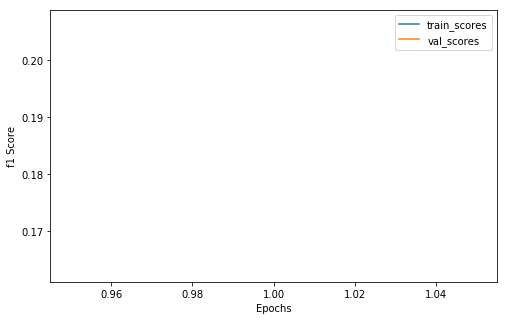

  0%|          | 1/350 [00:09<56:25,  9.70s/it]

Cofusion Matrix For Val Set: 
--  -  -
43  0  0
51  0  0
20  0  0
--  -  -
Score This Epoch: 0.20661526427533802 Best Score: 0.20661526427533802
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
xxxxxxxxxxxxxx epoch: 1 xxxxxxxxxxxxxx


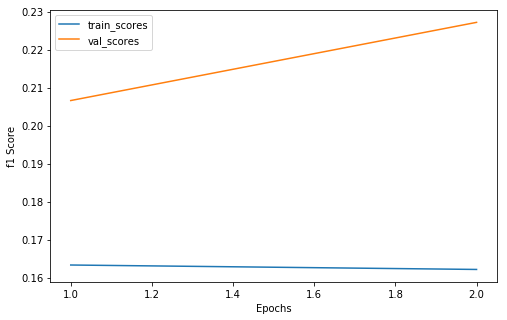

  1%|          | 2/350 [00:18<54:21,  9.37s/it]

Cofusion Matrix For Val Set: 
--  -  -
43  0  0
50  1  0
18  2  0
--  -  -
Score This Epoch: 0.22720943773575353 Best Score: 0.22720943773575353
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
xxxxxxxxxxxxxx epoch: 2 xxxxxxxxxxxxxx


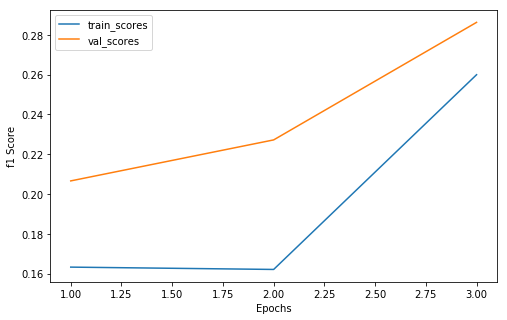

  1%|          | 3/350 [00:27<53:10,  9.19s/it]

Cofusion Matrix For Val Set: 
--  -  -
36  7  0
44  7  0
15  5  0
--  -  -
Score This Epoch: 0.28627002288329517 Best Score: 0.28627002288329517
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0]
xxxxxxxxxxxxxx epoch: 3 xxxxxxxxxxxxxx


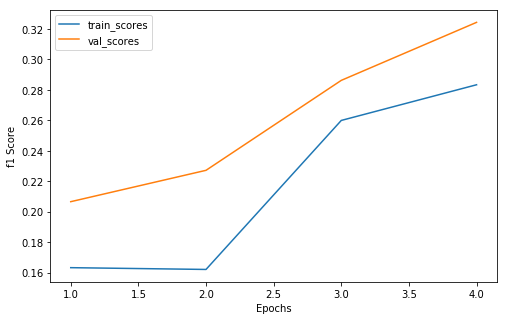

  1%|          | 4/350 [00:35<52:04,  9.03s/it]

Cofusion Matrix For Val Set: 
-  --  -
5  38  0
8  43  0
6  14  0
-  --  -
Score This Epoch: 0.32435596281911144 Best Score: 0.32435596281911144
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 4 xxxxxxxxxxxxxx


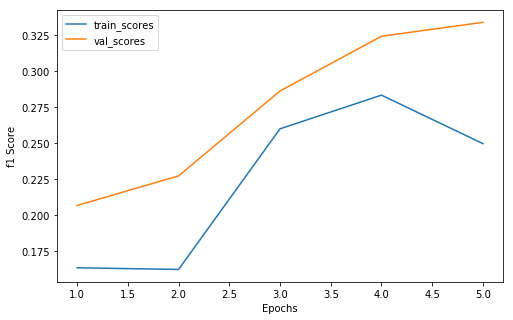

  1%|▏         | 5/350 [00:44<51:16,  8.92s/it]

Cofusion Matrix For Val Set: 
-  --  -
4  39  0
3  48  0
3  17  0
-  --  -
Score This Epoch: 0.33401458606955614 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 5 xxxxxxxxxxxxxx


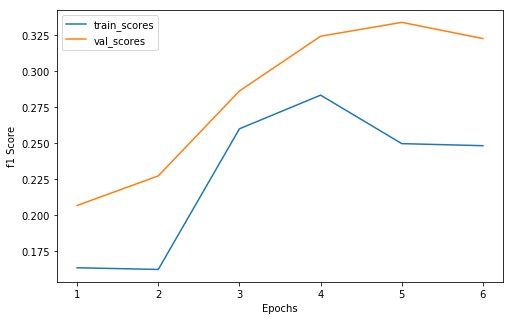

  2%|▏         | 6/350 [00:52<50:32,  8.82s/it]

Cofusion Matrix For Val Set: 
-  --  -
3  40  0
2  49  0
2  18  0
-  --  -
Score This Epoch: 0.322744836775483 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 6 xxxxxxxxxxxxxx


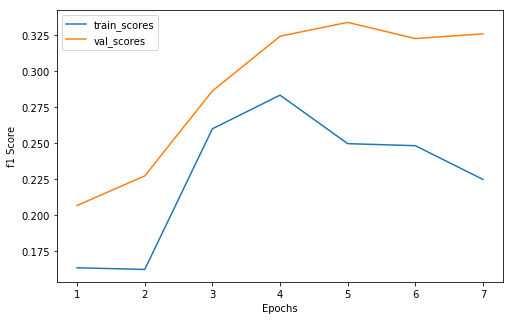

  2%|▏         | 7/350 [01:01<49:40,  8.69s/it]

Cofusion Matrix For Val Set: 
-  --  -
3  40  0
1  50  0
0  20  0
-  --  -
Score This Epoch: 0.32602088013743885 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 7 xxxxxxxxxxxxxx


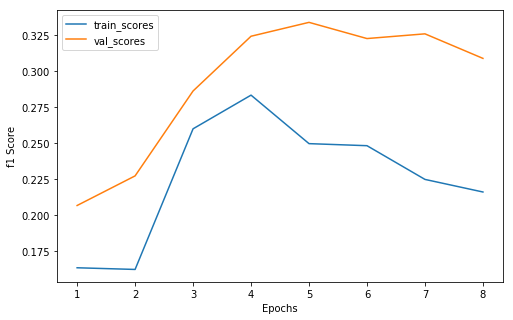

  2%|▏         | 8/350 [01:09<49:06,  8.62s/it]

Cofusion Matrix For Val Set: 
-  --  -
2  41  0
1  50  0
0  20  0
-  --  -
Score This Epoch: 0.30895273610757973 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 8 xxxxxxxxxxxxxx


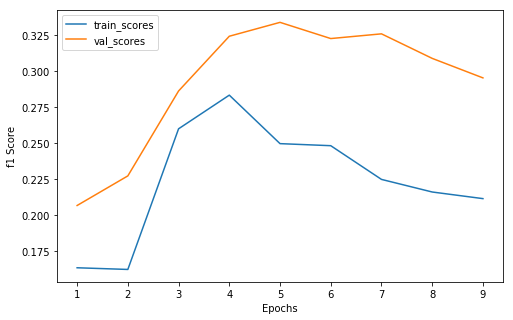

  3%|▎         | 9/350 [01:18<48:37,  8.55s/it]

Cofusion Matrix For Val Set: 
-  --  -
1  42  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.29538647061111756 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 9 xxxxxxxxxxxxxx


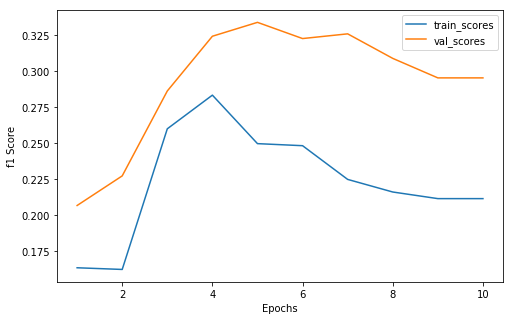

  3%|▎         | 10/350 [01:26<48:09,  8.50s/it]

Cofusion Matrix For Val Set: 
-  --  -
1  42  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.29538647061111756 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 10 xxxxxxxxxxxxxx


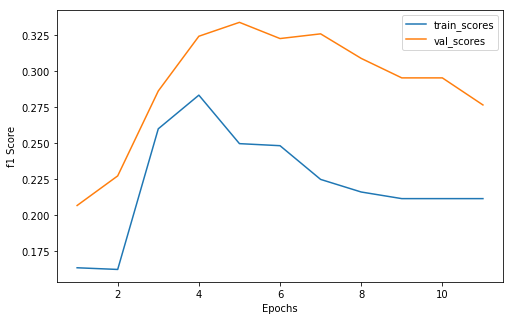

  3%|▎         | 11/350 [01:34<47:52,  8.47s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 11 xxxxxxxxxxxxxx


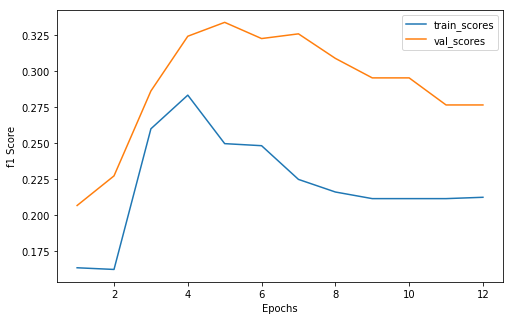

  3%|▎         | 12/350 [01:43<47:40,  8.46s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 12 xxxxxxxxxxxxxx


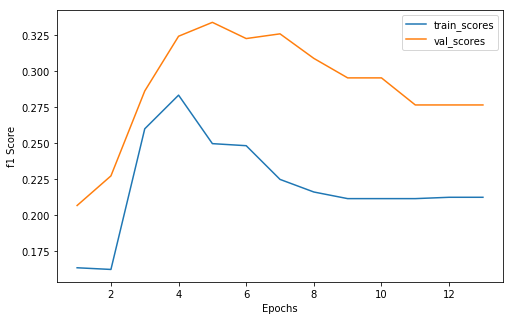

  4%|▎         | 13/350 [01:51<47:29,  8.46s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 13 xxxxxxxxxxxxxx


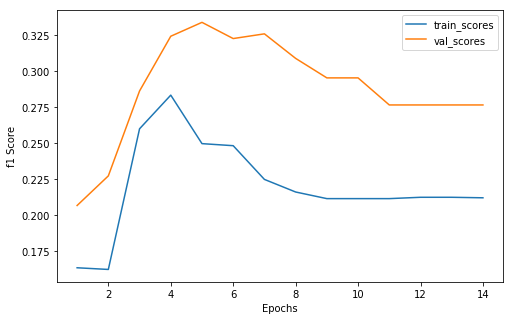

  4%|▍         | 14/350 [02:00<47:19,  8.45s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 14 xxxxxxxxxxxxxx


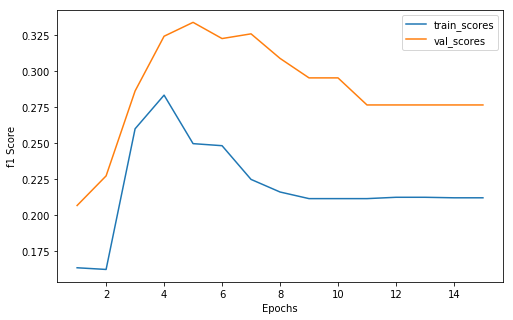

  4%|▍         | 15/350 [02:08<47:09,  8.45s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 15 xxxxxxxxxxxxxx


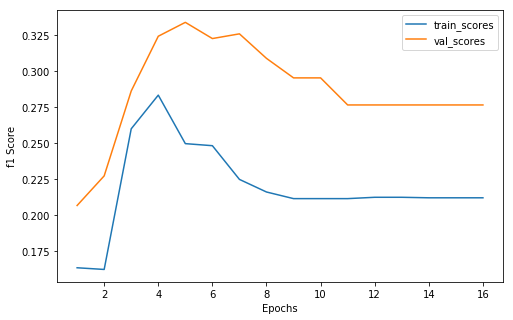

  5%|▍         | 16/350 [02:17<46:59,  8.44s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 16 xxxxxxxxxxxxxx


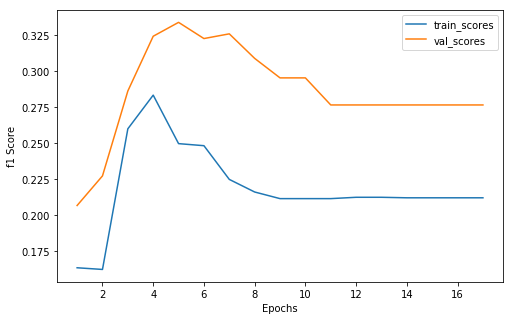

  5%|▍         | 17/350 [02:25<46:46,  8.43s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 17 xxxxxxxxxxxxxx


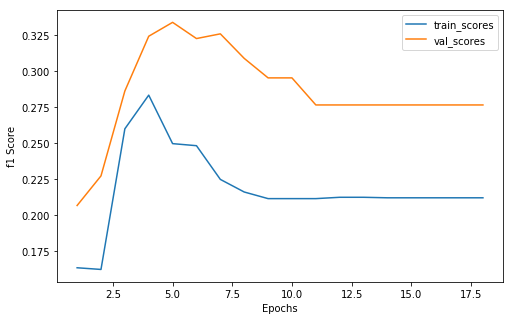

  5%|▌         | 18/350 [02:34<46:38,  8.43s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 18 xxxxxxxxxxxxxx


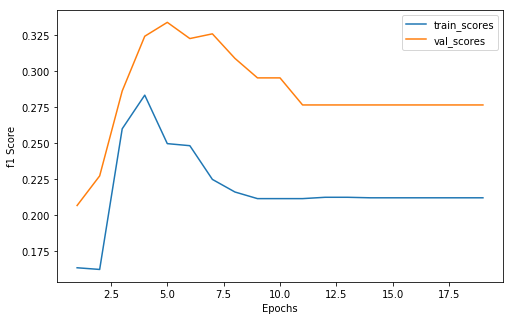

  5%|▌         | 19/350 [02:42<46:30,  8.43s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 19 xxxxxxxxxxxxxx


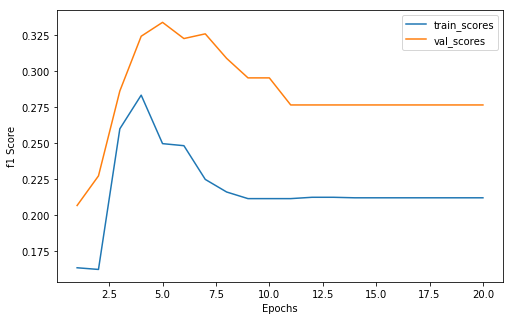

  6%|▌         | 20/350 [02:50<46:20,  8.43s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 20 xxxxxxxxxxxxxx


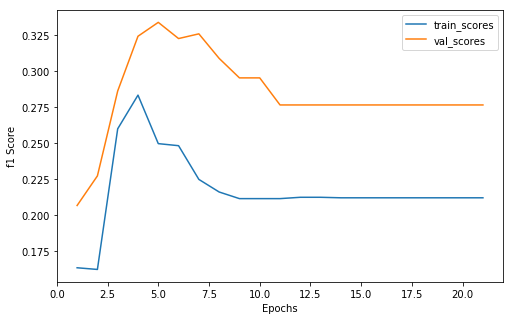

  6%|▌         | 21/350 [02:59<46:05,  8.41s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 21 xxxxxxxxxxxxxx


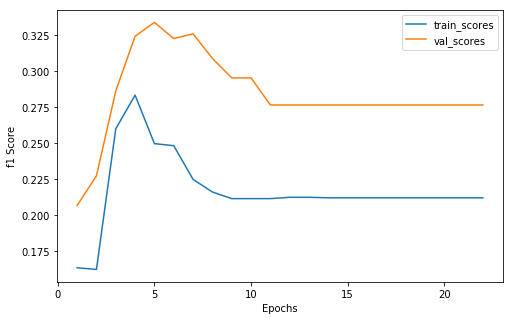

  6%|▋         | 22/350 [03:07<45:58,  8.41s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 22 xxxxxxxxxxxxxx


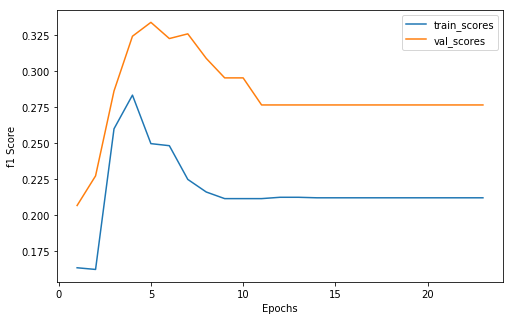

  7%|▋         | 23/350 [03:16<46:08,  8.47s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 23 xxxxxxxxxxxxxx


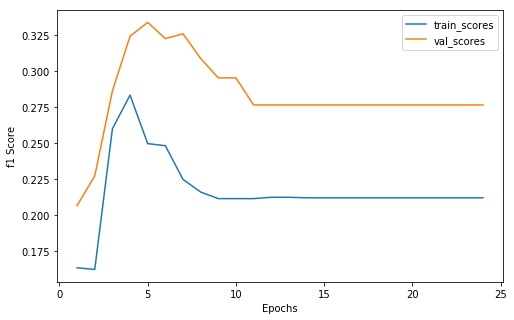

  7%|▋         | 24/350 [03:24<44:55,  8.27s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 24 xxxxxxxxxxxxxx


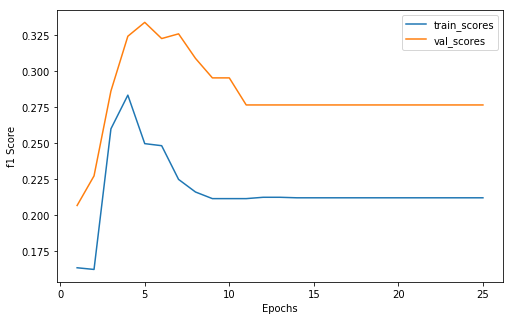

  7%|▋         | 25/350 [03:32<45:04,  8.32s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 25 xxxxxxxxxxxxxx


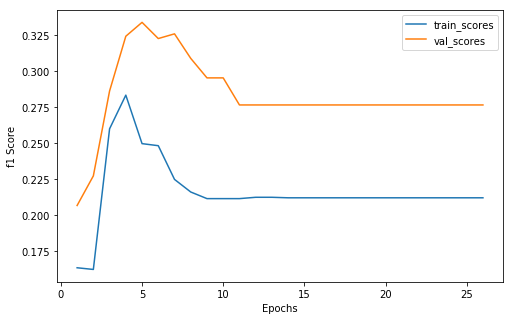

  7%|▋         | 26/350 [03:40<45:03,  8.34s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 26 xxxxxxxxxxxxxx


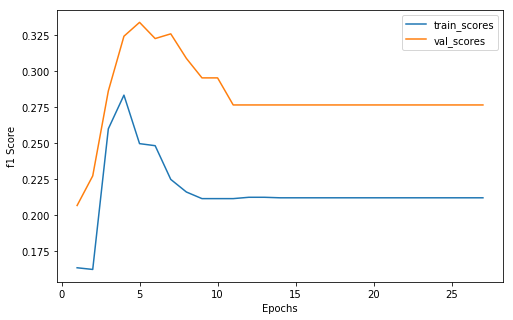

  8%|▊         | 27/350 [03:49<45:01,  8.36s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 27 xxxxxxxxxxxxxx


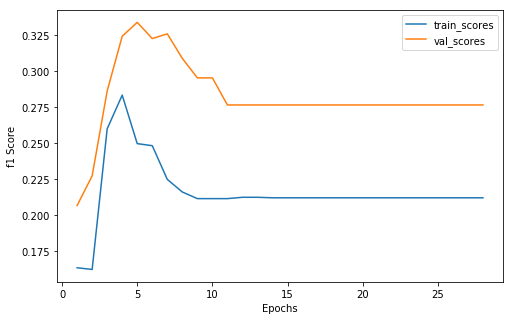

  8%|▊         | 28/350 [03:57<44:57,  8.38s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 28 xxxxxxxxxxxxxx


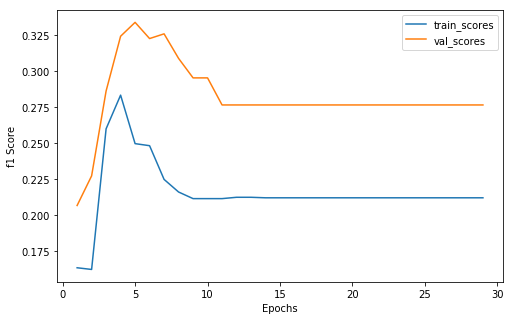

  8%|▊         | 29/350 [04:06<44:48,  8.38s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 29 xxxxxxxxxxxxxx


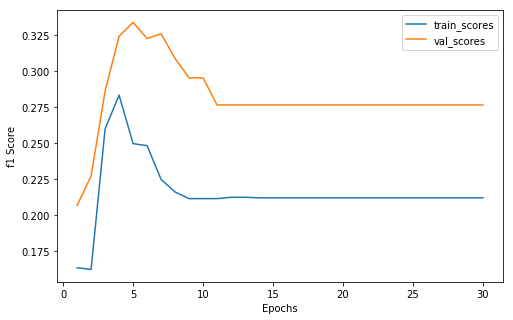

  9%|▊         | 30/350 [04:14<44:38,  8.37s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 30 xxxxxxxxxxxxxx


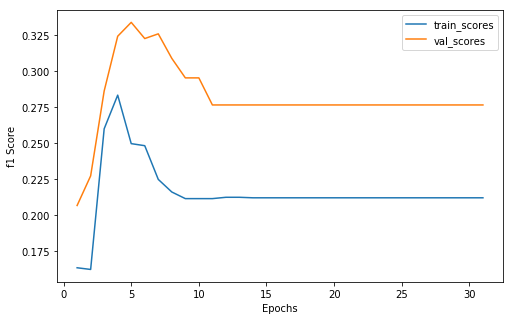

  9%|▉         | 31/350 [04:22<44:40,  8.40s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 31 xxxxxxxxxxxxxx


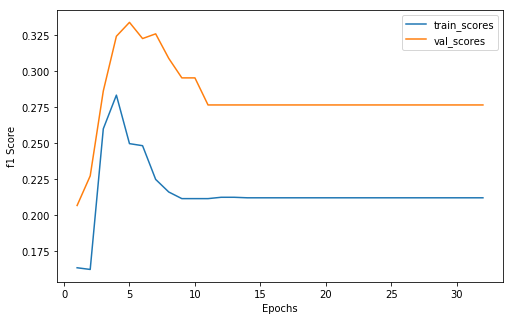

  9%|▉         | 32/350 [04:31<44:39,  8.43s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 32 xxxxxxxxxxxxxx


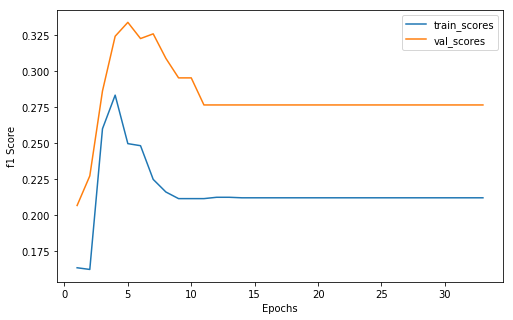

  9%|▉         | 33/350 [04:39<44:30,  8.42s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 33 xxxxxxxxxxxxxx


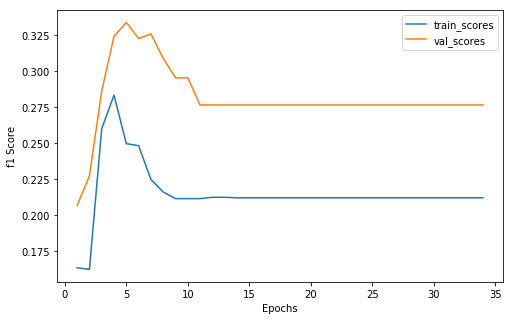

 10%|▉         | 34/350 [04:48<44:20,  8.42s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 34 xxxxxxxxxxxxxx


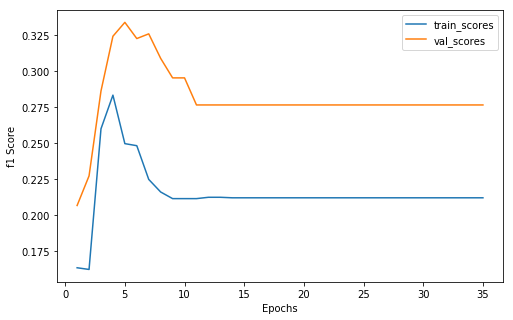

 10%|█         | 35/350 [04:56<44:11,  8.42s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 35 xxxxxxxxxxxxxx


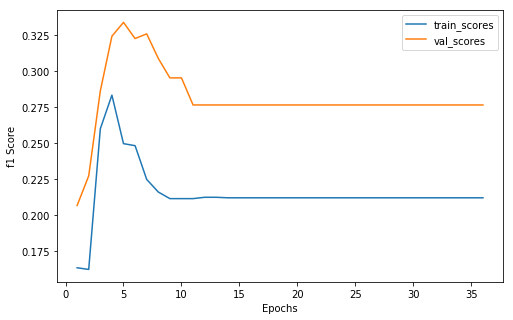

 10%|█         | 36/350 [05:05<43:58,  8.40s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 36 xxxxxxxxxxxxxx


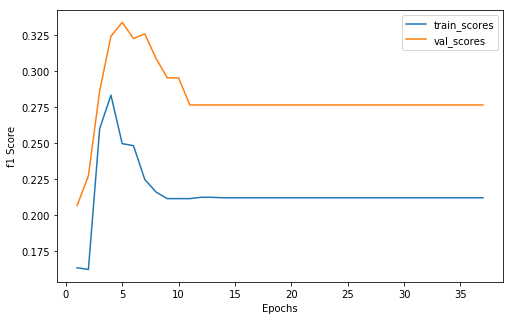

 11%|█         | 37/350 [05:13<43:52,  8.41s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 37 xxxxxxxxxxxxxx


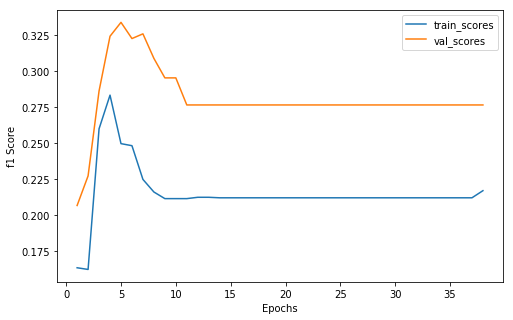

 11%|█         | 38/350 [05:21<43:49,  8.43s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 38 xxxxxxxxxxxxxx


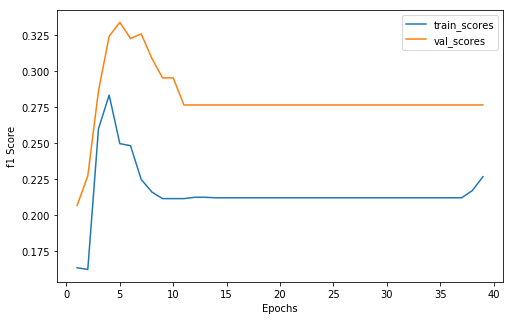

 11%|█         | 39/350 [05:30<43:43,  8.43s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  20  0
-  --  -
Score This Epoch: 0.276555023923445 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 39 xxxxxxxxxxxxxx


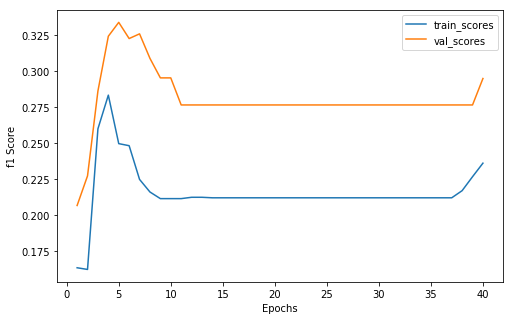

 11%|█▏        | 40/350 [05:38<43:37,  8.44s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  19  1
-  --  -
Score This Epoch: 0.2949497728059987 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 40 xxxxxxxxxxxxxx


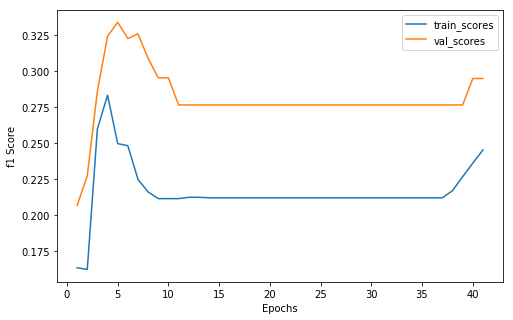

 12%|█▏        | 41/350 [05:47<43:27,  8.44s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  19  1
-  --  -
Score This Epoch: 0.2949497728059987 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 41 xxxxxxxxxxxxxx


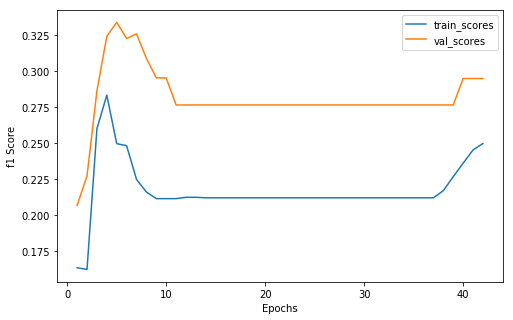

 12%|█▏        | 42/350 [05:55<43:14,  8.42s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  19  1
-  --  -
Score This Epoch: 0.2949497728059987 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 42 xxxxxxxxxxxxxx


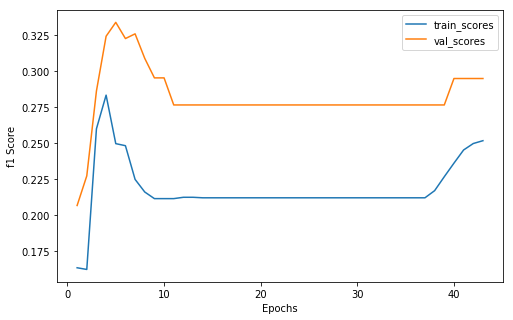

 12%|█▏        | 43/350 [06:04<43:09,  8.44s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  19  1
-  --  -
Score This Epoch: 0.2949497728059987 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 43 xxxxxxxxxxxxxx


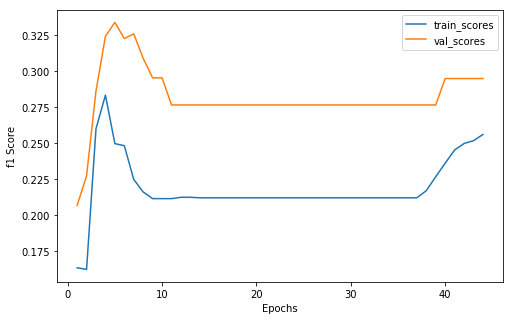

 13%|█▎        | 44/350 [06:12<43:02,  8.44s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  19  1
-  --  -
Score This Epoch: 0.2949497728059987 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 44 xxxxxxxxxxxxxx


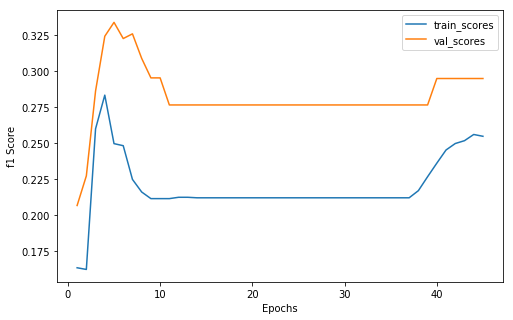

 13%|█▎        | 45/350 [06:20<42:18,  8.32s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  19  1
-  --  -
Score This Epoch: 0.2949497728059987 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 45 xxxxxxxxxxxxxx


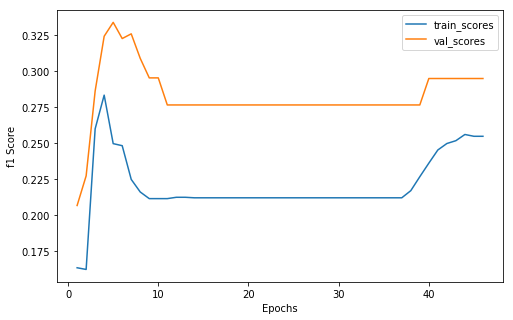

 13%|█▎        | 46/350 [06:28<40:57,  8.08s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  19  1
-  --  -
Score This Epoch: 0.2949497728059987 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 46 xxxxxxxxxxxxxx


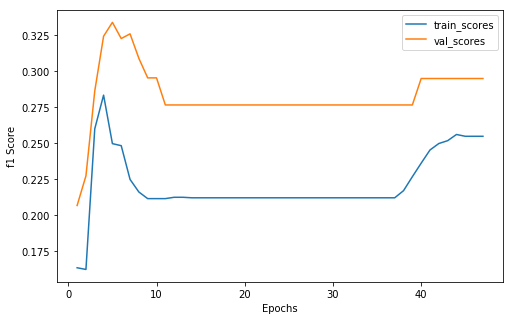

 13%|█▎        | 47/350 [06:36<41:19,  8.18s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  19  1
-  --  -
Score This Epoch: 0.2949497728059987 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 47 xxxxxxxxxxxxxx


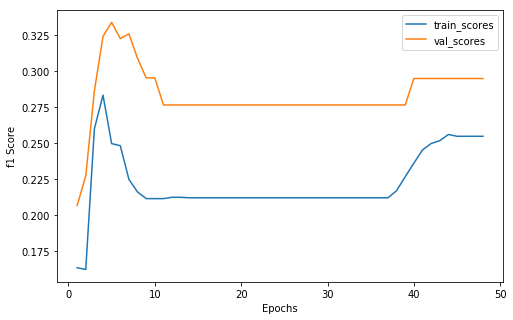

 14%|█▎        | 48/350 [06:45<41:48,  8.31s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  43  0
0  51  0
0  19  1
-  --  -
Score This Epoch: 0.2949497728059987 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 48 xxxxxxxxxxxxxx


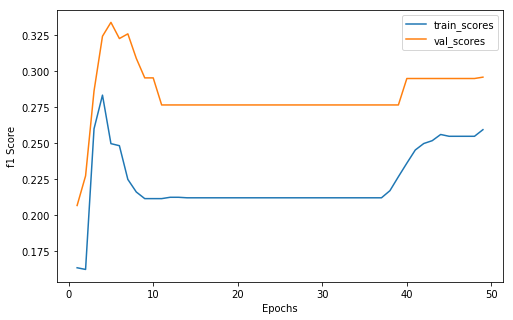

 14%|█▍        | 49/350 [06:53<41:51,  8.34s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  42  1
0  51  0
0  19  1
-  --  -
Score This Epoch: 0.29589730041780415 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 49 xxxxxxxxxxxxxx


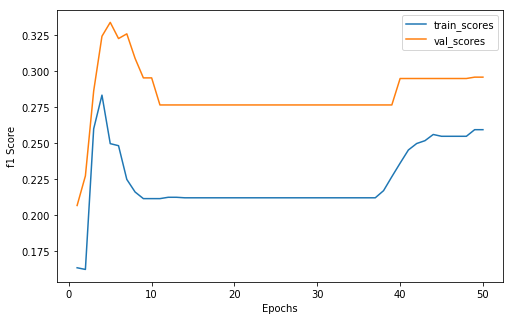

 14%|█▍        | 50/350 [07:01<41:49,  8.36s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  42  1
0  51  0
0  19  1
-  --  -
Score This Epoch: 0.29589730041780415 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 50 xxxxxxxxxxxxxx


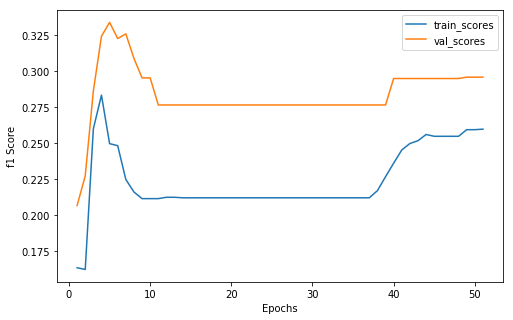

 15%|█▍        | 51/350 [07:10<41:43,  8.37s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  42  1
0  51  0
0  19  1
-  --  -
Score This Epoch: 0.29589730041780415 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 51 xxxxxxxxxxxxxx


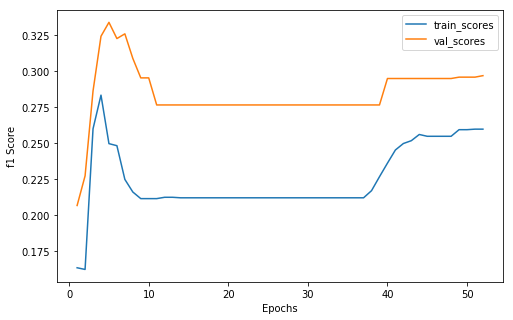

 15%|█▍        | 52/350 [07:18<41:39,  8.39s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  41  2
0  51  0
0  19  1
-  --  -
Score This Epoch: 0.29693194338503265 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 52 xxxxxxxxxxxxxx


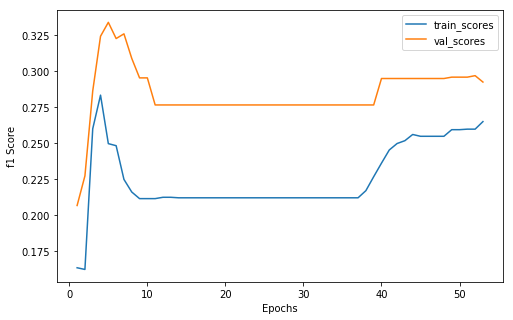

 15%|█▌        | 53/350 [07:27<41:33,  8.40s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  41  2
0  50  1
0  19  1
-  --  -
Score This Epoch: 0.2924884675456758 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 53 xxxxxxxxxxxxxx


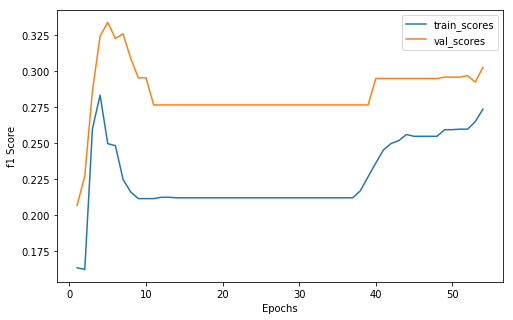

 15%|█▌        | 54/350 [07:35<41:24,  8.39s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  41  2
0  49  2
0  18  2
-  --  -
Score This Epoch: 0.3027270643953861 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 54 xxxxxxxxxxxxxx


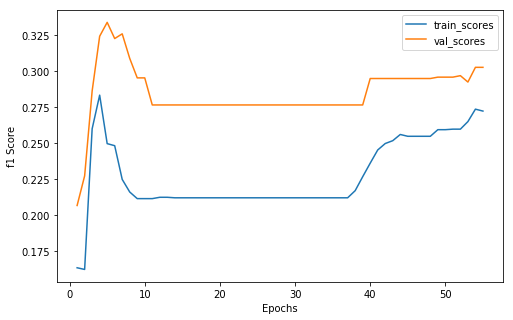

 16%|█▌        | 55/350 [07:43<41:14,  8.39s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  41  2
0  49  2
0  18  2
-  --  -
Score This Epoch: 0.3027270643953861 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 55 xxxxxxxxxxxxxx


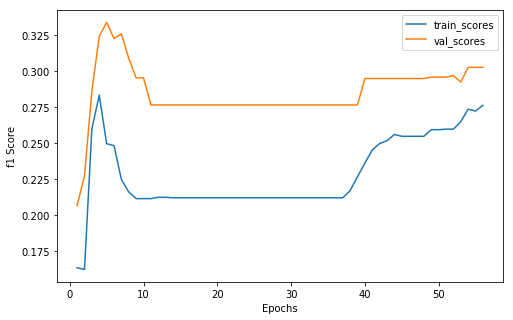

 16%|█▌        | 56/350 [07:52<41:02,  8.38s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  41  2
0  49  2
0  18  2
-  --  -
Score This Epoch: 0.3027270643953861 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
xxxxxxxxxxxxxx epoch: 56 xxxxxxxxxxxxxx


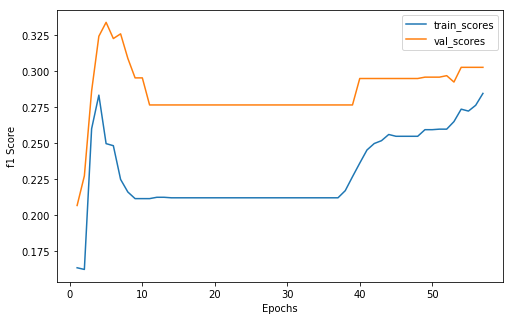

 16%|█▋        | 57/350 [08:00<40:52,  8.37s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  41  2
0  49  2
0  18  2
-  --  -
Score This Epoch: 0.3027270643953861 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
xxxxxxxxxxxxxx epoch: 57 xxxxxxxxxxxxxx


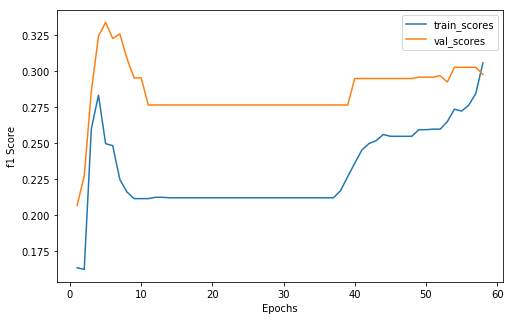

 17%|█▋        | 58/350 [08:09<40:41,  8.36s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  41  2
0  48  3
0  18  2
-  --  -
Score This Epoch: 0.2978096906589022 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
xxxxxxxxxxxxxx epoch: 58 xxxxxxxxxxxxxx


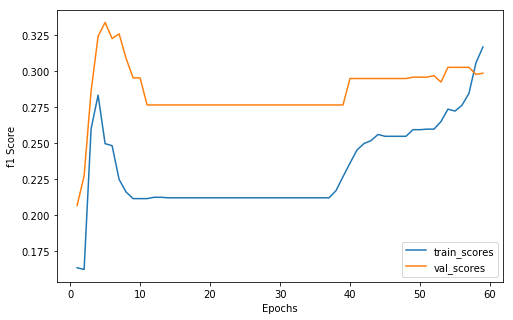

 17%|█▋        | 59/350 [08:17<40:38,  8.38s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  40  3
0  48  3
0  18  2
-  --  -
Score This Epoch: 0.29861277397314945 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
xxxxxxxxxxxxxx epoch: 59 xxxxxxxxxxxxxx


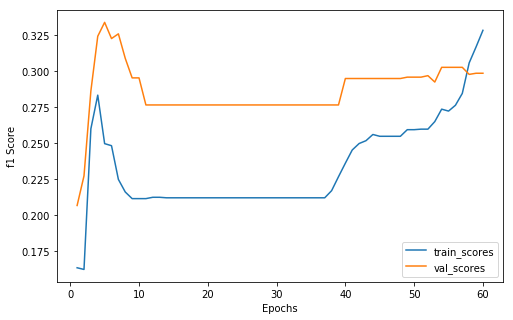

 17%|█▋        | 60/350 [08:25<40:35,  8.40s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  40  3
0  48  3
0  18  2
-  --  -
Score This Epoch: 0.29861277397314945 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
xxxxxxxxxxxxxx epoch: 60 xxxxxxxxxxxxxx


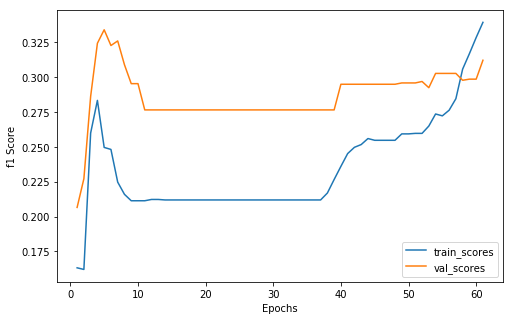

 17%|█▋        | 61/350 [08:34<40:29,  8.41s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  39  4
0  48  3
0  17  3
-  --  -
Score This Epoch: 0.31216751556310135 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
xxxxxxxxxxxxxx epoch: 61 xxxxxxxxxxxxxx


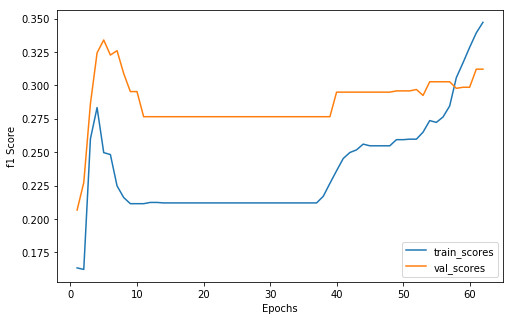

 18%|█▊        | 62/350 [08:42<40:17,  8.39s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  39  4
0  48  3
0  17  3
-  --  -
Score This Epoch: 0.31216751556310135 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
xxxxxxxxxxxxxx epoch: 62 xxxxxxxxxxxxxx


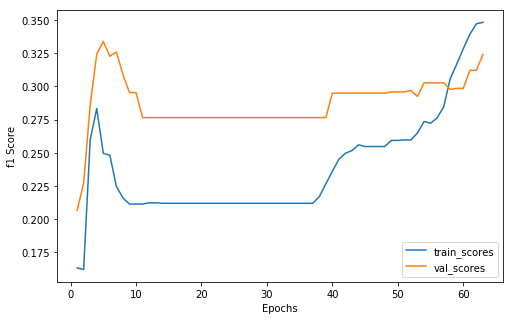

 18%|█▊        | 63/350 [08:51<41:23,  8.65s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  39  4
0  48  3
0  16  4
-  --  -
Score This Epoch: 0.32415349223498635 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
xxxxxxxxxxxxxx epoch: 63 xxxxxxxxxxxxxx


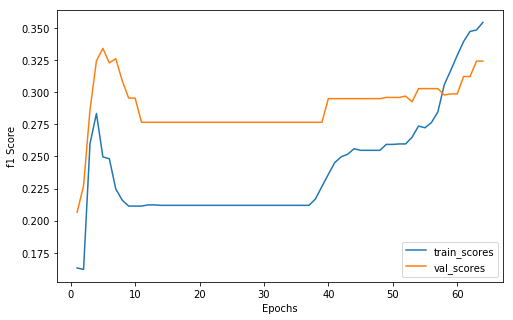

 18%|█▊        | 64/350 [09:00<40:51,  8.57s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  39  4
0  48  3
0  16  4
-  --  -
Score This Epoch: 0.32415349223498635 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
xxxxxxxxxxxxxx epoch: 64 xxxxxxxxxxxxxx


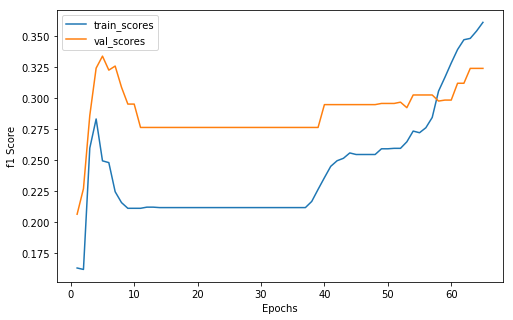

 19%|█▊        | 65/350 [09:08<40:21,  8.50s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  39  4
0  48  3
0  16  4
-  --  -
Score This Epoch: 0.32415349223498635 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
xxxxxxxxxxxxxx epoch: 65 xxxxxxxxxxxxxx


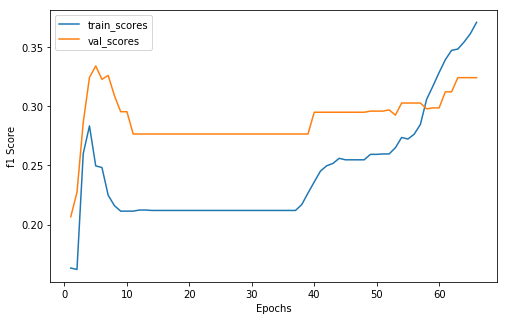

 19%|█▉        | 66/350 [09:17<40:03,  8.46s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  39  4
0  48  3
0  16  4
-  --  -
Score This Epoch: 0.32415349223498635 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
xxxxxxxxxxxxxx epoch: 66 xxxxxxxxxxxxxx


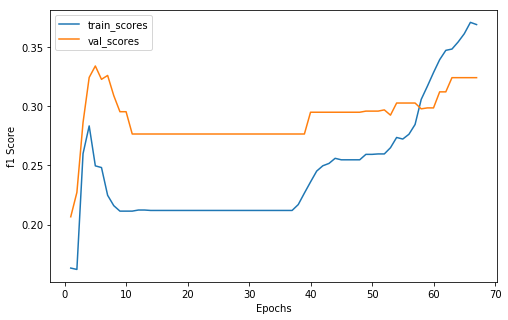

 19%|█▉        | 67/350 [09:25<39:50,  8.45s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  39  4
0  48  3
0  16  4
-  --  -
Score This Epoch: 0.32415349223498635 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
xxxxxxxxxxxxxx epoch: 67 xxxxxxxxxxxxxx


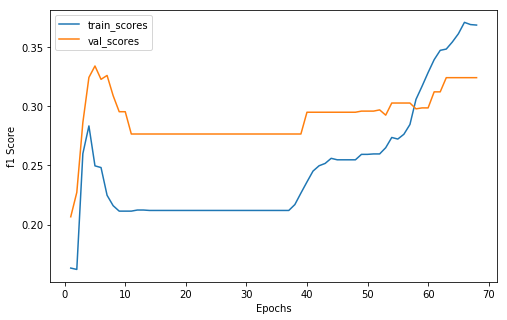

 19%|█▉        | 68/350 [09:33<39:41,  8.45s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  39  4
0  48  3
0  16  4
-  --  -
Score This Epoch: 0.32415349223498635 Best Score: 0.33401458606955614
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
xxxxxxxxxxxxxx epoch: 68 xxxxxxxxxxxxxx


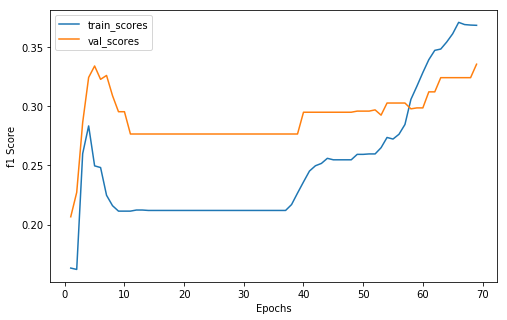

 20%|█▉        | 69/350 [09:42<39:28,  8.43s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  39  4
0  48  3
0  15  5
-  --  -
Score This Epoch: 0.33552631578947373 Best Score: 0.33552631578947373
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
xxxxxxxxxxxxxx epoch: 69 xxxxxxxxxxxxxx


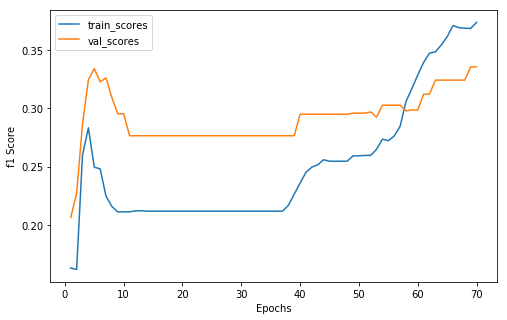

 20%|██        | 70/350 [09:50<39:13,  8.41s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  39  4
0  48  3
0  15  5
-  --  -
Score This Epoch: 0.33552631578947373 Best Score: 0.33552631578947373
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
xxxxxxxxxxxxxx epoch: 70 xxxxxxxxxxxxxx


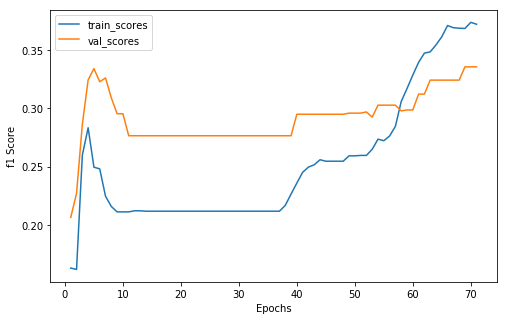

 20%|██        | 71/350 [09:59<39:14,  8.44s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  39  4
0  48  3
0  15  5
-  --  -
Score This Epoch: 0.33552631578947373 Best Score: 0.33552631578947373
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
xxxxxxxxxxxxxx epoch: 71 xxxxxxxxxxxxxx


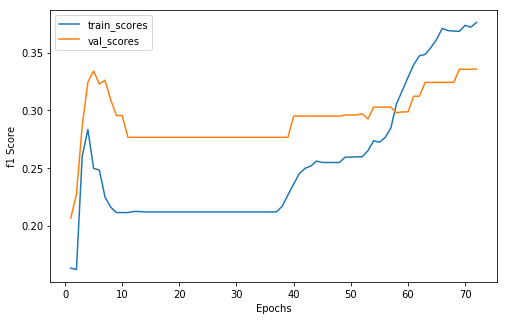

 21%|██        | 72/350 [10:07<39:00,  8.42s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  38  5
0  48  3
0  15  5
-  --  -
Score This Epoch: 0.3357116875122415 Best Score: 0.3357116875122415
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2]
xxxxxxxxxxxxxx epoch: 72 xxxxxxxxxxxxxx


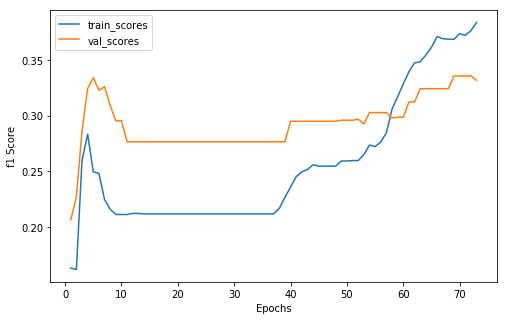

 21%|██        | 73/350 [10:15<38:46,  8.40s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  38  5
1  47  3
0  15  5
-  --  -
Score This Epoch: 0.33165745992514895 Best Score: 0.3357116875122415
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2]
xxxxxxxxxxxxxx epoch: 73 xxxxxxxxxxxxxx


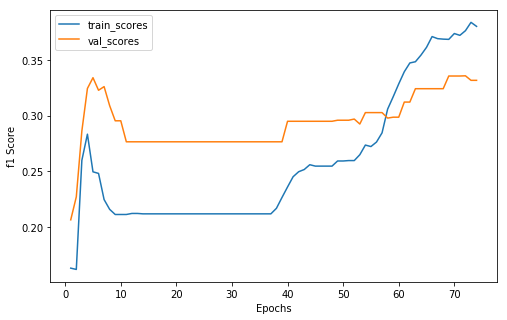

 21%|██        | 74/350 [10:24<38:38,  8.40s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  38  5
1  47  3
0  15  5
-  --  -
Score This Epoch: 0.33165745992514895 Best Score: 0.3357116875122415
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2]
xxxxxxxxxxxxxx epoch: 74 xxxxxxxxxxxxxx


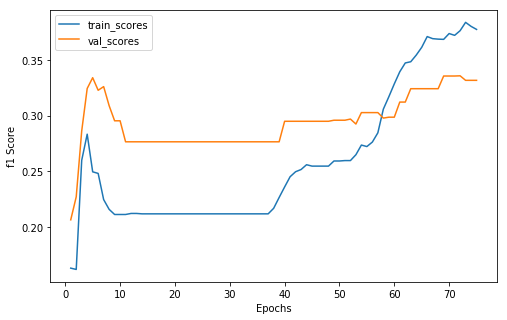

 21%|██▏       | 75/350 [10:32<38:45,  8.46s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  38  5
1  47  3
0  15  5
-  --  -
Score This Epoch: 0.33165745992514895 Best Score: 0.3357116875122415
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2]
xxxxxxxxxxxxxx epoch: 75 xxxxxxxxxxxxxx


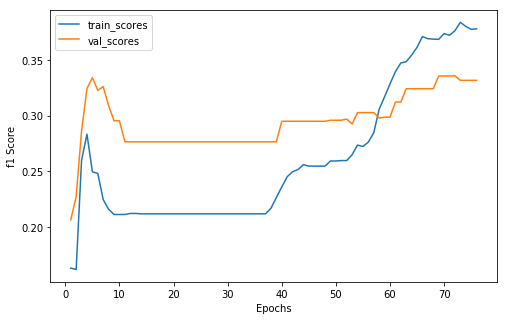

 22%|██▏       | 76/350 [10:41<38:29,  8.43s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  38  5
1  47  3
0  15  5
-  --  -
Score This Epoch: 0.33165745992514895 Best Score: 0.3357116875122415
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2]
xxxxxxxxxxxxxx epoch: 76 xxxxxxxxxxxxxx


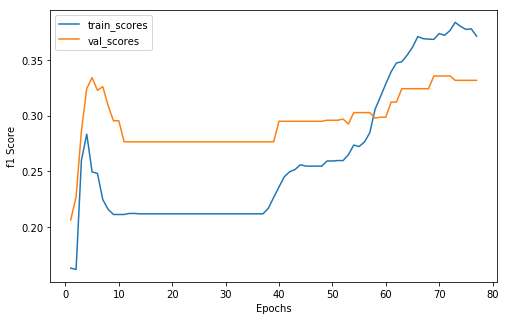

 22%|██▏       | 77/350 [10:49<38:14,  8.40s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  38  5
1  47  3
0  15  5
-  --  -
Score This Epoch: 0.33165745992514895 Best Score: 0.3357116875122415
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2]
xxxxxxxxxxxxxx epoch: 77 xxxxxxxxxxxxxx


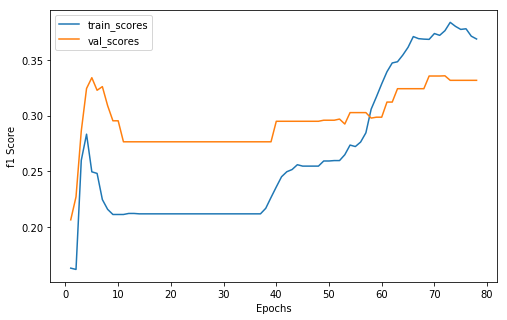

 22%|██▏       | 78/350 [10:57<38:04,  8.40s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  38  5
1  47  3
0  15  5
-  --  -
Score This Epoch: 0.33165745992514895 Best Score: 0.3357116875122415
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 78 xxxxxxxxxxxxxx


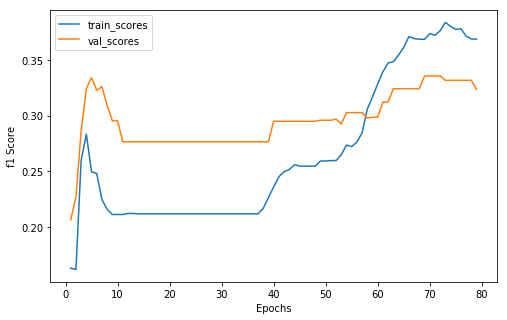

 23%|██▎       | 79/350 [11:06<37:55,  8.40s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  38  5
3  45  3
0  15  5
-  --  -
Score This Epoch: 0.3233857472642354 Best Score: 0.3357116875122415
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 79 xxxxxxxxxxxxxx


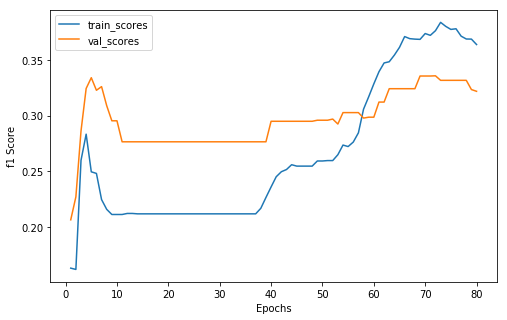

 23%|██▎       | 80/350 [11:14<37:54,  8.42s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  38  5
2  45  4
0  15  5
-  --  -
Score This Epoch: 0.3218221234095899 Best Score: 0.3357116875122415
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 80 xxxxxxxxxxxxxx


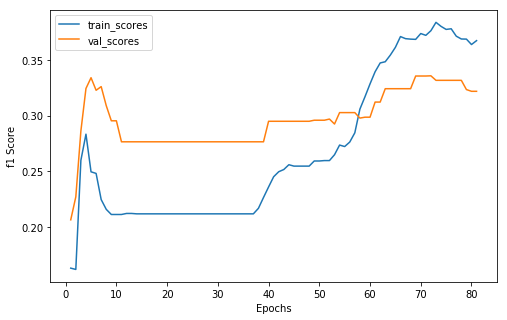

 23%|██▎       | 81/350 [11:23<37:42,  8.41s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  38  5
2  45  4
0  15  5
-  --  -
Score This Epoch: 0.3218221234095899 Best Score: 0.3357116875122415
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 81 xxxxxxxxxxxxxx


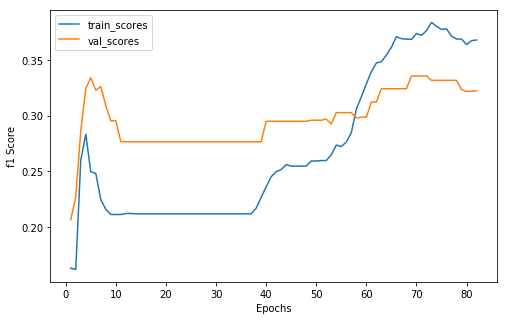

 23%|██▎       | 82/350 [11:31<37:31,  8.40s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  37  6
2  45  4
0  15  5
-  --  -
Score This Epoch: 0.3221736774368353 Best Score: 0.3357116875122415
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 82 xxxxxxxxxxxxxx


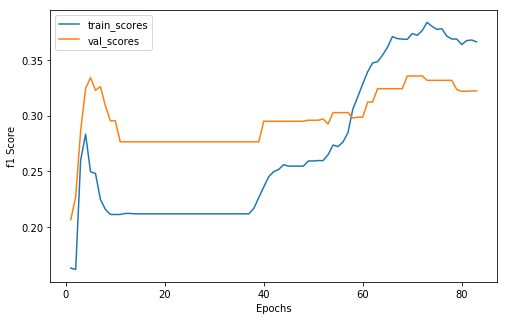

 24%|██▎       | 83/350 [11:40<37:27,  8.42s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  37  6
2  45  4
0  15  5
-  --  -
Score This Epoch: 0.3221736774368353 Best Score: 0.3357116875122415
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 83 xxxxxxxxxxxxxx


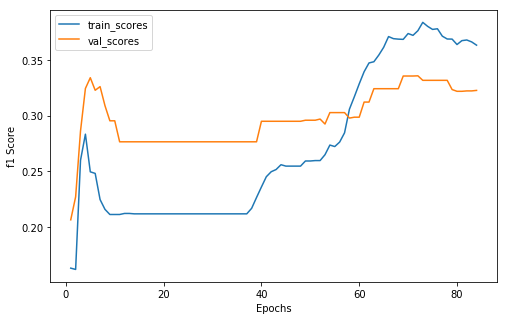

 24%|██▍       | 84/350 [11:48<37:17,  8.41s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  36  7
2  45  4
0  15  5
-  --  -
Score This Epoch: 0.32263197676731514 Best Score: 0.3357116875122415
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 84 xxxxxxxxxxxxxx


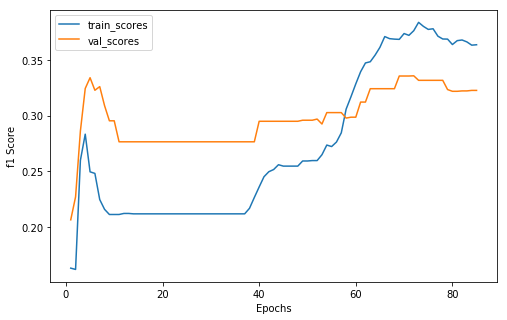

 24%|██▍       | 85/350 [11:56<37:08,  8.41s/it]

Cofusion Matrix For Val Set: 
-  --  -
0  36  7
2  45  4
0  15  5
-  --  -
Score This Epoch: 0.32263197676731514 Best Score: 0.3357116875122415
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 85 xxxxxxxxxxxxxx


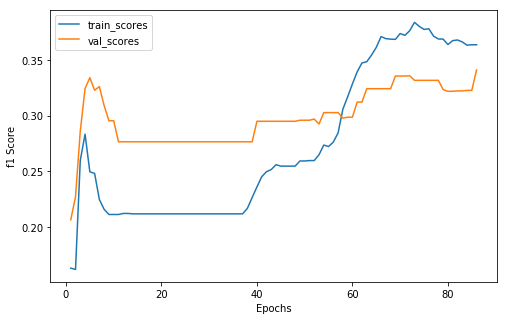

 25%|██▍       | 86/350 [12:05<37:00,  8.41s/it]

Cofusion Matrix For Val Set: 
-  --  -
1  35  7
2  45  4
0  15  5
-  --  -
Score This Epoch: 0.34090769243272295 Best Score: 0.34090769243272295
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 86 xxxxxxxxxxxxxx


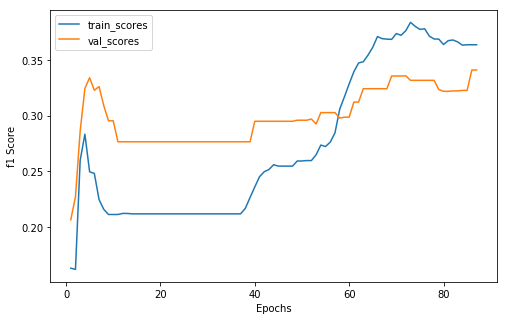

 25%|██▍       | 87/350 [12:13<36:53,  8.42s/it]

Cofusion Matrix For Val Set: 
-  --  -
1  35  7
2  45  4
0  15  5
-  --  -
Score This Epoch: 0.34090769243272295 Best Score: 0.34090769243272295
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 87 xxxxxxxxxxxxxx


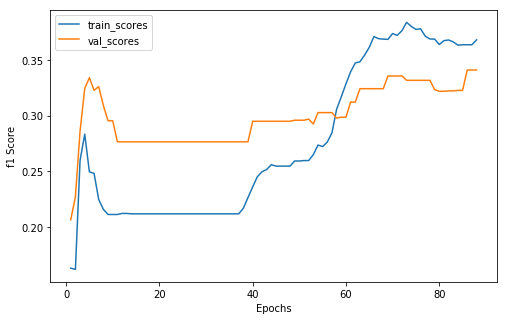

 25%|██▌       | 88/350 [12:22<36:48,  8.43s/it]

Cofusion Matrix For Val Set: 
-  --  -
1  35  7
2  45  4
0  15  5
-  --  -
Score This Epoch: 0.34090769243272295 Best Score: 0.34090769243272295
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 88 xxxxxxxxxxxxxx


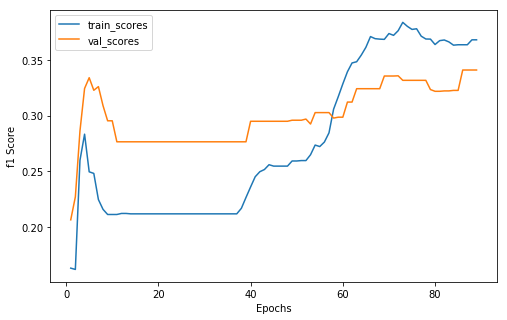

 25%|██▌       | 89/350 [12:30<36:50,  8.47s/it]

Cofusion Matrix For Val Set: 
-  --  -
1  35  7
2  45  4
0  15  5
-  --  -
Score This Epoch: 0.34090769243272295 Best Score: 0.34090769243272295
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 89 xxxxxxxxxxxxxx


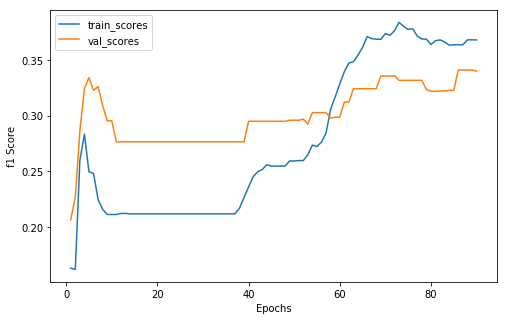

 26%|██▌       | 90/350 [12:39<36:46,  8.49s/it]

Cofusion Matrix For Val Set: 
-  --  -
1  35  7
1  45  5
0  15  5
-  --  -
Score This Epoch: 0.3399550235166673 Best Score: 0.34090769243272295
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 90 xxxxxxxxxxxxxx


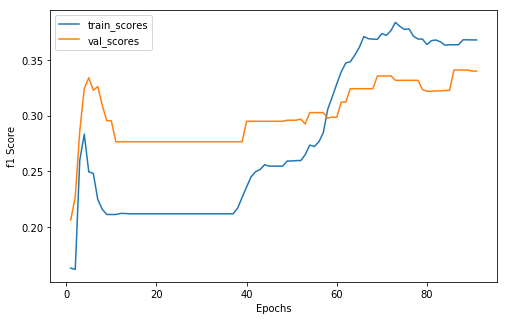

 26%|██▌       | 91/350 [12:47<36:25,  8.44s/it]

Cofusion Matrix For Val Set: 
-  --  -
1  35  7
1  45  5
0  15  5
-  --  -
Score This Epoch: 0.3399550235166673 Best Score: 0.34090769243272295
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 91 xxxxxxxxxxxxxx


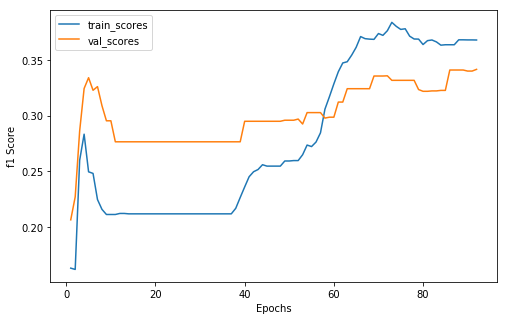

 26%|██▋       | 92/350 [12:56<36:19,  8.45s/it]

Cofusion Matrix For Val Set: 
-  --  -
1  35  7
1  45  5
1  14  5
-  --  -
Score This Epoch: 0.3414924827771036 Best Score: 0.3414924827771036
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 92 xxxxxxxxxxxxxx


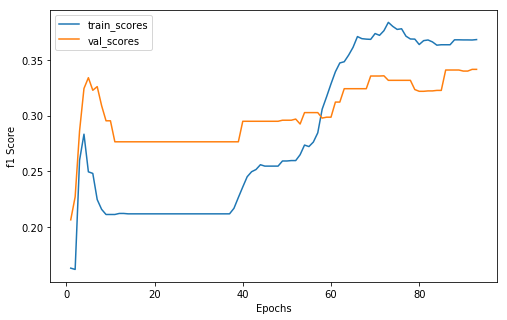

 27%|██▋       | 93/350 [13:04<36:05,  8.43s/it]

Cofusion Matrix For Val Set: 
-  --  -
1  35  7
1  45  5
1  14  5
-  --  -
Score This Epoch: 0.3414924827771036 Best Score: 0.3414924827771036
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 93 xxxxxxxxxxxxxx


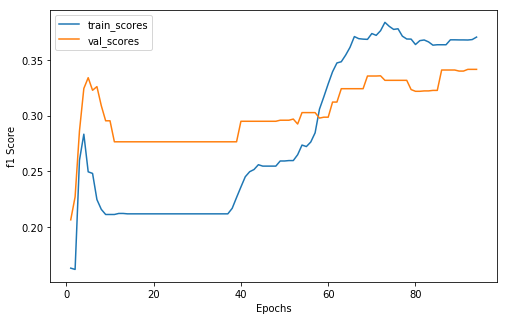

 27%|██▋       | 94/350 [13:12<36:05,  8.46s/it]

Cofusion Matrix For Val Set: 
-  --  -
1  35  7
1  45  5
1  14  5
-  --  -
Score This Epoch: 0.3414924827771036 Best Score: 0.3414924827771036
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 94 xxxxxxxxxxxxxx


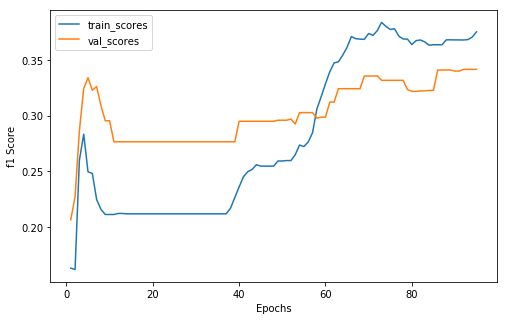

 27%|██▋       | 95/350 [13:20<35:13,  8.29s/it]

Cofusion Matrix For Val Set: 
-  --  -
1  35  7
1  45  5
1  14  5
-  --  -
Score This Epoch: 0.3414924827771036 Best Score: 0.3414924827771036
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 95 xxxxxxxxxxxxxx


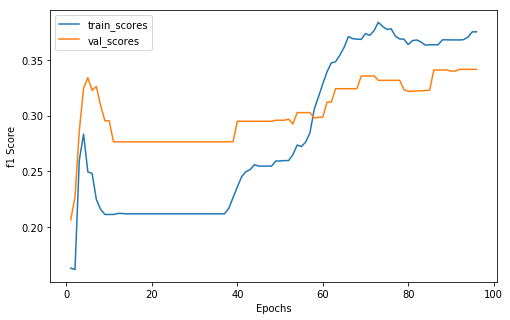

 27%|██▋       | 96/350 [13:29<35:26,  8.37s/it]

Cofusion Matrix For Val Set: 
-  --  -
1  35  7
1  45  5
1  14  5
-  --  -
Score This Epoch: 0.3414924827771036 Best Score: 0.3414924827771036
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 96 xxxxxxxxxxxxxx


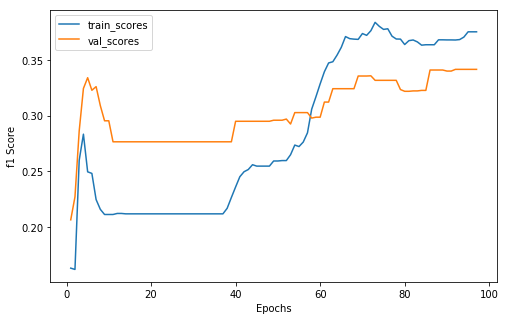

 28%|██▊       | 97/350 [13:37<35:32,  8.43s/it]

Cofusion Matrix For Val Set: 
-  --  -
1  35  7
1  45  5
1  14  5
-  --  -
Score This Epoch: 0.3414924827771036 Best Score: 0.3414924827771036
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 97 xxxxxxxxxxxxxx


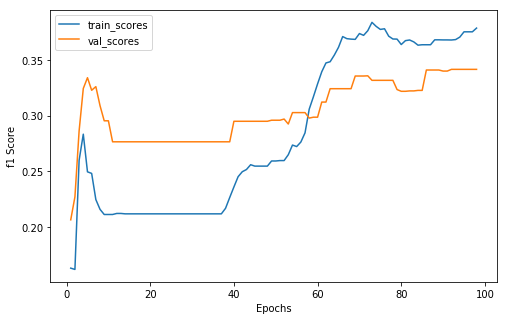

 28%|██▊       | 98/350 [13:46<35:45,  8.51s/it]

Cofusion Matrix For Val Set: 
-  --  -
1  35  7
1  45  5
1  14  5
-  --  -
Score This Epoch: 0.3414924827771036 Best Score: 0.3414924827771036
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 98 xxxxxxxxxxxxxx


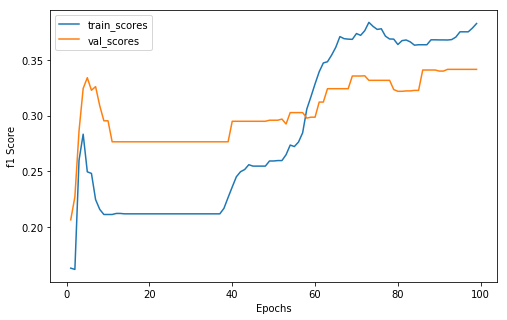

 28%|██▊       | 99/350 [13:55<35:42,  8.54s/it]

Cofusion Matrix For Val Set: 
-  --  -
1  35  7
1  45  5
1  14  5
-  --  -
Score This Epoch: 0.3414924827771036 Best Score: 0.3414924827771036
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 99 xxxxxxxxxxxxxx


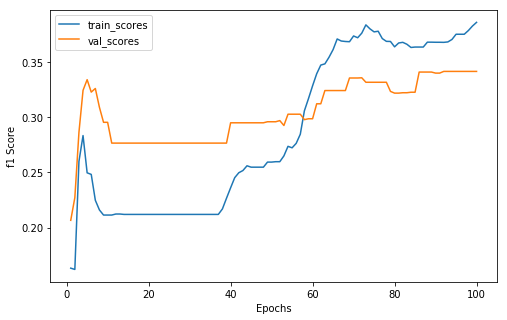

 29%|██▊       | 100/350 [14:03<35:39,  8.56s/it]

Cofusion Matrix For Val Set: 
-  --  -
1  35  7
1  45  5
1  14  5
-  --  -
Score This Epoch: 0.3414924827771036 Best Score: 0.3414924827771036
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 100 xxxxxxxxxxxxxx


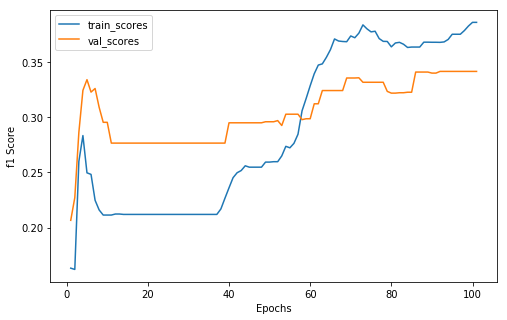

 29%|██▉       | 101/350 [14:12<35:49,  8.63s/it]

Cofusion Matrix For Val Set: 
-  --  -
1  35  7
1  45  5
1  14  5
-  --  -
Score This Epoch: 0.3414924827771036 Best Score: 0.3414924827771036
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 101 xxxxxxxxxxxxxx


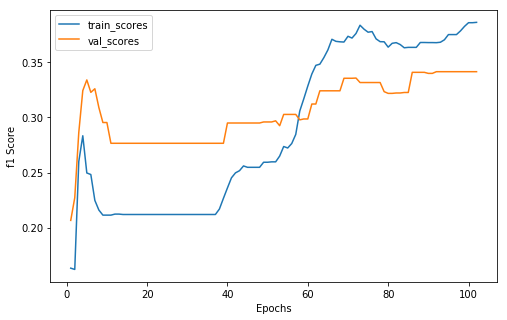

 29%|██▉       | 102/350 [14:21<35:56,  8.70s/it]

Cofusion Matrix For Val Set: 
-  --  -
1  35  7
1  45  5
1  14  5
-  --  -
Score This Epoch: 0.3414924827771036 Best Score: 0.3414924827771036
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 102 xxxxxxxxxxxxxx


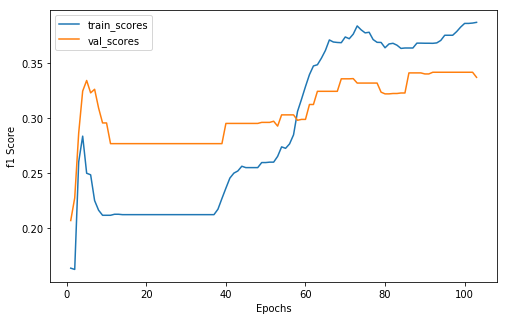

 29%|██▉       | 103/350 [14:30<35:54,  8.72s/it]

Cofusion Matrix For Val Set: 
-  --  -
1  35  7
2  44  5
1  14  5
-  --  -
Score This Epoch: 0.33685841496591773 Best Score: 0.3414924827771036
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 103 xxxxxxxxxxxxxx


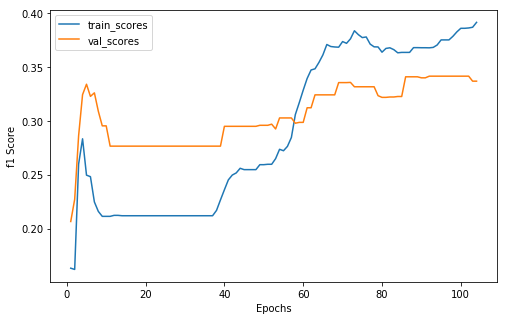

 30%|██▉       | 104/350 [14:39<35:48,  8.73s/it]

Cofusion Matrix For Val Set: 
-  --  -
1  35  7
2  44  5
1  14  5
-  --  -
Score This Epoch: 0.33685841496591773 Best Score: 0.3414924827771036
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 104 xxxxxxxxxxxxxx


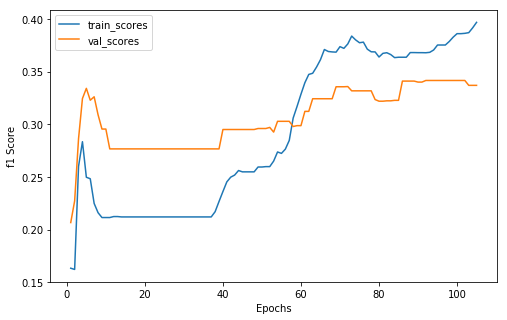

 30%|███       | 105/350 [14:47<35:28,  8.69s/it]

Cofusion Matrix For Val Set: 
-  --  -
1  35  7
2  44  5
1  14  5
-  --  -
Score This Epoch: 0.33685841496591773 Best Score: 0.3414924827771036
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 105 xxxxxxxxxxxxxx


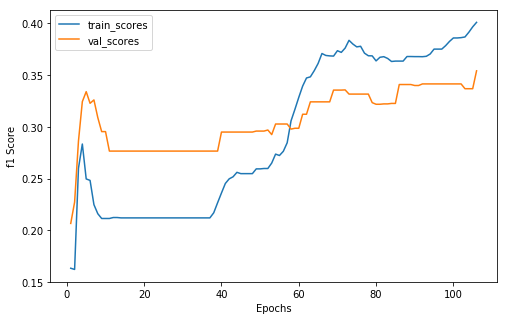

 30%|███       | 106/350 [14:56<35:02,  8.61s/it]

Cofusion Matrix For Val Set: 
-  --  -
2  34  7
2  44  5
1  14  5
-  --  -
Score This Epoch: 0.35415222915222916 Best Score: 0.35415222915222916
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 106 xxxxxxxxxxxxxx


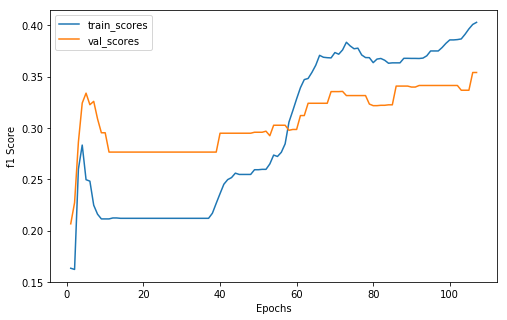

 31%|███       | 107/350 [15:04<34:37,  8.55s/it]

Cofusion Matrix For Val Set: 
-  --  -
2  34  7
2  44  5
1  14  5
-  --  -
Score This Epoch: 0.35415222915222916 Best Score: 0.35415222915222916
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 107 xxxxxxxxxxxxxx


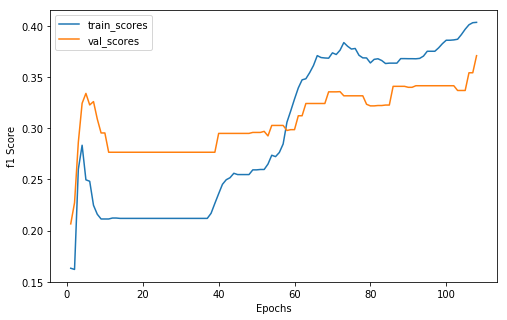

 31%|███       | 108/350 [15:12<34:18,  8.51s/it]

Cofusion Matrix For Val Set: 
-  --  -
3  33  7
2  44  5
1  14  5
-  --  -
Score This Epoch: 0.3708451344795727 Best Score: 0.3708451344795727
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 108 xxxxxxxxxxxxxx


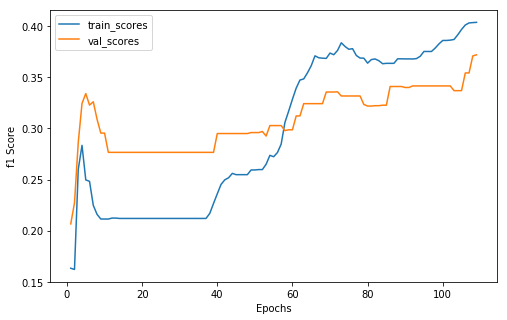

 31%|███       | 109/350 [15:21<34:05,  8.49s/it]

Cofusion Matrix For Val Set: 
-  --  -
3  33  7
2  44  5
2  13  5
-  --  -
Score This Epoch: 0.3718876547319996 Best Score: 0.3718876547319996
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 109 xxxxxxxxxxxxxx


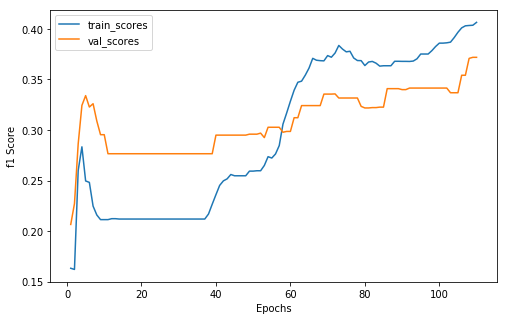

 31%|███▏      | 110/350 [15:29<33:50,  8.46s/it]

Cofusion Matrix For Val Set: 
-  --  -
3  33  7
2  44  5
2  13  5
-  --  -
Score This Epoch: 0.3718876547319996 Best Score: 0.3718876547319996
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 110 xxxxxxxxxxxxxx


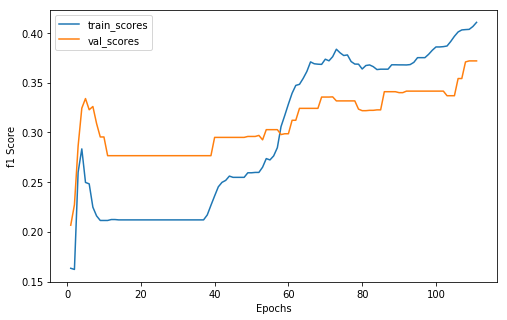

 32%|███▏      | 111/350 [15:38<33:34,  8.43s/it]

Cofusion Matrix For Val Set: 
-  --  -
3  33  7
2  44  5
2  13  5
-  --  -
Score This Epoch: 0.3718876547319996 Best Score: 0.3718876547319996
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 111 xxxxxxxxxxxxxx


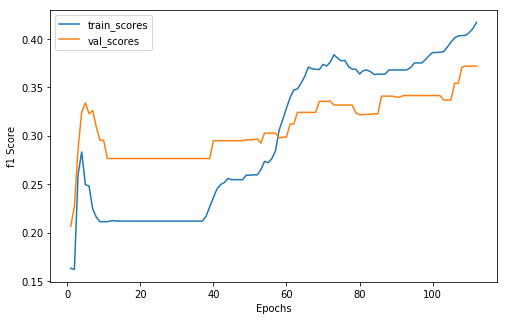

 32%|███▏      | 112/350 [15:46<33:23,  8.42s/it]

Cofusion Matrix For Val Set: 
-  --  -
3  33  7
2  44  5
2  13  5
-  --  -
Score This Epoch: 0.3718876547319996 Best Score: 0.3718876547319996
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 112 xxxxxxxxxxxxxx


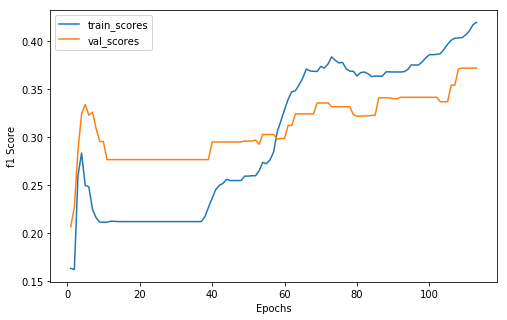

 32%|███▏      | 113/350 [15:54<33:16,  8.42s/it]

Cofusion Matrix For Val Set: 
-  --  -
3  33  7
2  44  5
2  13  5
-  --  -
Score This Epoch: 0.3718876547319996 Best Score: 0.3718876547319996
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 113 xxxxxxxxxxxxxx


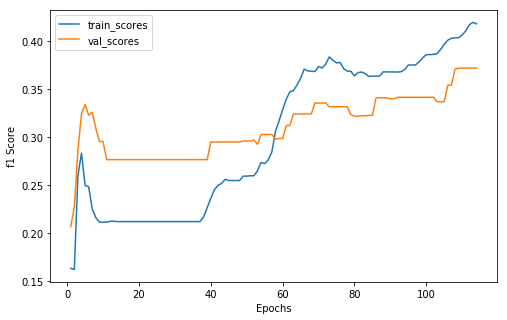

 33%|███▎      | 114/350 [16:03<33:07,  8.42s/it]

Cofusion Matrix For Val Set: 
-  --  -
3  33  7
2  44  5
2  13  5
-  --  -
Score This Epoch: 0.3718876547319996 Best Score: 0.3718876547319996
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 114 xxxxxxxxxxxxxx


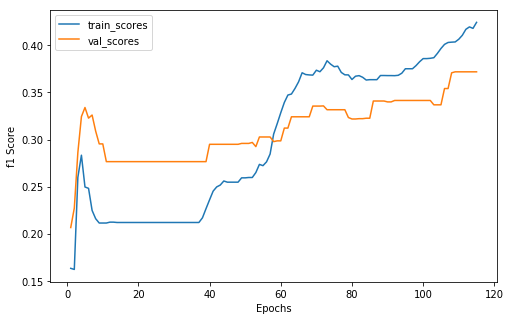

 33%|███▎      | 115/350 [16:11<32:59,  8.43s/it]

Cofusion Matrix For Val Set: 
-  --  -
3  33  7
2  44  5
2  13  5
-  --  -
Score This Epoch: 0.3718876547319996 Best Score: 0.3718876547319996
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 115 xxxxxxxxxxxxxx


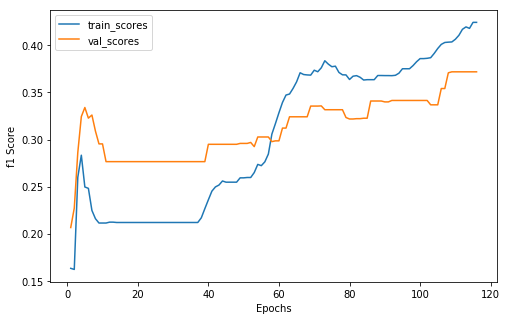

 33%|███▎      | 116/350 [16:20<32:49,  8.42s/it]

Cofusion Matrix For Val Set: 
-  --  -
3  33  7
2  44  5
2  13  5
-  --  -
Score This Epoch: 0.3718876547319996 Best Score: 0.3718876547319996
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 116 xxxxxxxxxxxxxx


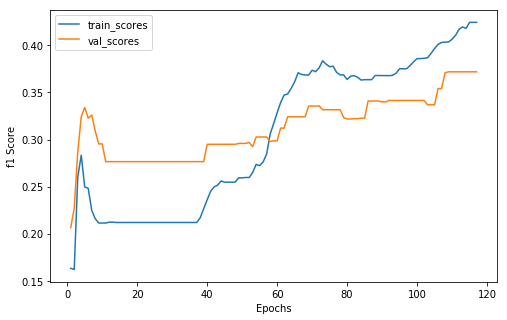

 33%|███▎      | 117/350 [16:28<32:38,  8.40s/it]

Cofusion Matrix For Val Set: 
-  --  -
3  33  7
2  44  5
2  13  5
-  --  -
Score This Epoch: 0.3718876547319996 Best Score: 0.3718876547319996
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 117 xxxxxxxxxxxxxx


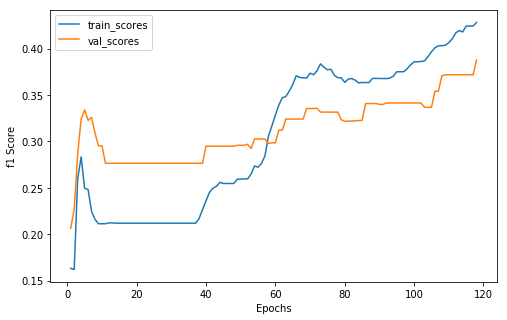

 34%|███▎      | 118/350 [16:36<32:34,  8.42s/it]

Cofusion Matrix For Val Set: 
-  --  -
4  32  7
2  44  5
2  13  5
-  --  -
Score This Epoch: 0.38778637106810476 Best Score: 0.38778637106810476
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 118 xxxxxxxxxxxxxx


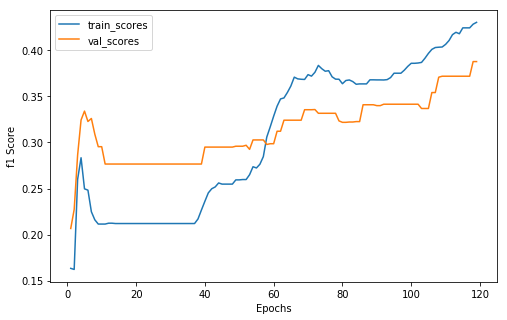

 34%|███▍      | 119/350 [16:45<32:41,  8.49s/it]

Cofusion Matrix For Val Set: 
-  --  -
4  32  7
2  44  5
2  13  5
-  --  -
Score This Epoch: 0.38778637106810476 Best Score: 0.38778637106810476
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 119 xxxxxxxxxxxxxx


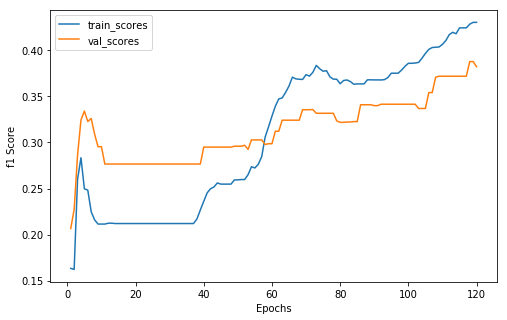

 34%|███▍      | 120/350 [16:54<32:29,  8.48s/it]

Cofusion Matrix For Val Set: 
-  --  -
4  32  7
3  43  5
2  13  5
-  --  -
Score This Epoch: 0.38223462153791576 Best Score: 0.38778637106810476
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 120 xxxxxxxxxxxxxx


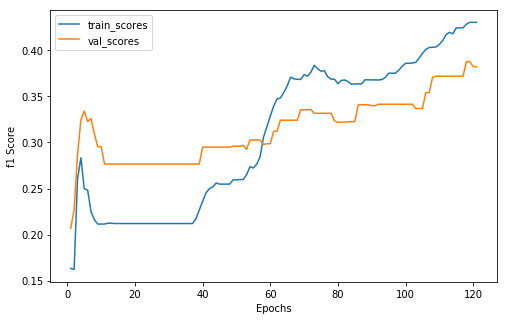

 35%|███▍      | 121/350 [17:02<32:16,  8.46s/it]

Cofusion Matrix For Val Set: 
-  --  -
4  32  7
3  43  5
2  13  5
-  --  -
Score This Epoch: 0.38223462153791576 Best Score: 0.38778637106810476
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 121 xxxxxxxxxxxxxx


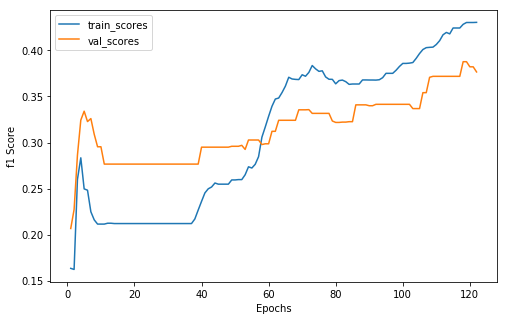

 35%|███▍      | 122/350 [17:10<32:07,  8.45s/it]

Cofusion Matrix For Val Set: 
-  --  -
4  32  7
4  42  5
2  13  5
-  --  -
Score This Epoch: 0.3766618395088668 Best Score: 0.38778637106810476
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 2, 2]
xxxxxxxxxxxxxx epoch: 122 xxxxxxxxxxxxxx


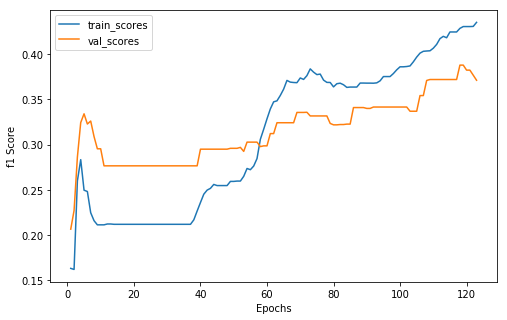

 35%|███▌      | 123/350 [17:19<31:59,  8.45s/it]

Cofusion Matrix For Val Set: 
-  --  -
4  32  7
5  41  5
2  13  5
-  --  -
Score This Epoch: 0.3710642387809759 Best Score: 0.38778637106810476
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 123 xxxxxxxxxxxxxx


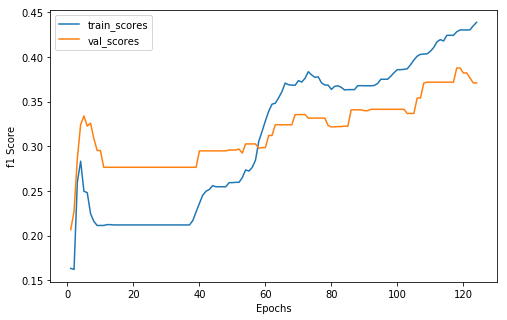

 35%|███▌      | 124/350 [17:27<31:49,  8.45s/it]

Cofusion Matrix For Val Set: 
-  --  -
4  32  7
5  41  5
2  13  5
-  --  -
Score This Epoch: 0.3710642387809759 Best Score: 0.38778637106810476
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 124 xxxxxxxxxxxxxx


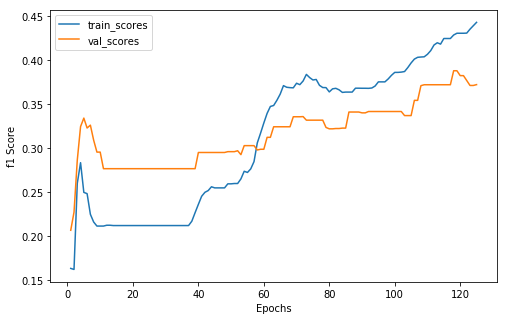

 36%|███▌      | 125/350 [17:36<31:39,  8.44s/it]

Cofusion Matrix For Val Set: 
-  --  -
4  32  7
5  41  5
3  12  5
-  --  -
Score This Epoch: 0.37201711280658645 Best Score: 0.38778637106810476
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 125 xxxxxxxxxxxxxx


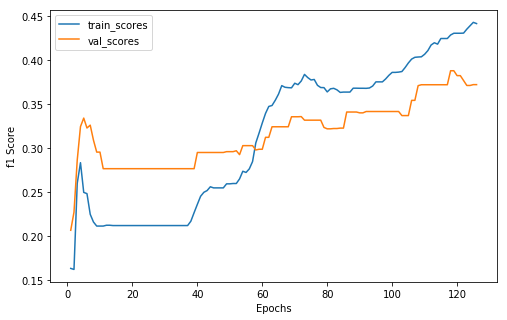

 36%|███▌      | 126/350 [17:44<31:24,  8.41s/it]

Cofusion Matrix For Val Set: 
-  --  -
4  32  7
5  41  5
3  12  5
-  --  -
Score This Epoch: 0.37201711280658645 Best Score: 0.38778637106810476
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 126 xxxxxxxxxxxxxx


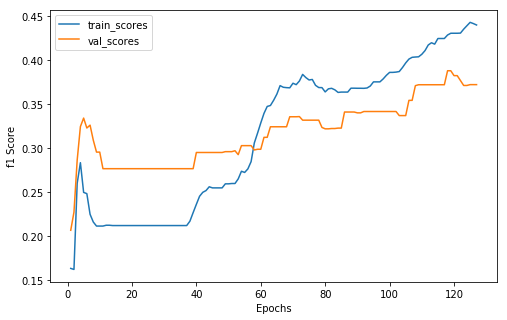

 36%|███▋      | 127/350 [17:52<31:12,  8.40s/it]

Cofusion Matrix For Val Set: 
-  --  -
4  32  7
5  41  5
3  12  5
-  --  -
Score This Epoch: 0.37201711280658645 Best Score: 0.38778637106810476
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 127 xxxxxxxxxxxxxx


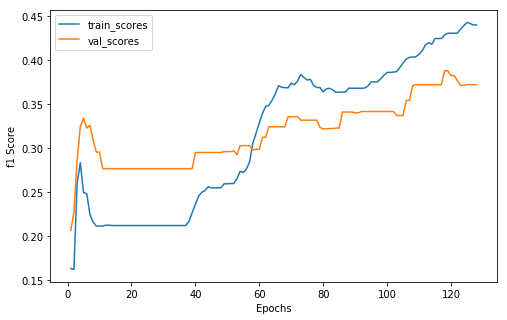

 37%|███▋      | 128/350 [18:01<31:03,  8.40s/it]

Cofusion Matrix For Val Set: 
-  --  -
4  32  7
5  41  5
3  12  5
-  --  -
Score This Epoch: 0.37201711280658645 Best Score: 0.38778637106810476
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 128 xxxxxxxxxxxxxx


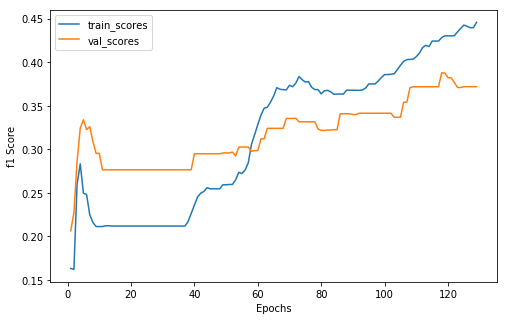

 37%|███▋      | 129/350 [18:09<30:58,  8.41s/it]

Cofusion Matrix For Val Set: 
-  --  -
4  32  7
5  41  5
3  12  5
-  --  -
Score This Epoch: 0.37201711280658645 Best Score: 0.38778637106810476
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 129 xxxxxxxxxxxxxx


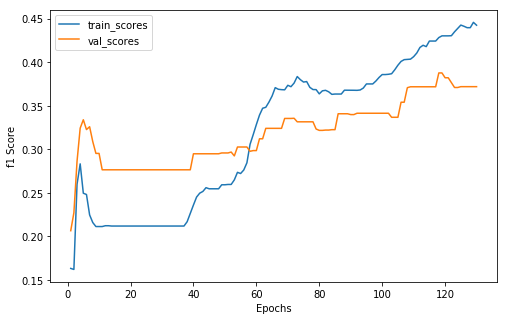

 37%|███▋      | 130/350 [18:18<30:51,  8.42s/it]

Cofusion Matrix For Val Set: 
-  --  -
4  32  7
5  41  5
3  12  5
-  --  -
Score This Epoch: 0.37201711280658645 Best Score: 0.38778637106810476
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 130 xxxxxxxxxxxxxx


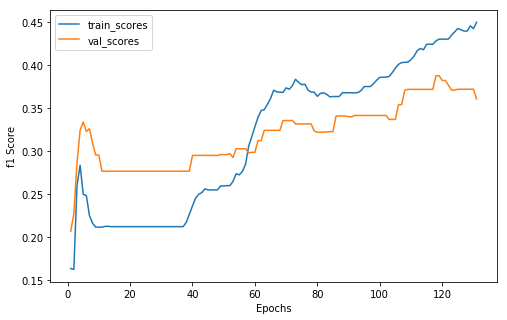

 37%|███▋      | 131/350 [18:26<30:42,  8.41s/it]

Cofusion Matrix For Val Set: 
-  --  -
4  32  7
7  39  5
3  12  5
-  --  -
Score This Epoch: 0.36076368674458553 Best Score: 0.38778637106810476
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 131 xxxxxxxxxxxxxx


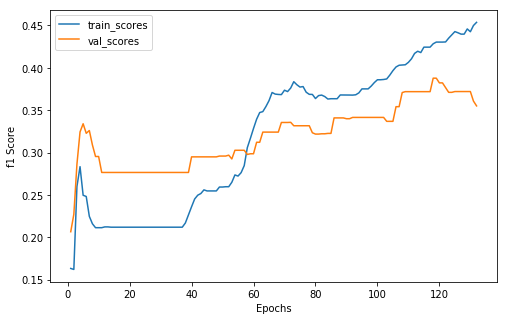

 38%|███▊      | 132/350 [18:34<30:28,  8.39s/it]

Cofusion Matrix For Val Set: 
-  --  -
4  32  7
8  38  5
3  12  5
-  --  -
Score This Epoch: 0.3550815529036945 Best Score: 0.38778637106810476
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 132 xxxxxxxxxxxxxx


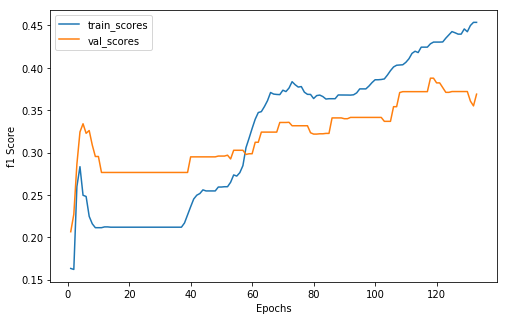

 38%|███▊      | 133/350 [18:43<30:19,  8.39s/it]

Cofusion Matrix For Val Set: 
-  --  -
5  31  7
8  38  5
3  12  5
-  --  -
Score This Epoch: 0.3689226084408957 Best Score: 0.38778637106810476
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 133 xxxxxxxxxxxxxx


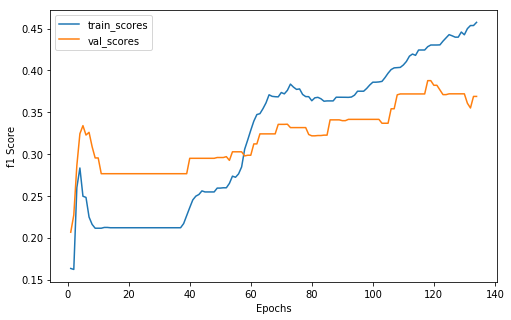

 38%|███▊      | 134/350 [18:51<30:12,  8.39s/it]

Cofusion Matrix For Val Set: 
-  --  -
5  31  7
8  38  5
3  12  5
-  --  -
Score This Epoch: 0.3689226084408957 Best Score: 0.38778637106810476
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 134 xxxxxxxxxxxxxx


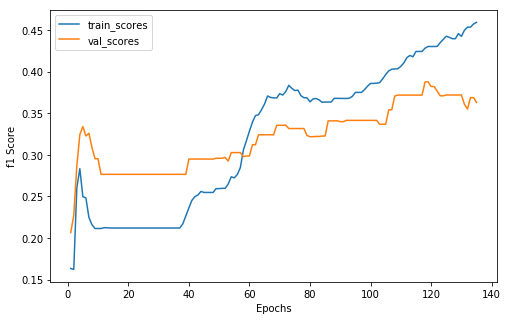

 39%|███▊      | 135/350 [19:00<30:03,  8.39s/it]

Cofusion Matrix For Val Set: 
-  --  -
5  31  7
9  37  5
3  12  5
-  --  -
Score This Epoch: 0.3629932664685578 Best Score: 0.38778637106810476
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 135 xxxxxxxxxxxxxx


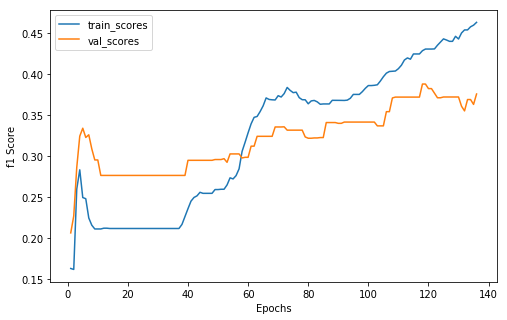

 39%|███▉      | 136/350 [19:08<29:57,  8.40s/it]

Cofusion Matrix For Val Set: 
-  --  -
6  31  6
9  37  5
3  12  5
-  --  -
Score This Epoch: 0.37564677416089204 Best Score: 0.38778637106810476
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 136 xxxxxxxxxxxxxx


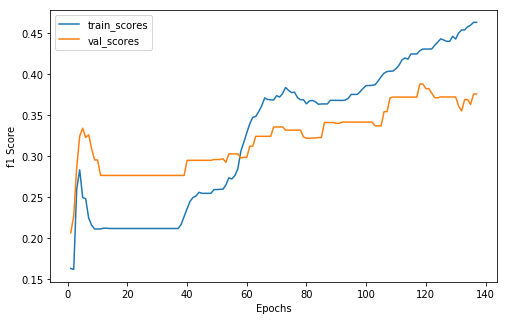

 39%|███▉      | 137/350 [19:17<29:54,  8.42s/it]

Cofusion Matrix For Val Set: 
-  --  -
6  31  6
9  37  5
3  12  5
-  --  -
Score This Epoch: 0.37564677416089204 Best Score: 0.38778637106810476
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 137 xxxxxxxxxxxxxx


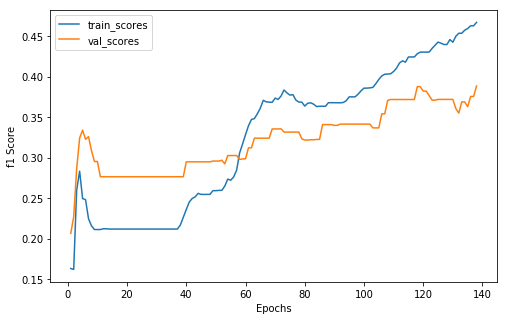

 39%|███▉      | 138/350 [19:25<29:45,  8.42s/it]

Cofusion Matrix For Val Set: 
-  --  -
7  30  6
9  37  5
3  12  5
-  --  -
Score This Epoch: 0.3885614228568388 Best Score: 0.3885614228568388
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 138 xxxxxxxxxxxxxx


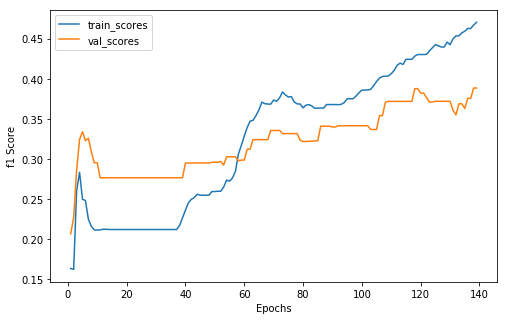

 40%|███▉      | 139/350 [19:33<29:38,  8.43s/it]

Cofusion Matrix For Val Set: 
-  --  -
7  30  6
9  37  5
3  12  5
-  --  -
Score This Epoch: 0.3885614228568388 Best Score: 0.3885614228568388
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 139 xxxxxxxxxxxxxx


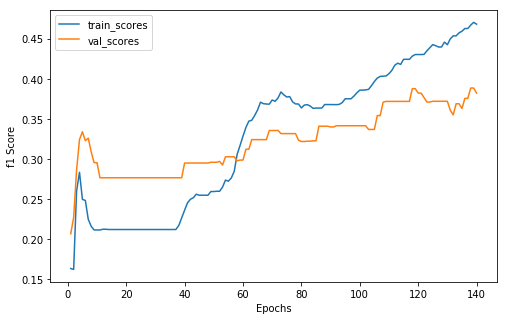

 40%|████      | 140/350 [19:42<29:28,  8.42s/it]

Cofusion Matrix For Val Set: 
--  --  -
 7  30  6
10  36  5
 3  12  5
--  --  -
Score This Epoch: 0.38224760868579727 Best Score: 0.3885614228568388
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 140 xxxxxxxxxxxxxx


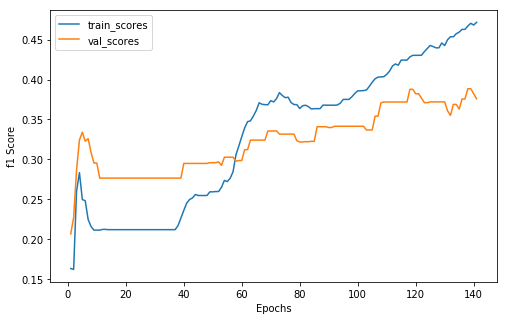

 40%|████      | 141/350 [19:50<29:24,  8.44s/it]

Cofusion Matrix For Val Set: 
--  --  -
 7  30  6
11  35  5
 3  12  5
--  --  -
Score This Epoch: 0.3758985136452242 Best Score: 0.3885614228568388
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 141 xxxxxxxxxxxxxx


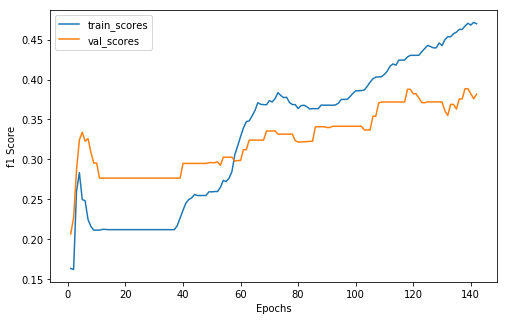

 41%|████      | 142/350 [19:59<29:22,  8.47s/it]

Cofusion Matrix For Val Set: 
--  --  -
 8  29  6
12  34  5
 3  12  5
--  --  -
Score This Epoch: 0.38161059213690796 Best Score: 0.3885614228568388
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 142 xxxxxxxxxxxxxx


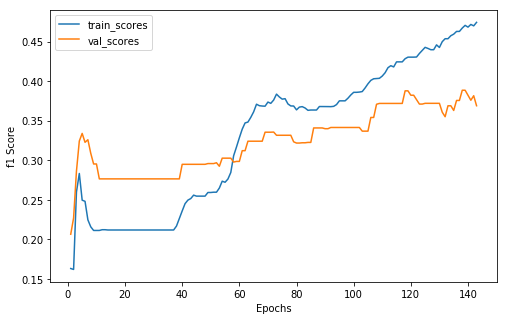

 41%|████      | 143/350 [20:08<29:28,  8.54s/it]

Cofusion Matrix For Val Set: 
--  --  -
 8  29  6
14  32  5
 4  11  5
--  --  -
Score This Epoch: 0.36897504749265647 Best Score: 0.3885614228568388
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 143 xxxxxxxxxxxxxx


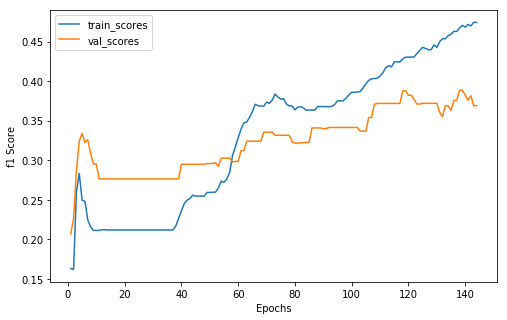

 41%|████      | 144/350 [20:16<29:22,  8.55s/it]

Cofusion Matrix For Val Set: 
--  --  -
 8  29  6
14  32  5
 4  11  5
--  --  -
Score This Epoch: 0.36897504749265647 Best Score: 0.3885614228568388
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 144 xxxxxxxxxxxxxx


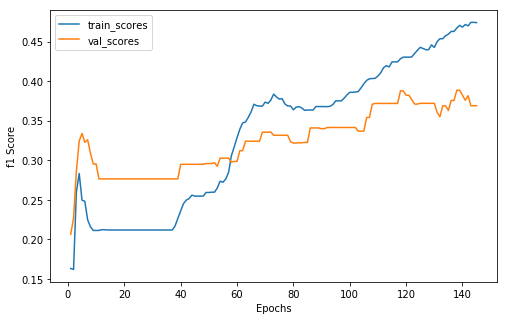

 41%|████▏     | 145/350 [20:25<29:09,  8.53s/it]

Cofusion Matrix For Val Set: 
--  --  -
 8  29  6
14  32  5
 4  11  5
--  --  -
Score This Epoch: 0.36897504749265647 Best Score: 0.3885614228568388
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 145 xxxxxxxxxxxxxx


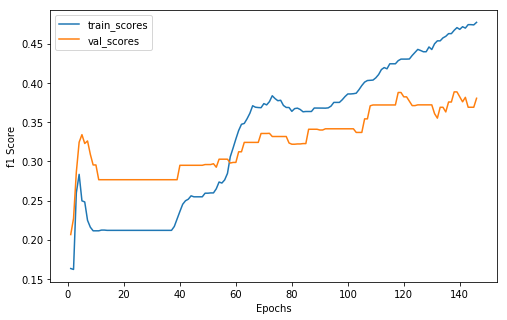

 42%|████▏     | 146/350 [20:33<28:55,  8.51s/it]

Cofusion Matrix For Val Set: 
--  --  -
 9  28  6
14  32  5
 4  11  5
--  --  -
Score This Epoch: 0.38041049801187854 Best Score: 0.3885614228568388
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 146 xxxxxxxxxxxxxx


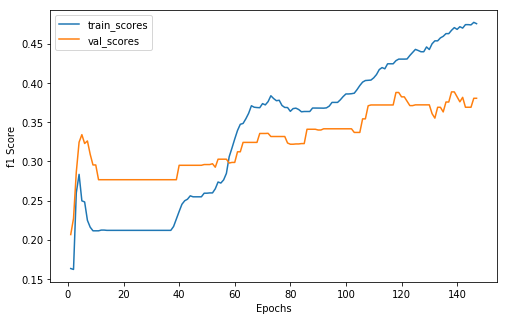

 42%|████▏     | 147/350 [20:41<28:42,  8.48s/it]

Cofusion Matrix For Val Set: 
--  --  -
 9  28  6
14  32  5
 4  11  5
--  --  -
Score This Epoch: 0.38041049801187854 Best Score: 0.3885614228568388
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 147 xxxxxxxxxxxxxx


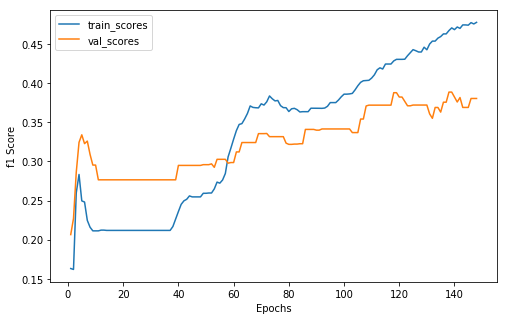

 42%|████▏     | 148/350 [20:50<28:31,  8.47s/it]

Cofusion Matrix For Val Set: 
--  --  -
 9  28  6
14  32  5
 4  11  5
--  --  -
Score This Epoch: 0.38041049801187854 Best Score: 0.3885614228568388
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 148 xxxxxxxxxxxxxx


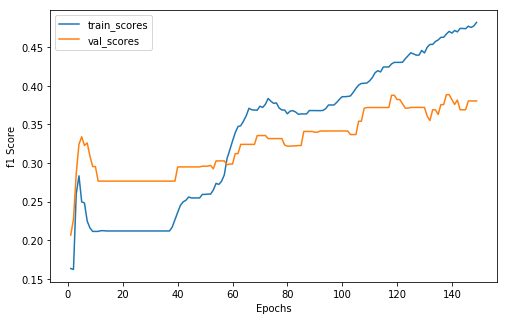

 43%|████▎     | 149/350 [20:58<28:24,  8.48s/it]

Cofusion Matrix For Val Set: 
--  --  -
 9  28  6
14  32  5
 4  11  5
--  --  -
Score This Epoch: 0.38041049801187854 Best Score: 0.3885614228568388
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 149 xxxxxxxxxxxxxx


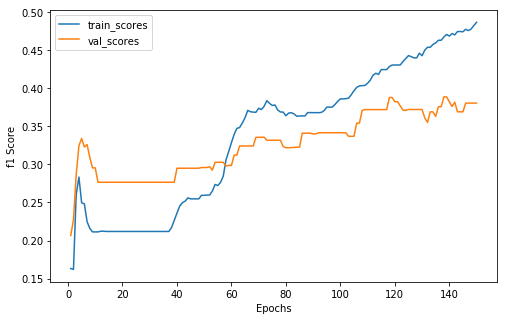

 43%|████▎     | 150/350 [21:07<28:15,  8.48s/it]

Cofusion Matrix For Val Set: 
--  --  -
 9  28  6
14  32  5
 4  11  5
--  --  -
Score This Epoch: 0.38041049801187854 Best Score: 0.3885614228568388
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 150 xxxxxxxxxxxxxx


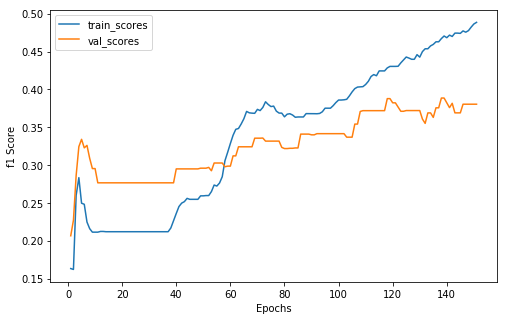

 43%|████▎     | 151/350 [21:15<28:07,  8.48s/it]

Cofusion Matrix For Val Set: 
--  --  -
 9  28  6
14  32  5
 4  11  5
--  --  -
Score This Epoch: 0.38041049801187854 Best Score: 0.3885614228568388
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 151 xxxxxxxxxxxxxx


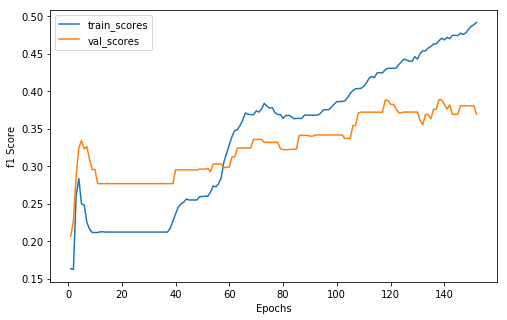

 43%|████▎     | 152/350 [21:24<27:56,  8.47s/it]

Cofusion Matrix For Val Set: 
--  --  -
 9  29  5
14  32  5
 4  12  4
--  --  -
Score This Epoch: 0.36917198118636246 Best Score: 0.3885614228568388
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 152 xxxxxxxxxxxxxx


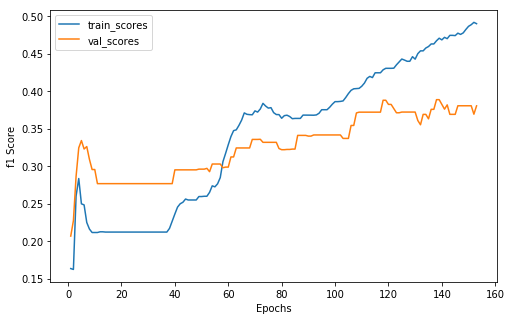

 44%|████▎     | 153/350 [21:32<27:46,  8.46s/it]

Cofusion Matrix For Val Set: 
--  --  -
10  28  5
14  32  5
 4  12  4
--  --  -
Score This Epoch: 0.3803082787292356 Best Score: 0.3885614228568388
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 153 xxxxxxxxxxxxxx


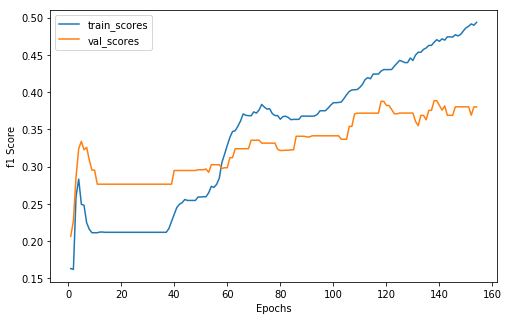

 44%|████▍     | 154/350 [21:41<27:39,  8.47s/it]

Cofusion Matrix For Val Set: 
--  --  -
10  28  5
14  32  5
 4  12  4
--  --  -
Score This Epoch: 0.3803082787292356 Best Score: 0.3885614228568388
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 154 xxxxxxxxxxxxxx


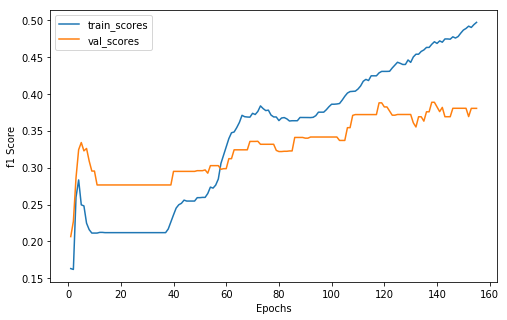

 44%|████▍     | 155/350 [21:49<27:31,  8.47s/it]

Cofusion Matrix For Val Set: 
--  --  -
10  28  5
14  32  5
 4  12  4
--  --  -
Score This Epoch: 0.3803082787292356 Best Score: 0.3885614228568388
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 155 xxxxxxxxxxxxxx


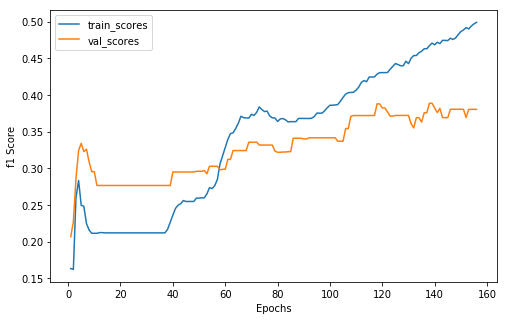

 45%|████▍     | 156/350 [21:58<27:22,  8.47s/it]

Cofusion Matrix For Val Set: 
--  --  -
10  28  5
14  32  5
 4  12  4
--  --  -
Score This Epoch: 0.3803082787292356 Best Score: 0.3885614228568388
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 156 xxxxxxxxxxxxxx


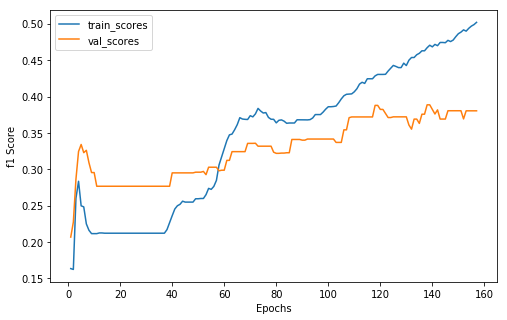

 45%|████▍     | 157/350 [22:06<27:17,  8.48s/it]

Cofusion Matrix For Val Set: 
--  --  -
10  28  5
14  32  5
 4  12  4
--  --  -
Score This Epoch: 0.3803082787292356 Best Score: 0.3885614228568388
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 157 xxxxxxxxxxxxxx


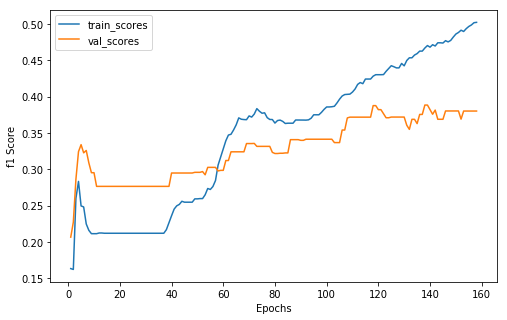

 45%|████▌     | 158/350 [22:15<27:08,  8.48s/it]

Cofusion Matrix For Val Set: 
--  --  -
10  28  5
14  32  5
 4  12  4
--  --  -
Score This Epoch: 0.3803082787292356 Best Score: 0.3885614228568388
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 158 xxxxxxxxxxxxxx


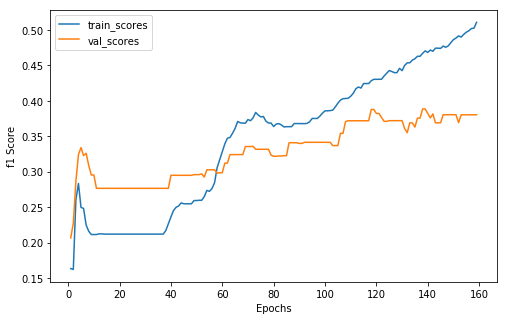

 45%|████▌     | 159/350 [22:23<26:58,  8.47s/it]

Cofusion Matrix For Val Set: 
--  --  -
10  28  5
14  32  5
 4  12  4
--  --  -
Score This Epoch: 0.3803082787292356 Best Score: 0.3885614228568388
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 159 xxxxxxxxxxxxxx


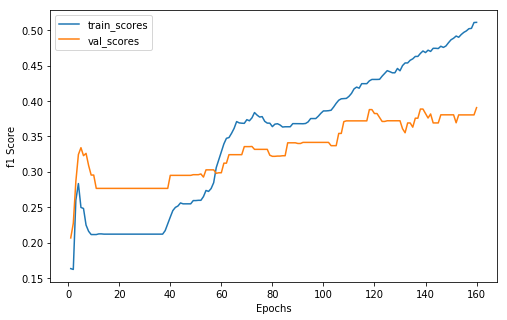

 46%|████▌     | 160/350 [22:33<27:49,  8.79s/it]

Cofusion Matrix For Val Set: 
--  --  -
11  28  4
14  32  5
 4  12  4
--  --  -
Score This Epoch: 0.39056104476515263 Best Score: 0.39056104476515263
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 160 xxxxxxxxxxxxxx


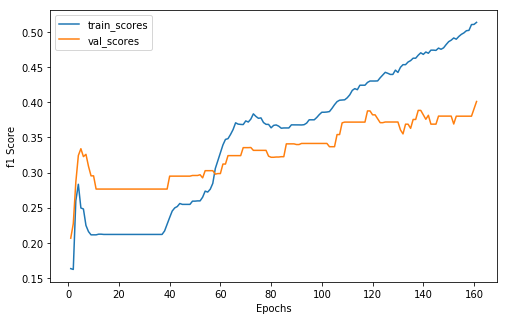

 46%|████▌     | 161/350 [22:41<27:20,  8.68s/it]

Cofusion Matrix For Val Set: 
--  --  -
12  27  4
14  32  5
 4  12  4
--  --  -
Score This Epoch: 0.4012242939518461 Best Score: 0.4012242939518461
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 161 xxxxxxxxxxxxxx


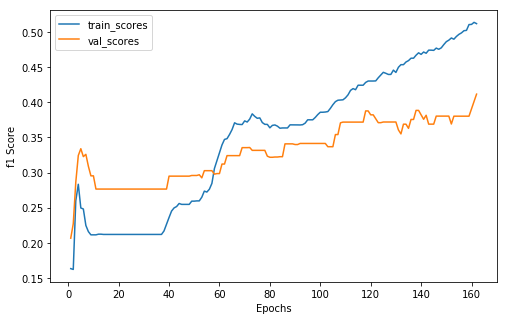

 46%|████▋     | 162/350 [22:50<26:57,  8.61s/it]

Cofusion Matrix For Val Set: 
--  --  -
13  26  4
14  32  5
 4  12  4
--  --  -
Score This Epoch: 0.4116824523523088 Best Score: 0.4116824523523088
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 162 xxxxxxxxxxxxxx


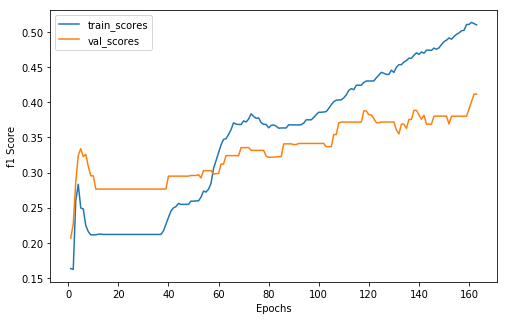

 47%|████▋     | 163/350 [22:58<26:39,  8.55s/it]

Cofusion Matrix For Val Set: 
--  --  -
13  26  4
14  32  5
 4  12  4
--  --  -
Score This Epoch: 0.4116824523523088 Best Score: 0.4116824523523088
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 163 xxxxxxxxxxxxxx


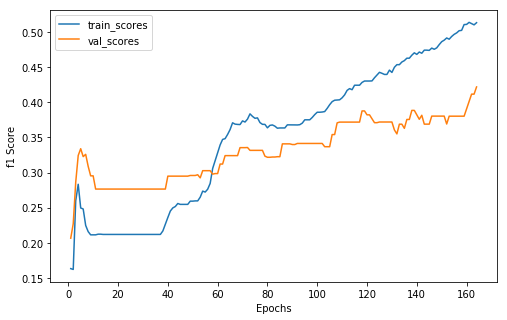

 47%|████▋     | 164/350 [23:06<26:24,  8.52s/it]

Cofusion Matrix For Val Set: 
--  --  -
14  25  4
14  32  5
 4  12  4
--  --  -
Score This Epoch: 0.4219457735247209 Best Score: 0.4219457735247209
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 164 xxxxxxxxxxxxxx


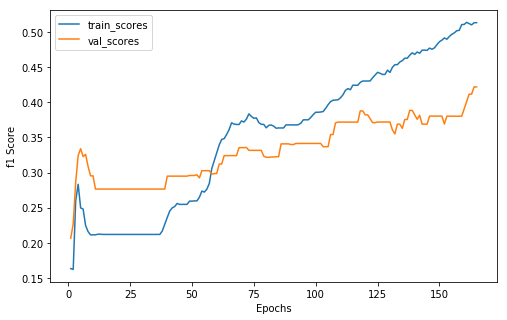

 47%|████▋     | 165/350 [23:15<26:12,  8.50s/it]

Cofusion Matrix For Val Set: 
--  --  -
14  25  4
14  32  5
 4  12  4
--  --  -
Score This Epoch: 0.4219457735247209 Best Score: 0.4219457735247209
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 165 xxxxxxxxxxxxxx


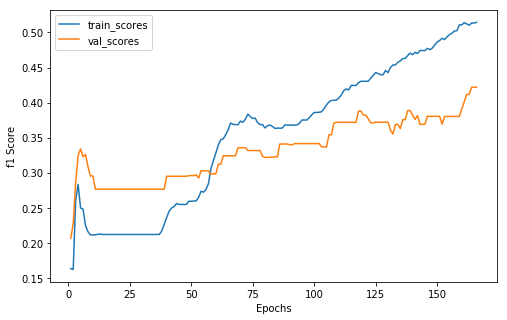

 47%|████▋     | 166/350 [23:23<25:58,  8.47s/it]

Cofusion Matrix For Val Set: 
--  --  -
14  25  4
14  32  5
 4  12  4
--  --  -
Score This Epoch: 0.4219457735247209 Best Score: 0.4219457735247209
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 166 xxxxxxxxxxxxxx


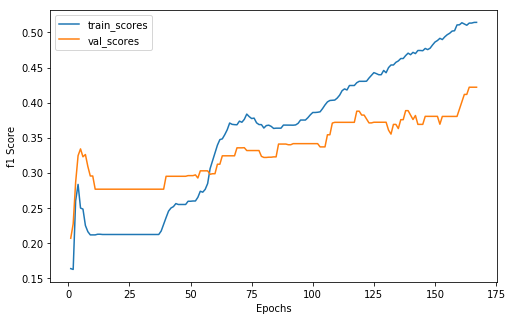

 48%|████▊     | 167/350 [23:32<25:50,  8.47s/it]

Cofusion Matrix For Val Set: 
--  --  -
14  25  4
14  32  5
 4  12  4
--  --  -
Score This Epoch: 0.4219457735247209 Best Score: 0.4219457735247209
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 167 xxxxxxxxxxxxxx


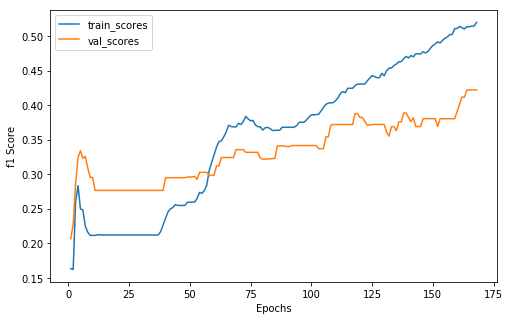

 48%|████▊     | 168/350 [23:40<25:38,  8.45s/it]

Cofusion Matrix For Val Set: 
--  --  -
14  25  4
14  32  5
 5  11  4
--  --  -
Score This Epoch: 0.4220979082474927 Best Score: 0.4220979082474927
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 168 xxxxxxxxxxxxxx


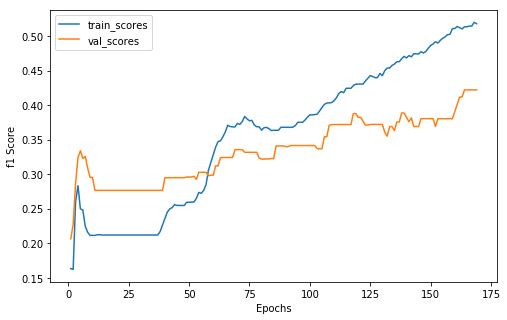

 48%|████▊     | 169/350 [23:49<25:29,  8.45s/it]

Cofusion Matrix For Val Set: 
--  --  -
14  25  4
14  32  5
 5  11  4
--  --  -
Score This Epoch: 0.4220979082474927 Best Score: 0.4220979082474927
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 169 xxxxxxxxxxxxxx


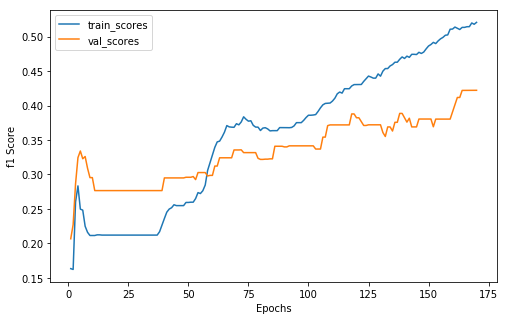

 49%|████▊     | 170/350 [23:57<25:18,  8.43s/it]

Cofusion Matrix For Val Set: 
--  --  -
14  25  4
14  32  5
 5  11  4
--  --  -
Score This Epoch: 0.4220979082474927 Best Score: 0.4220979082474927
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 170 xxxxxxxxxxxxxx


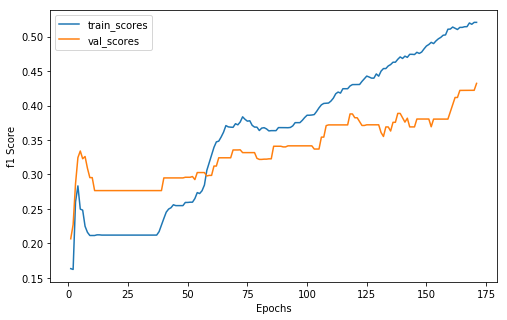

 49%|████▉     | 171/350 [24:06<25:14,  8.46s/it]

Cofusion Matrix For Val Set: 
--  --  -
15  24  4
14  32  5
 5  11  4
--  --  -
Score This Epoch: 0.4321293732533697 Best Score: 0.4321293732533697
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 171 xxxxxxxxxxxxxx


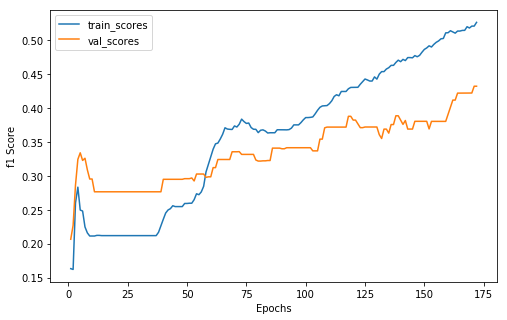

 49%|████▉     | 172/350 [24:14<25:20,  8.54s/it]

Cofusion Matrix For Val Set: 
--  --  -
15  24  4
14  32  5
 5  11  4
--  --  -
Score This Epoch: 0.4321293732533697 Best Score: 0.4321293732533697
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 172 xxxxxxxxxxxxxx


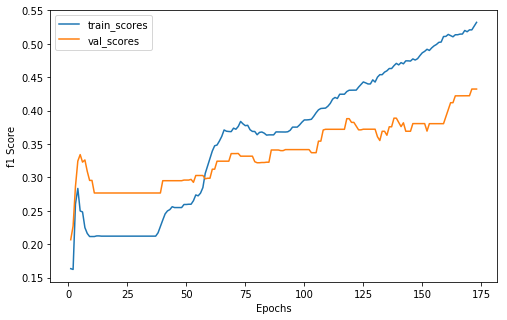

 49%|████▉     | 173/350 [24:23<25:12,  8.54s/it]

Cofusion Matrix For Val Set: 
--  --  -
15  24  4
14  32  5
 5  11  4
--  --  -
Score This Epoch: 0.4321293732533697 Best Score: 0.4321293732533697
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 173 xxxxxxxxxxxxxx


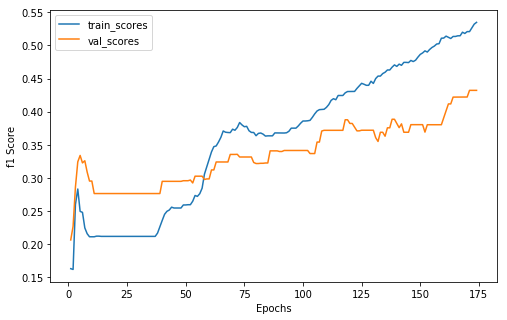

 50%|████▉     | 174/350 [24:31<25:01,  8.53s/it]

Cofusion Matrix For Val Set: 
--  --  -
15  24  4
14  32  5
 5  11  4
--  --  -
Score This Epoch: 0.4321293732533697 Best Score: 0.4321293732533697
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 174 xxxxxxxxxxxxxx


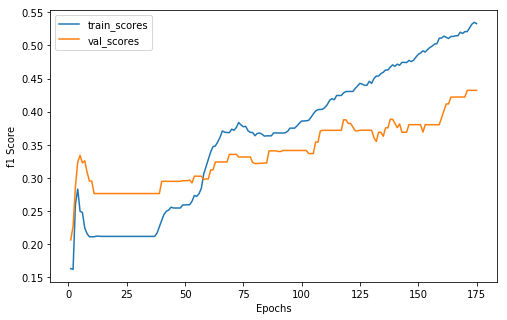

 50%|█████     | 175/350 [24:40<24:46,  8.49s/it]

Cofusion Matrix For Val Set: 
--  --  -
15  24  4
14  32  5
 5  11  4
--  --  -
Score This Epoch: 0.4321293732533697 Best Score: 0.4321293732533697
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 175 xxxxxxxxxxxxxx


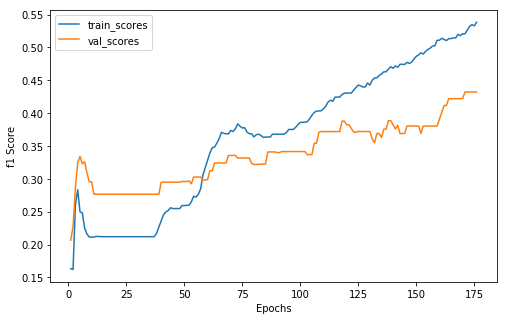

 50%|█████     | 176/350 [24:48<24:37,  8.49s/it]

Cofusion Matrix For Val Set: 
--  --  -
15  24  4
14  32  5
 5  11  4
--  --  -
Score This Epoch: 0.4321293732533697 Best Score: 0.4321293732533697
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 176 xxxxxxxxxxxxxx


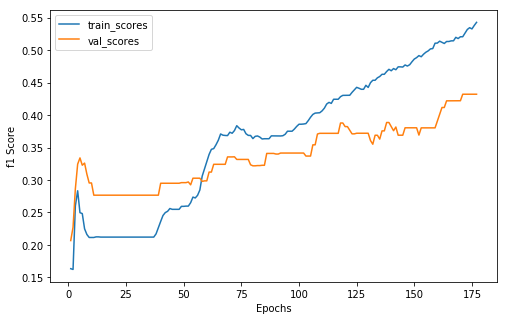

 51%|█████     | 177/350 [24:57<24:25,  8.47s/it]

Cofusion Matrix For Val Set: 
--  --  -
15  24  4
14  32  5
 5  11  4
--  --  -
Score This Epoch: 0.4321293732533697 Best Score: 0.4321293732533697
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 177 xxxxxxxxxxxxxx


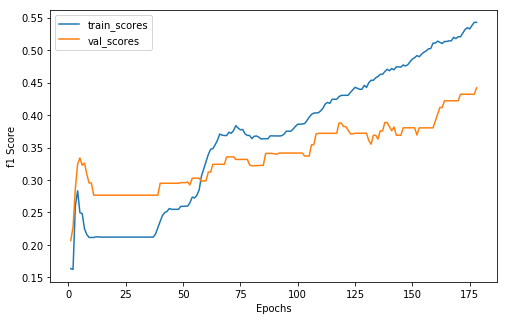

 51%|█████     | 178/350 [25:05<24:18,  8.48s/it]

Cofusion Matrix For Val Set: 
--  --  -
16  23  4
14  32  5
 5  11  4
--  --  -
Score This Epoch: 0.4419907577802315 Best Score: 0.4419907577802315
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 178 xxxxxxxxxxxxxx


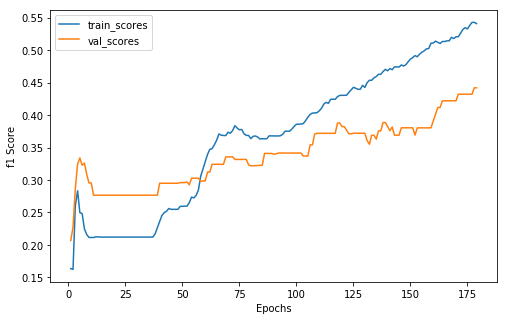

 51%|█████     | 179/350 [25:14<24:08,  8.47s/it]

Cofusion Matrix For Val Set: 
--  --  -
16  23  4
14  32  5
 5  11  4
--  --  -
Score This Epoch: 0.4419907577802315 Best Score: 0.4419907577802315
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 179 xxxxxxxxxxxxxx


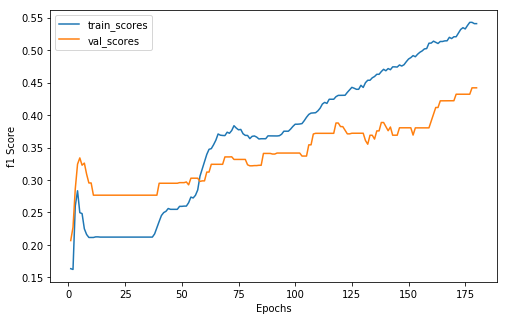

 51%|█████▏    | 180/350 [25:22<24:03,  8.49s/it]

Cofusion Matrix For Val Set: 
--  --  -
16  23  4
14  32  5
 5  11  4
--  --  -
Score This Epoch: 0.4419907577802315 Best Score: 0.4419907577802315
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 180 xxxxxxxxxxxxxx


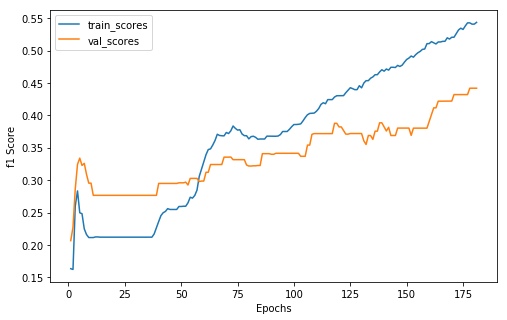

 52%|█████▏    | 181/350 [25:31<23:51,  8.47s/it]

Cofusion Matrix For Val Set: 
--  --  -
16  23  4
14  32  5
 5  11  4
--  --  -
Score This Epoch: 0.4419907577802315 Best Score: 0.4419907577802315
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 181 xxxxxxxxxxxxxx


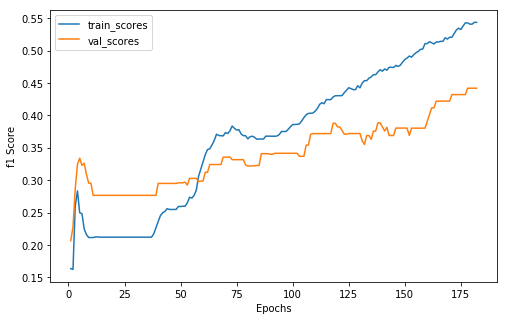

 52%|█████▏    | 182/350 [25:39<23:41,  8.46s/it]

Cofusion Matrix For Val Set: 
--  --  -
16  23  4
14  32  5
 5  11  4
--  --  -
Score This Epoch: 0.4419907577802315 Best Score: 0.4419907577802315
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 182 xxxxxxxxxxxxxx


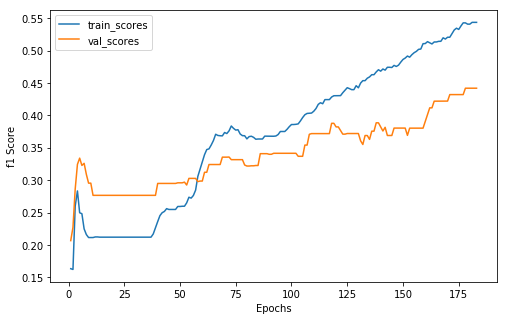

 52%|█████▏    | 183/350 [25:47<23:34,  8.47s/it]

Cofusion Matrix For Val Set: 
--  --  -
16  23  4
14  32  5
 5  11  4
--  --  -
Score This Epoch: 0.4419907577802315 Best Score: 0.4419907577802315
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 183 xxxxxxxxxxxxxx


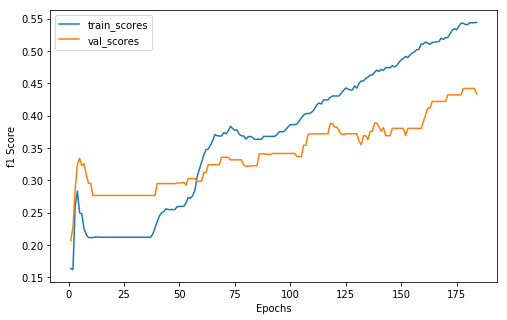

 53%|█████▎    | 184/350 [25:56<23:27,  8.48s/it]

Cofusion Matrix For Val Set: 
--  --  -
16  23  4
16  31  4
 5  11  4
--  --  -
Score This Epoch: 0.4338475499092559 Best Score: 0.4419907577802315
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 184 xxxxxxxxxxxxxx


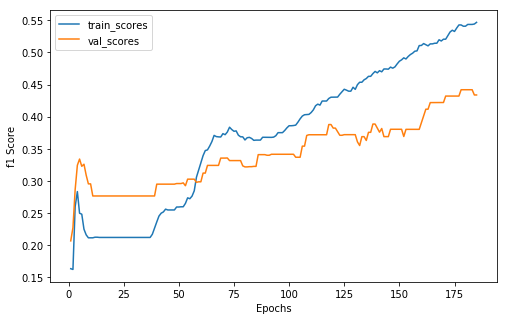

 53%|█████▎    | 185/350 [26:04<23:18,  8.48s/it]

Cofusion Matrix For Val Set: 
--  --  -
16  23  4
16  31  4
 5  11  4
--  --  -
Score This Epoch: 0.4338475499092559 Best Score: 0.4419907577802315
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 185 xxxxxxxxxxxxxx


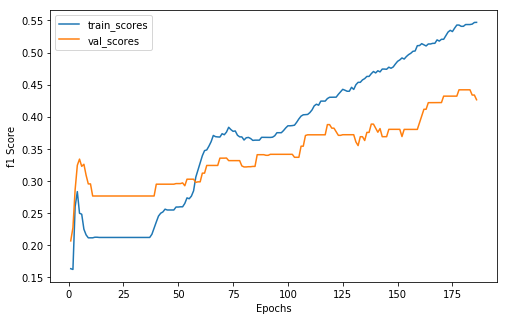

 53%|█████▎    | 186/350 [26:13<23:11,  8.48s/it]

Cofusion Matrix For Val Set: 
--  --  -
16  23  4
17  30  4
 6  10  4
--  --  -
Score This Epoch: 0.426513974281017 Best Score: 0.4419907577802315
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 186 xxxxxxxxxxxxxx


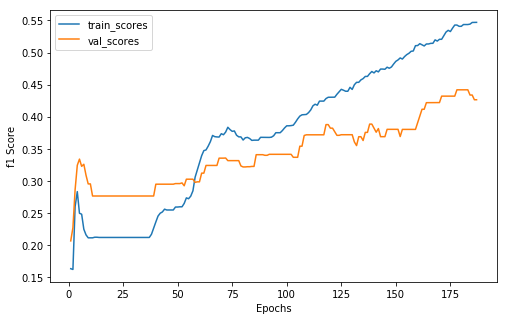

 53%|█████▎    | 187/350 [26:21<23:02,  8.48s/it]

Cofusion Matrix For Val Set: 
--  --  -
16  23  4
17  30  4
 6  10  4
--  --  -
Score This Epoch: 0.426513974281017 Best Score: 0.4419907577802315
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 187 xxxxxxxxxxxxxx


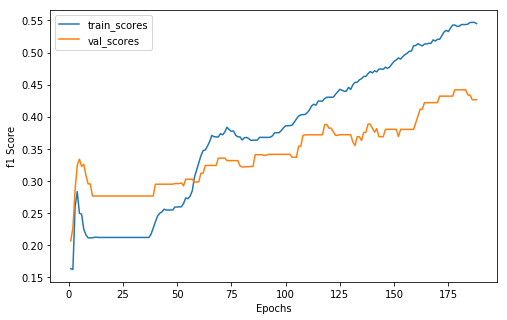

 54%|█████▎    | 188/350 [26:30<22:52,  8.47s/it]

Cofusion Matrix For Val Set: 
--  --  -
16  23  4
17  30  4
 6  10  4
--  --  -
Score This Epoch: 0.426513974281017 Best Score: 0.4419907577802315
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 188 xxxxxxxxxxxxxx


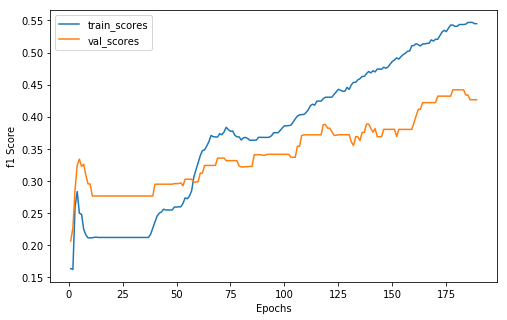

 54%|█████▍    | 189/350 [26:38<22:39,  8.45s/it]

Cofusion Matrix For Val Set: 
--  --  -
16  23  4
17  30  4
 6  10  4
--  --  -
Score This Epoch: 0.426513974281017 Best Score: 0.4419907577802315
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 189 xxxxxxxxxxxxxx


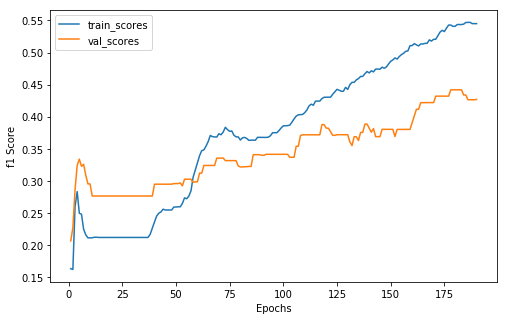

 54%|█████▍    | 190/350 [26:47<22:28,  8.43s/it]

Cofusion Matrix For Val Set: 
--  --  -
16  23  4
16  30  5
 6  10  4
--  --  -
Score This Epoch: 0.4270021441458807 Best Score: 0.4419907577802315
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 190 xxxxxxxxxxxxxx


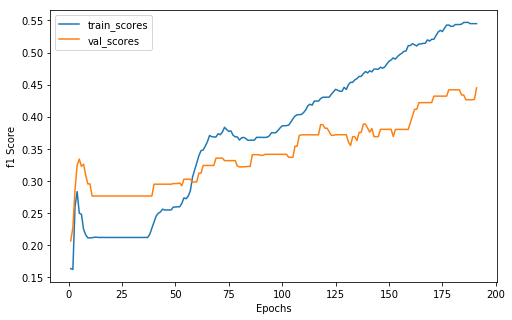

 55%|█████▍    | 191/350 [26:55<22:23,  8.45s/it]

Cofusion Matrix For Val Set: 
--  --  -
18  22  3
16  30  5
 6  10  4
--  --  -
Score This Epoch: 0.44500217918717255 Best Score: 0.44500217918717255
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 191 xxxxxxxxxxxxxx


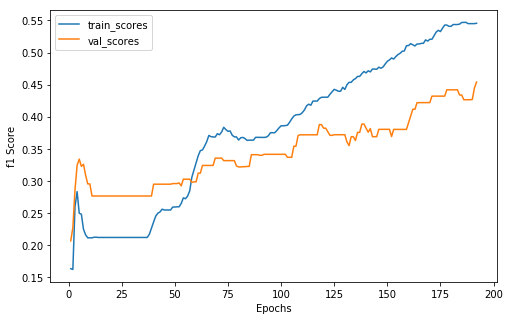

 55%|█████▍    | 192/350 [27:04<22:14,  8.45s/it]

Cofusion Matrix For Val Set: 
--  --  -
19  21  3
16  30  5
 6  10  4
--  --  -
Score This Epoch: 0.45415622389306604 Best Score: 0.45415622389306604
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 192 xxxxxxxxxxxxxx


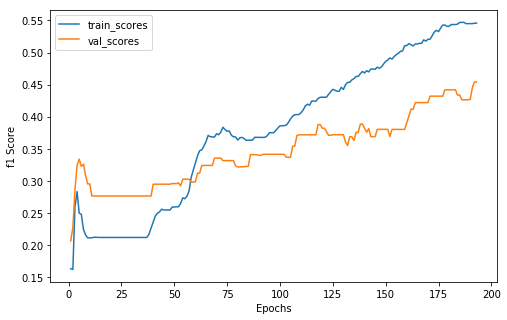

 55%|█████▌    | 193/350 [27:12<22:06,  8.45s/it]

Cofusion Matrix For Val Set: 
--  --  -
19  21  3
16  30  5
 6  10  4
--  --  -
Score This Epoch: 0.45415622389306604 Best Score: 0.45415622389306604
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 193 xxxxxxxxxxxxxx


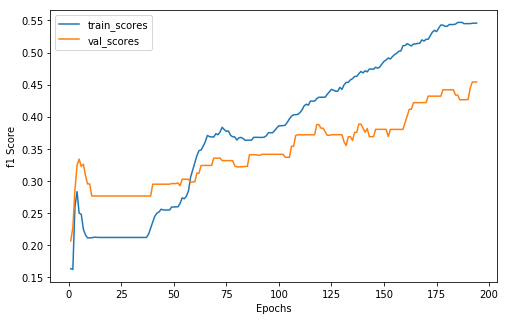

 55%|█████▌    | 194/350 [27:20<21:56,  8.44s/it]

Cofusion Matrix For Val Set: 
--  --  -
19  21  3
16  30  5
 6  10  4
--  --  -
Score This Epoch: 0.45415622389306604 Best Score: 0.45415622389306604
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 194 xxxxxxxxxxxxxx


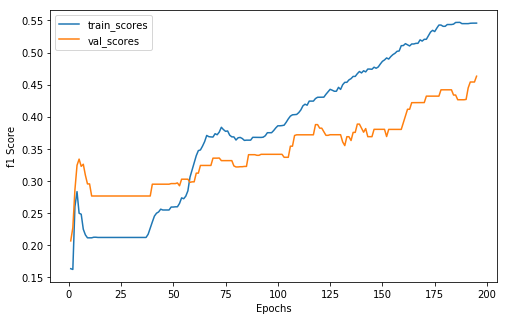

 56%|█████▌    | 195/350 [27:28<21:25,  8.29s/it]

Cofusion Matrix For Val Set: 
--  --  -
20  20  3
16  30  5
 6  10  4
--  --  -
Score This Epoch: 0.46318299723872475 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 195 xxxxxxxxxxxxxx


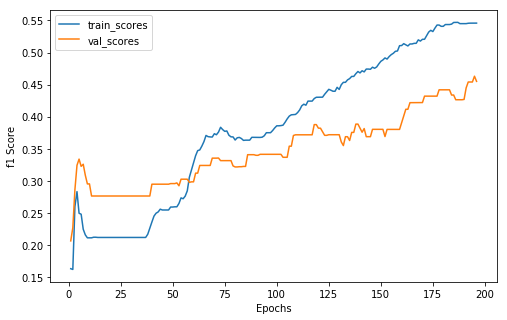

 56%|█████▌    | 196/350 [27:37<21:22,  8.33s/it]

Cofusion Matrix For Val Set: 
--  --  -
20  20  3
17  29  5
 6  10  4
--  --  -
Score This Epoch: 0.4551834130781499 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 196 xxxxxxxxxxxxxx


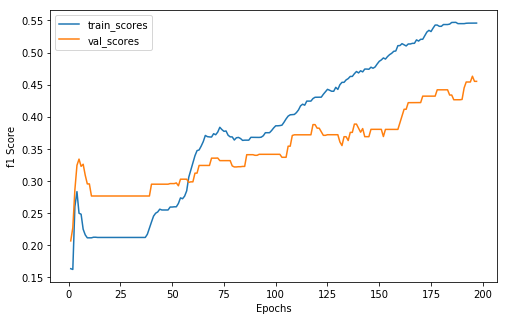

 56%|█████▋    | 197/350 [27:45<21:18,  8.36s/it]

Cofusion Matrix For Val Set: 
--  --  -
20  20  3
17  29  5
 6  10  4
--  --  -
Score This Epoch: 0.4551834130781499 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 1, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 197 xxxxxxxxxxxxxx


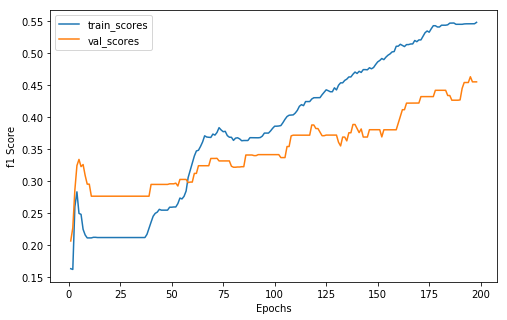

 57%|█████▋    | 198/350 [27:54<21:14,  8.39s/it]

Cofusion Matrix For Val Set: 
--  --  -
20  20  3
17  29  5
 6  10  4
--  --  -
Score This Epoch: 0.4551834130781499 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 198 xxxxxxxxxxxxxx


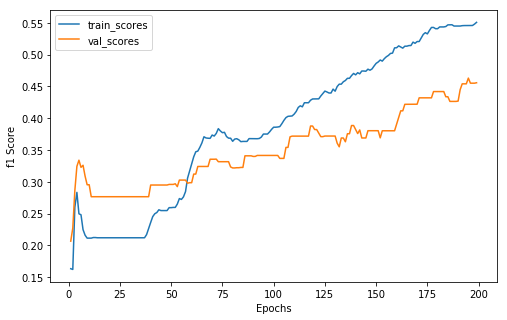

 57%|█████▋    | 199/350 [28:02<21:08,  8.40s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
18  28  5
 6  10  4
--  --  -
Score This Epoch: 0.45585238348396234 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 199 xxxxxxxxxxxxxx


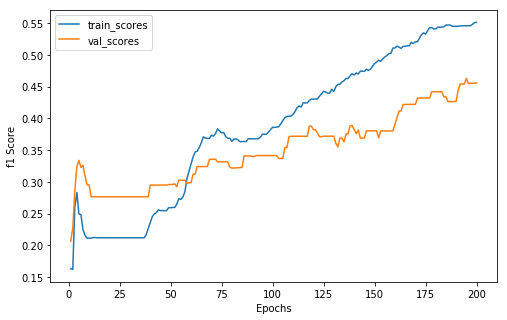

 57%|█████▋    | 200/350 [28:11<21:01,  8.41s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
18  28  5
 6  10  4
--  --  -
Score This Epoch: 0.45585238348396234 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 200 xxxxxxxxxxxxxx


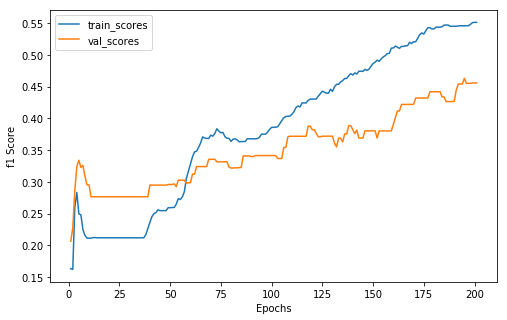

 57%|█████▋    | 201/350 [28:19<20:54,  8.42s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
18  28  5
 6  10  4
--  --  -
Score This Epoch: 0.45585238348396234 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 201 xxxxxxxxxxxxxx


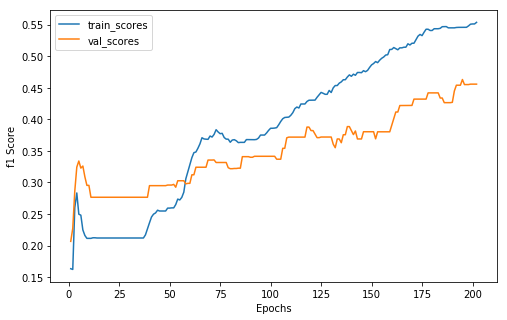

 58%|█████▊    | 202/350 [28:27<20:45,  8.42s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
18  28  5
 6  10  4
--  --  -
Score This Epoch: 0.45585238348396234 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 202 xxxxxxxxxxxxxx


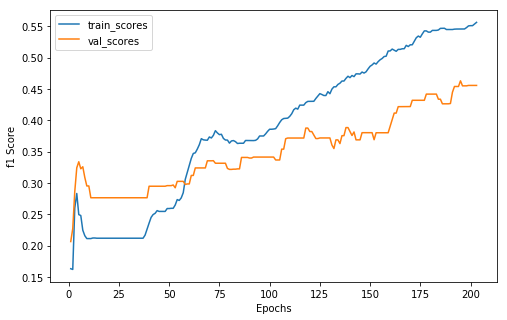

 58%|█████▊    | 203/350 [28:36<20:37,  8.42s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
18  28  5
 6  10  4
--  --  -
Score This Epoch: 0.45585238348396234 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 2, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 203 xxxxxxxxxxxxxx


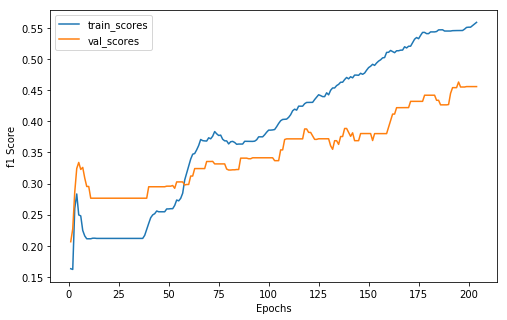

 58%|█████▊    | 204/350 [28:44<20:27,  8.41s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
18  28  5
 6  10  4
--  --  -
Score This Epoch: 0.45585238348396234 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 204 xxxxxxxxxxxxxx


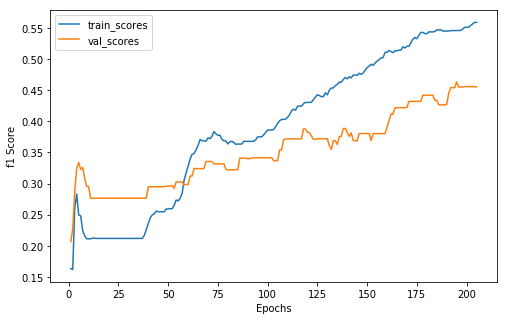

 59%|█████▊    | 205/350 [28:53<20:17,  8.40s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
19  28  4
 6  10  4
--  --  -
Score This Epoch: 0.4552444701621558 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 205 xxxxxxxxxxxxxx


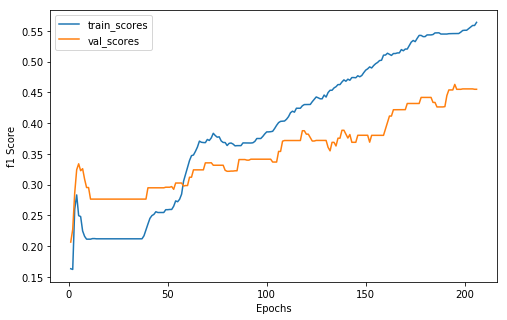

 59%|█████▉    | 206/350 [29:01<20:12,  8.42s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
19  28  4
 6  10  4
--  --  -
Score This Epoch: 0.4552444701621558 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 206 xxxxxxxxxxxxxx


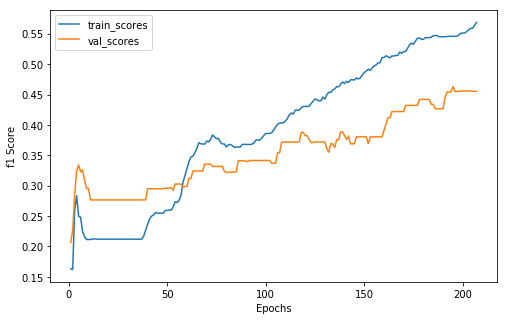

 59%|█████▉    | 207/350 [29:09<20:04,  8.43s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
19  28  4
 6  10  4
--  --  -
Score This Epoch: 0.4552444701621558 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 207 xxxxxxxxxxxxxx


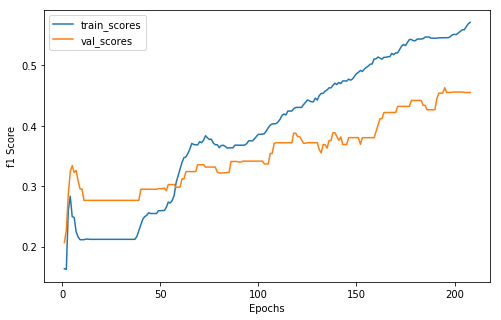

 59%|█████▉    | 208/350 [29:18<19:40,  8.31s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
19  28  4
 6  10  4
--  --  -
Score This Epoch: 0.4552444701621558 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 208 xxxxxxxxxxxxxx


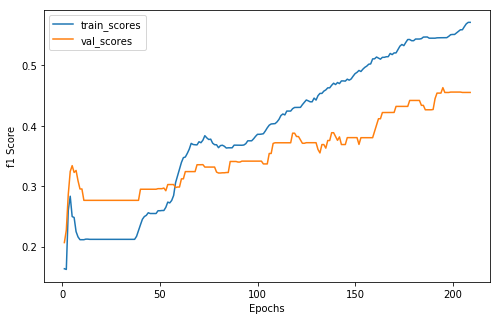

 60%|█████▉    | 209/350 [29:26<19:33,  8.33s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
19  28  4
 6  10  4
--  --  -
Score This Epoch: 0.4552444701621558 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 209 xxxxxxxxxxxxxx


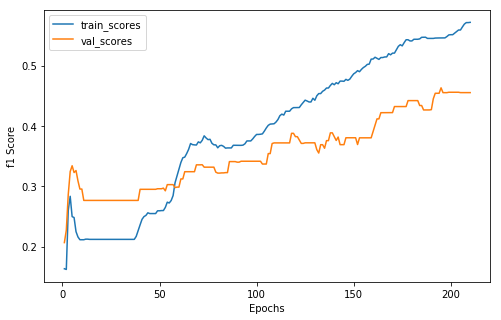

 60%|██████    | 210/350 [29:34<19:26,  8.33s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
19  28  4
 6  10  4
--  --  -
Score This Epoch: 0.4552444701621558 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 210 xxxxxxxxxxxxxx


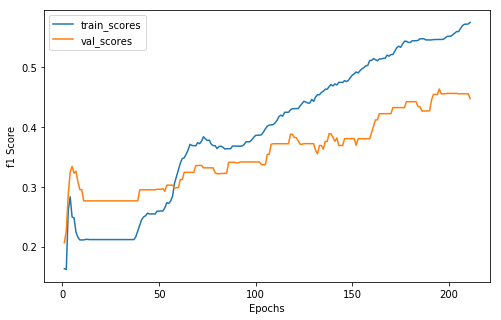

 60%|██████    | 211/350 [29:43<19:19,  8.34s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
20  27  4
 6  10  4
--  --  -
Score This Epoch: 0.4470725854934794 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 211 xxxxxxxxxxxxxx


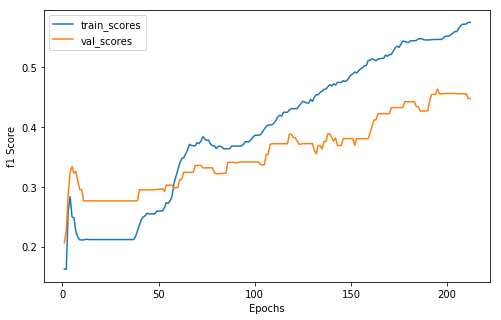

 61%|██████    | 212/350 [29:51<19:13,  8.36s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
20  27  4
 6  10  4
--  --  -
Score This Epoch: 0.4470725854934794 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 212 xxxxxxxxxxxxxx


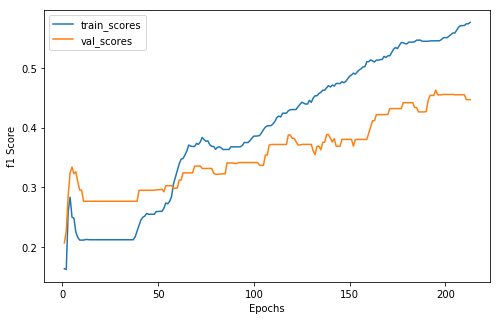

 61%|██████    | 213/350 [29:59<19:09,  8.39s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
20  27  4
 6  10  4
--  --  -
Score This Epoch: 0.4470725854934794 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 213 xxxxxxxxxxxxxx


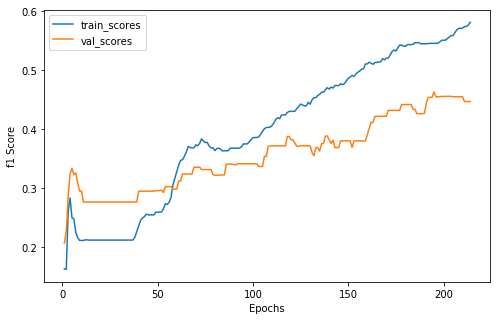

 61%|██████    | 214/350 [30:08<19:03,  8.41s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
20  27  4
 6  10  4
--  --  -
Score This Epoch: 0.4470725854934794 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 214 xxxxxxxxxxxxxx


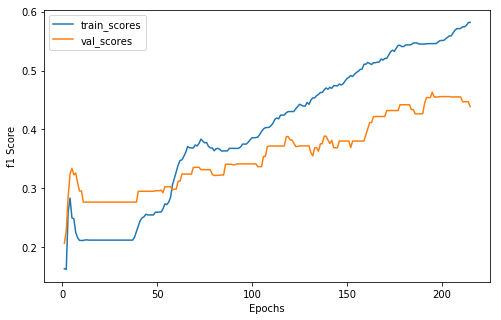

 61%|██████▏   | 215/350 [30:16<18:57,  8.42s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
21  26  4
 6  10  4
--  --  -
Score This Epoch: 0.4388272990637087 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 215 xxxxxxxxxxxxxx


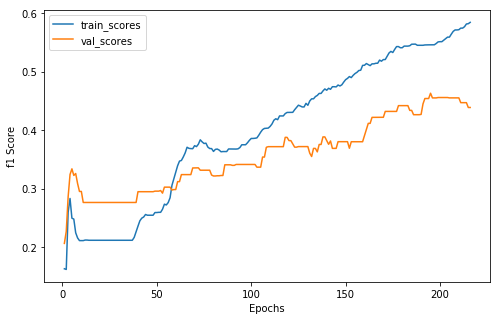

 62%|██████▏   | 216/350 [30:25<18:46,  8.41s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
21  26  4
 6  10  4
--  --  -
Score This Epoch: 0.4388272990637087 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 216 xxxxxxxxxxxxxx


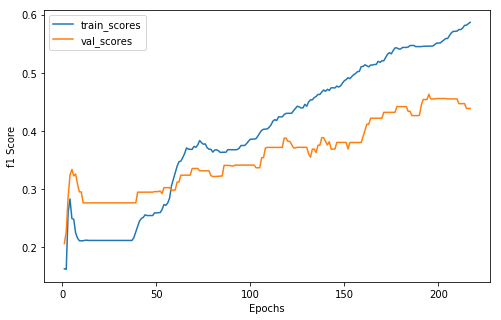

 62%|██████▏   | 217/350 [30:33<18:36,  8.40s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
21  26  4
 6  10  4
--  --  -
Score This Epoch: 0.4388272990637087 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 217 xxxxxxxxxxxxxx


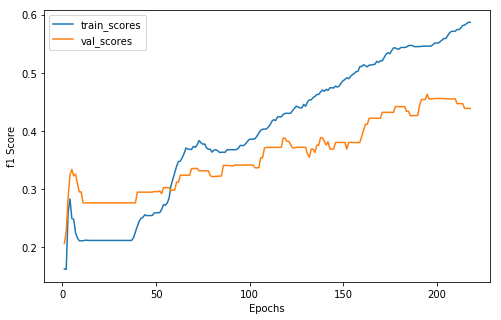

 62%|██████▏   | 218/350 [30:40<17:22,  7.89s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
21  26  4
 6  10  4
--  --  -
Score This Epoch: 0.4388272990637087 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 218 xxxxxxxxxxxxxx


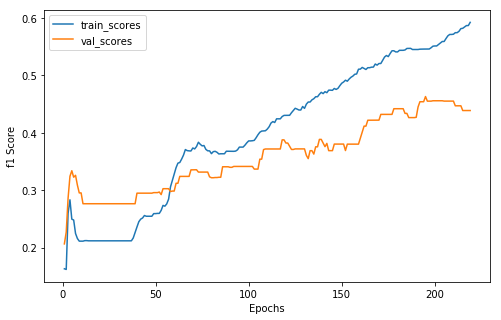

 63%|██████▎   | 219/350 [30:48<17:33,  8.05s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
21  26  4
 6  10  4
--  --  -
Score This Epoch: 0.4388272990637087 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 219 xxxxxxxxxxxxxx


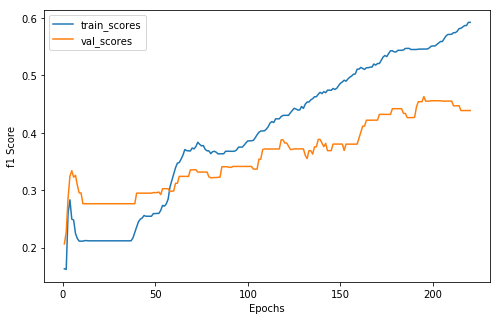

 63%|██████▎   | 220/350 [30:57<17:40,  8.16s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
21  26  4
 6  10  4
--  --  -
Score This Epoch: 0.4388272990637087 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 220 xxxxxxxxxxxxxx


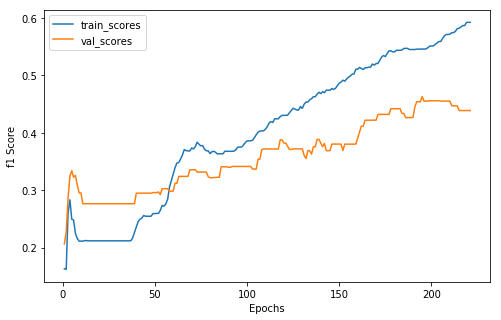

 63%|██████▎   | 221/350 [31:05<17:43,  8.24s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
21  26  4
 6  10  4
--  --  -
Score This Epoch: 0.4388272990637087 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 221 xxxxxxxxxxxxxx


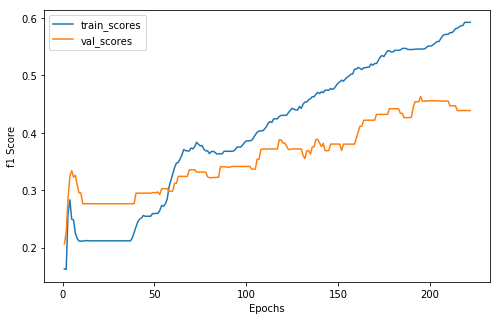

 63%|██████▎   | 222/350 [31:13<17:40,  8.29s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
21  26  4
 6  10  4
--  --  -
Score This Epoch: 0.4388272990637087 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 222 xxxxxxxxxxxxxx


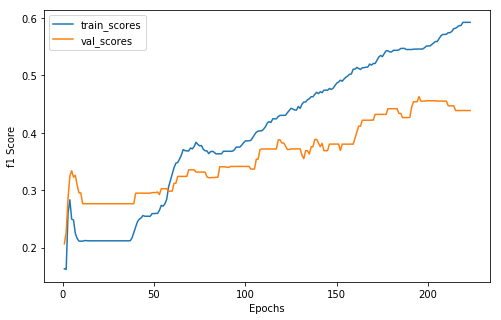

 64%|██████▎   | 223/350 [31:22<17:36,  8.32s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
21  26  4
 6  10  4
--  --  -
Score This Epoch: 0.4388272990637087 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 223 xxxxxxxxxxxxxx


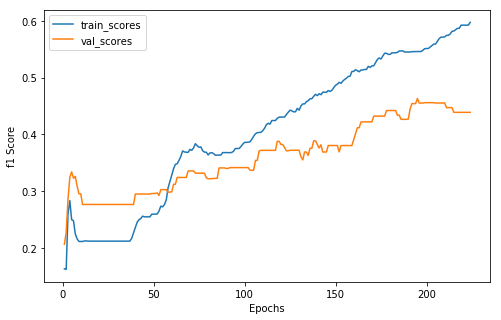

 64%|██████▍   | 224/350 [31:30<17:29,  8.33s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
21  26  4
 6  10  4
--  --  -
Score This Epoch: 0.4388272990637087 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 224 xxxxxxxxxxxxxx


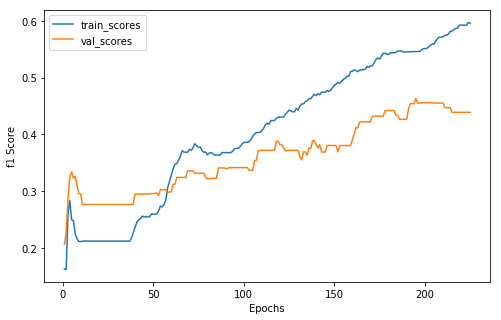

 64%|██████▍   | 225/350 [31:39<17:21,  8.33s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  19  3
21  26  4
 6  10  4
--  --  -
Score This Epoch: 0.4388272990637087 Best Score: 0.46318299723872475
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 225 xxxxxxxxxxxxxx


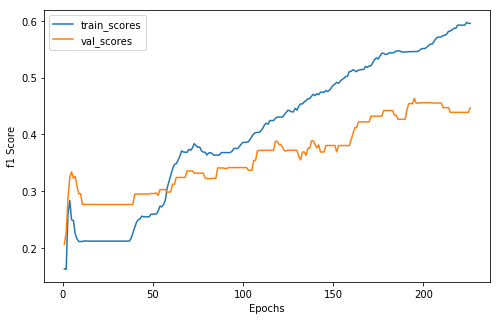

 65%|██████▍   | 226/350 [31:47<17:15,  8.35s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
21  26  4
 6  10  4
--  --  -
Score This Epoch: 0.44664402323829816 Best Score: 0.46318299723872475
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 226 xxxxxxxxxxxxxx


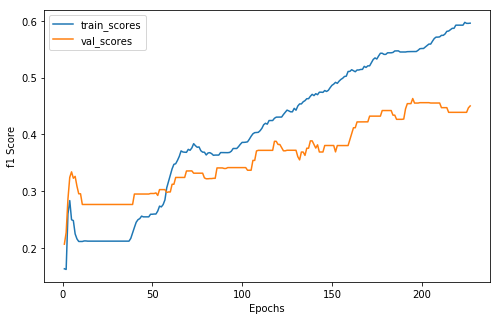

 65%|██████▍   | 227/350 [31:55<17:10,  8.38s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
22  25  4
 6   9  5
--  --  -
Score This Epoch: 0.45013096222773646 Best Score: 0.46318299723872475
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 227 xxxxxxxxxxxxxx


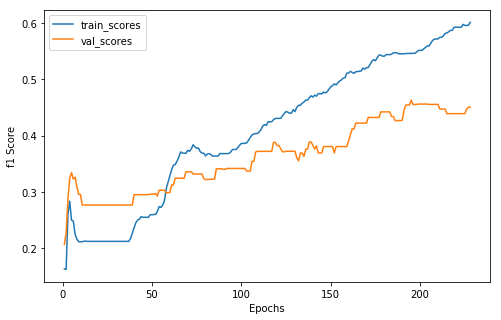

 65%|██████▌   | 228/350 [32:04<17:17,  8.50s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
22  25  4
 6   9  5
--  --  -
Score This Epoch: 0.45013096222773646 Best Score: 0.46318299723872475
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 228 xxxxxxxxxxxxxx


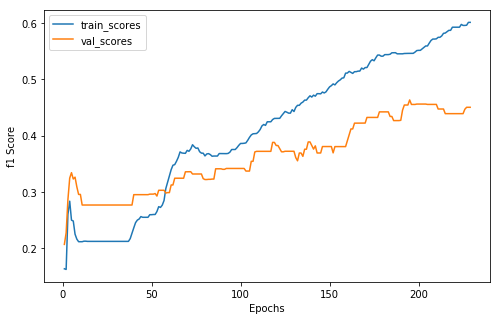

 65%|██████▌   | 229/350 [32:13<17:23,  8.63s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
22  25  4
 6   9  5
--  --  -
Score This Epoch: 0.45013096222773646 Best Score: 0.46318299723872475
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 229 xxxxxxxxxxxxxx


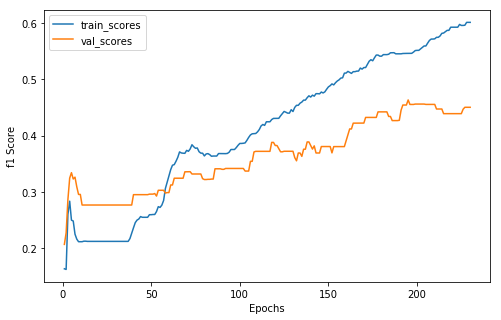

 66%|██████▌   | 230/350 [32:22<17:21,  8.68s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
22  25  4
 6   9  5
--  --  -
Score This Epoch: 0.45013096222773646 Best Score: 0.46318299723872475
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 230 xxxxxxxxxxxxxx


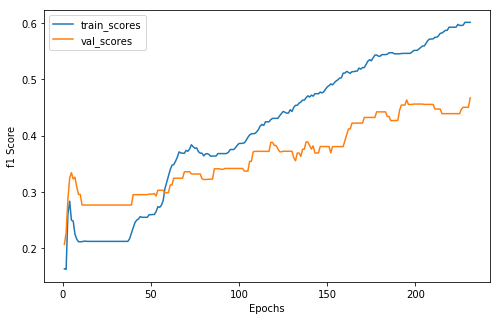

 66%|██████▌   | 231/350 [32:31<17:17,  8.72s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
21  26  4
 6   9  5
--  --  -
Score This Epoch: 0.4668458781362007 Best Score: 0.4668458781362007
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 231 xxxxxxxxxxxxxx


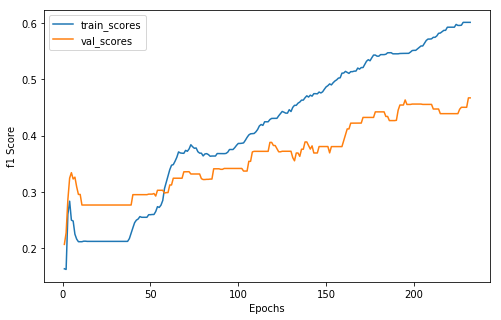

 66%|██████▋   | 232/350 [32:40<17:16,  8.79s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
21  26  4
 6   9  5
--  --  -
Score This Epoch: 0.4668458781362007 Best Score: 0.4668458781362007
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 232 xxxxxxxxxxxxxx


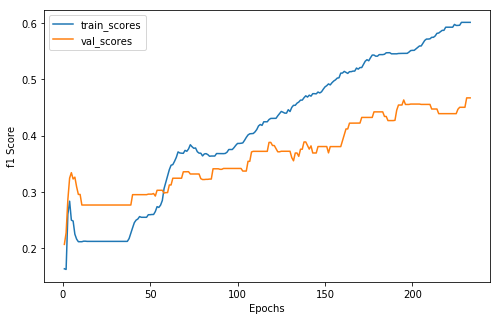

 67%|██████▋   | 233/350 [32:48<17:09,  8.80s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
21  26  4
 6   9  5
--  --  -
Score This Epoch: 0.4668458781362007 Best Score: 0.4668458781362007
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 233 xxxxxxxxxxxxxx


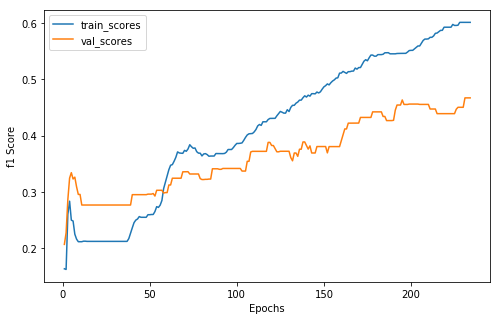

 67%|██████▋   | 234/350 [32:57<17:02,  8.82s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
21  26  4
 6   9  5
--  --  -
Score This Epoch: 0.4668458781362007 Best Score: 0.4668458781362007
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 234 xxxxxxxxxxxxxx


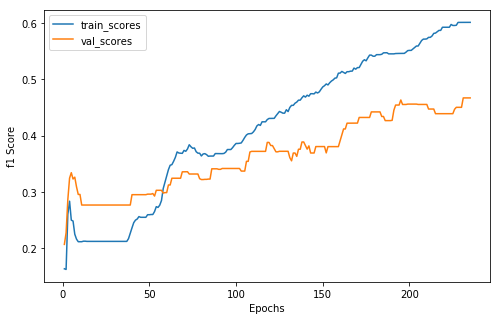

 67%|██████▋   | 235/350 [33:06<16:58,  8.85s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
21  26  4
 6   9  5
--  --  -
Score This Epoch: 0.4668458781362007 Best Score: 0.4668458781362007
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 235 xxxxxxxxxxxxxx


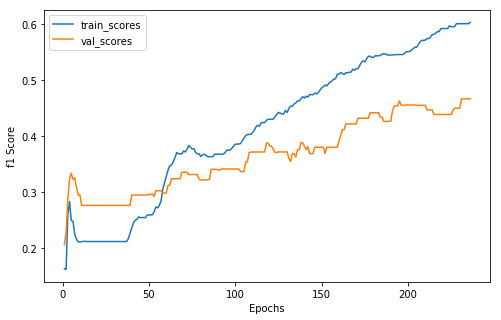

 67%|██████▋   | 236/350 [33:15<16:54,  8.90s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
21  26  4
 6   9  5
--  --  -
Score This Epoch: 0.4668458781362007 Best Score: 0.4668458781362007
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 236 xxxxxxxxxxxxxx


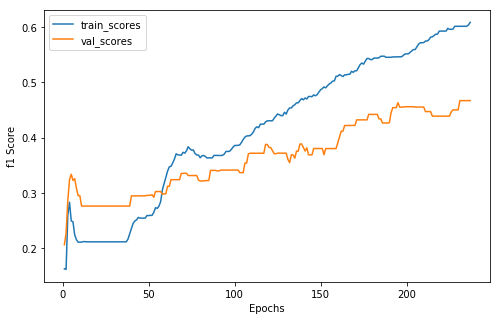

 68%|██████▊   | 237/350 [33:24<16:47,  8.92s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
21  26  4
 6   9  5
--  --  -
Score This Epoch: 0.4668458781362007 Best Score: 0.4668458781362007
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 237 xxxxxxxxxxxxxx


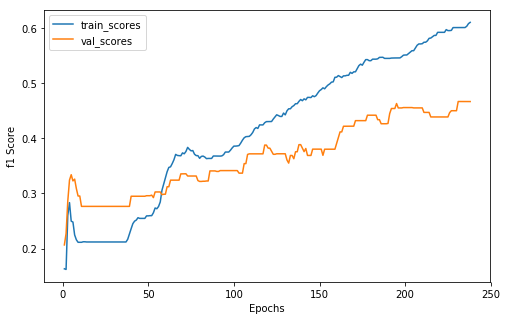

 68%|██████▊   | 238/350 [33:33<16:33,  8.87s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  27  4
 5  10  5
--  --  -
Score This Epoch: 0.46677327089874887 Best Score: 0.4668458781362007
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 238 xxxxxxxxxxxxxx


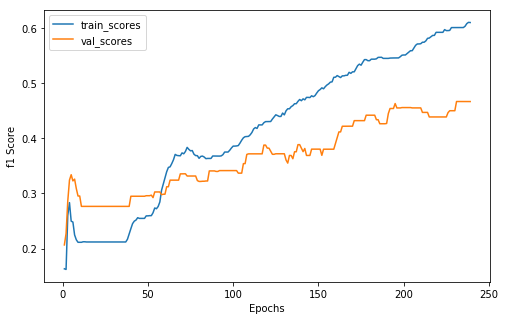

 68%|██████▊   | 239/350 [33:42<16:26,  8.89s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  27  4
 5  10  5
--  --  -
Score This Epoch: 0.46677327089874887 Best Score: 0.4668458781362007
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 239 xxxxxxxxxxxxxx


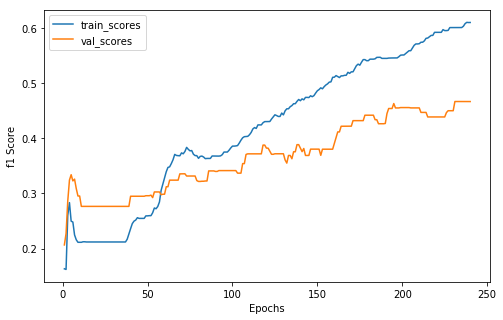

 69%|██████▊   | 240/350 [33:51<16:13,  8.85s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  27  4
 5  10  5
--  --  -
Score This Epoch: 0.46677327089874887 Best Score: 0.4668458781362007
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 240 xxxxxxxxxxxxxx


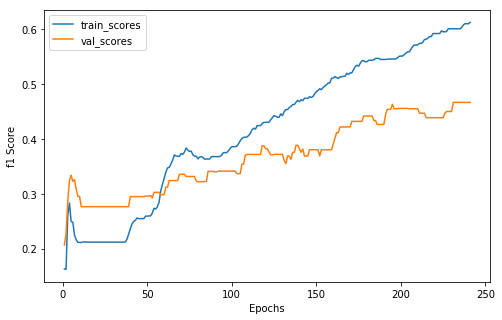

 69%|██████▉   | 241/350 [34:00<16:06,  8.87s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  27  4
 5  10  5
--  --  -
Score This Epoch: 0.46677327089874887 Best Score: 0.4668458781362007
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 241 xxxxxxxxxxxxxx


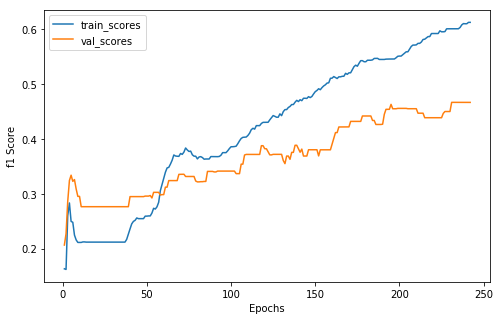

 69%|██████▉   | 242/350 [34:09<16:01,  8.91s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  27  4
 5  10  5
--  --  -
Score This Epoch: 0.46677327089874887 Best Score: 0.4668458781362007
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 242 xxxxxxxxxxxxxx


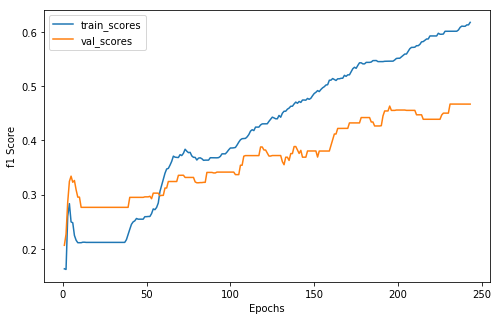

 69%|██████▉   | 243/350 [34:18<15:55,  8.93s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  27  4
 5  10  5
--  --  -
Score This Epoch: 0.46677327089874887 Best Score: 0.4668458781362007
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 243 xxxxxxxxxxxxxx


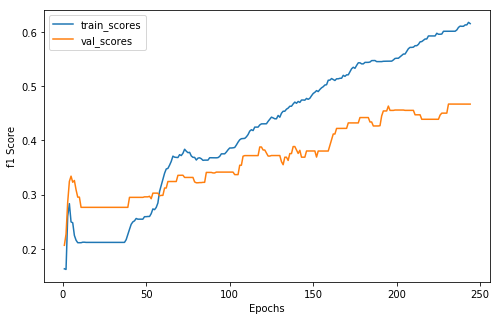

 70%|██████▉   | 244/350 [34:27<15:46,  8.93s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  27  4
 5  10  5
--  --  -
Score This Epoch: 0.46677327089874887 Best Score: 0.4668458781362007
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 244 xxxxxxxxxxxxxx


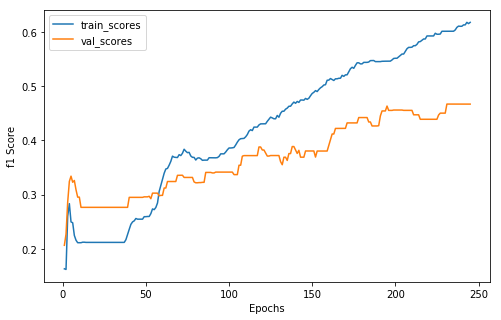

 70%|███████   | 245/350 [34:36<15:40,  8.96s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  27  4
 5  10  5
--  --  -
Score This Epoch: 0.46677327089874887 Best Score: 0.4668458781362007
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 245 xxxxxxxxxxxxxx


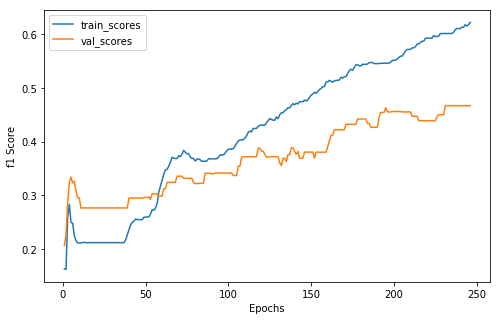

 70%|███████   | 246/350 [34:44<15:23,  8.88s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  27  4
 5  10  5
--  --  -
Score This Epoch: 0.46677327089874887 Best Score: 0.4668458781362007
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 246 xxxxxxxxxxxxxx


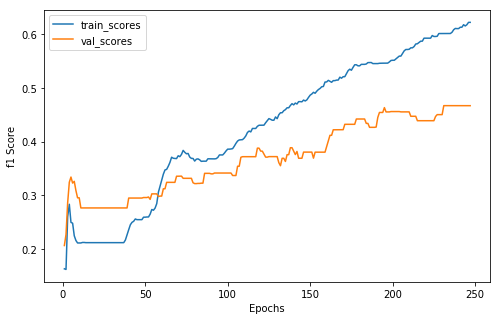

 71%|███████   | 247/350 [34:53<15:11,  8.85s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  27  4
 5  10  5
--  --  -
Score This Epoch: 0.46677327089874887 Best Score: 0.4668458781362007
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 247 xxxxxxxxxxxxxx


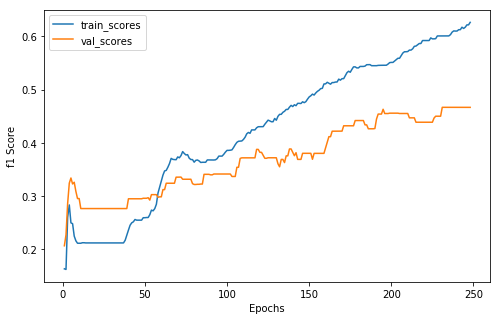

 71%|███████   | 248/350 [35:02<15:05,  8.88s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  27  4
 5  10  5
--  --  -
Score This Epoch: 0.46677327089874887 Best Score: 0.4668458781362007
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 248 xxxxxxxxxxxxxx


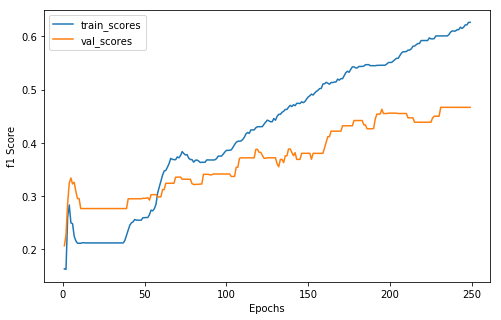

 71%|███████   | 249/350 [35:11<14:54,  8.86s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  27  4
 5  10  5
--  --  -
Score This Epoch: 0.46677327089874887 Best Score: 0.4668458781362007
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 249 xxxxxxxxxxxxxx


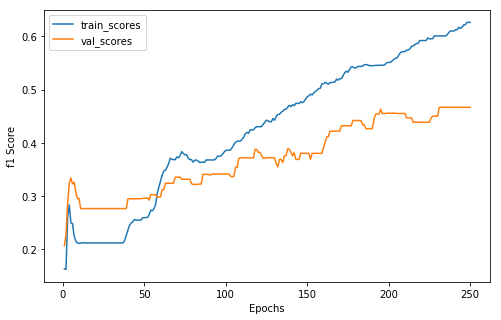

 71%|███████▏  | 250/350 [35:20<14:44,  8.84s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  27  4
 5  10  5
--  --  -
Score This Epoch: 0.46677327089874887 Best Score: 0.4668458781362007
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 250 xxxxxxxxxxxxxx


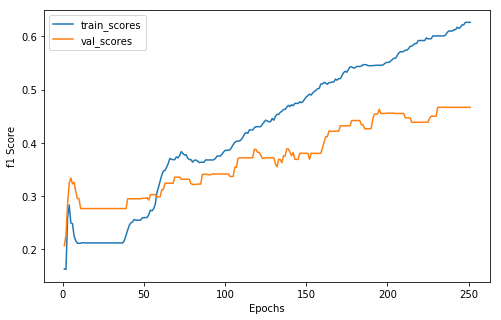

 72%|███████▏  | 251/350 [35:28<14:27,  8.77s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  27  4
 5  10  5
--  --  -
Score This Epoch: 0.46677327089874887 Best Score: 0.4668458781362007
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2]
xxxxxxxxxxxxxx epoch: 251 xxxxxxxxxxxxxx


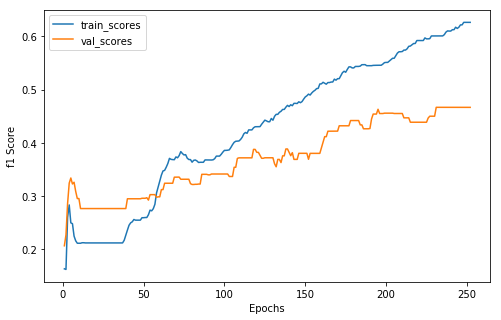

 72%|███████▏  | 252/350 [35:38<14:49,  9.08s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  27  4
 5  10  5
--  --  -
Score This Epoch: 0.46677327089874887 Best Score: 0.4668458781362007
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 252 xxxxxxxxxxxxxx


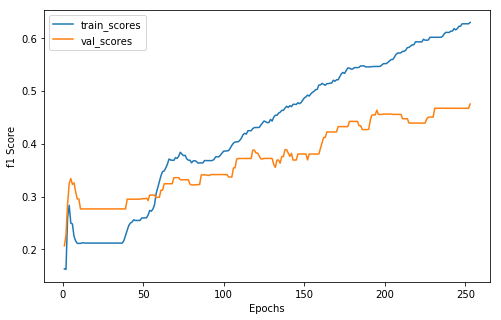

 72%|███████▏  | 253/350 [35:47<14:30,  8.97s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.47485380116959064 Best Score: 0.47485380116959064
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 253 xxxxxxxxxxxxxx


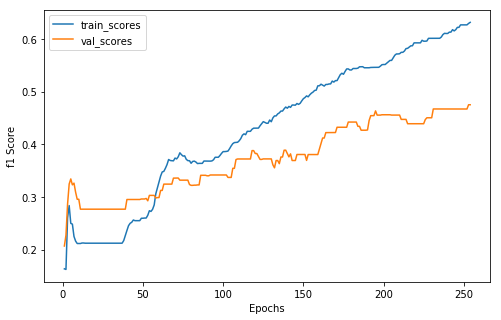

 73%|███████▎  | 254/350 [35:55<14:13,  8.89s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.47485380116959064 Best Score: 0.47485380116959064
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 254 xxxxxxxxxxxxxx


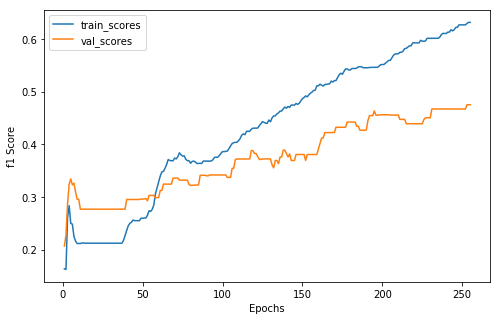

 73%|███████▎  | 255/350 [36:04<13:59,  8.84s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.47485380116959064 Best Score: 0.47485380116959064
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 255 xxxxxxxxxxxxxx


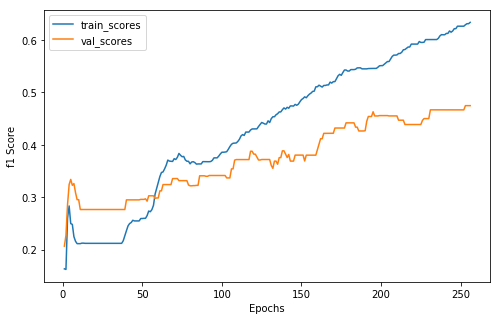

 73%|███████▎  | 256/350 [36:13<13:43,  8.76s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.47485380116959064 Best Score: 0.47485380116959064
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 256 xxxxxxxxxxxxxx


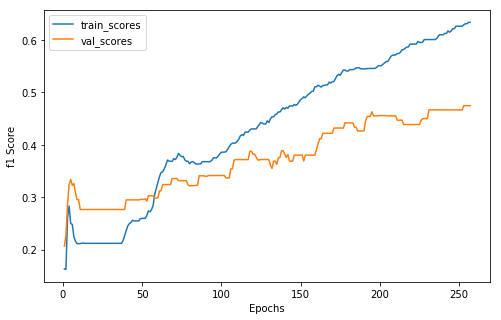

 73%|███████▎  | 257/350 [36:21<13:28,  8.70s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.47485380116959064 Best Score: 0.47485380116959064
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 257 xxxxxxxxxxxxxx


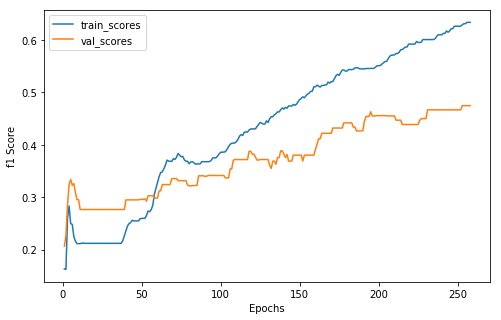

 74%|███████▎  | 258/350 [36:30<13:16,  8.66s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.47485380116959064 Best Score: 0.47485380116959064
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 258 xxxxxxxxxxxxxx


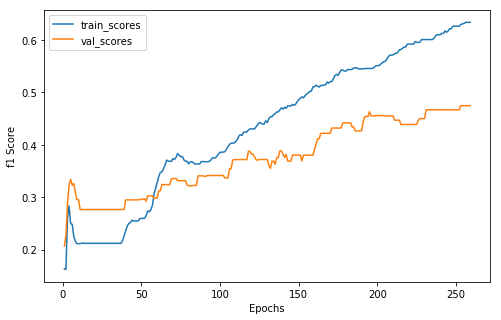

 74%|███████▍  | 259/350 [36:38<13:00,  8.58s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.47485380116959064 Best Score: 0.47485380116959064
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 259 xxxxxxxxxxxxxx


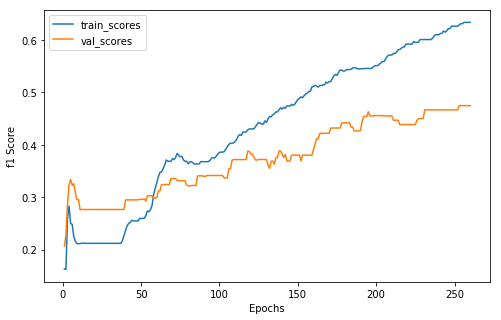

 74%|███████▍  | 260/350 [36:47<12:48,  8.53s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.47485380116959064 Best Score: 0.47485380116959064
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 260 xxxxxxxxxxxxxx


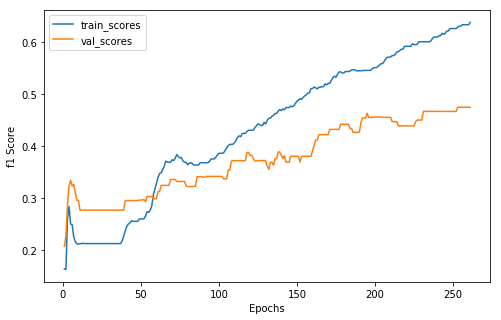

 75%|███████▍  | 261/350 [36:55<12:36,  8.50s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.47485380116959064 Best Score: 0.47485380116959064
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 261 xxxxxxxxxxxxxx


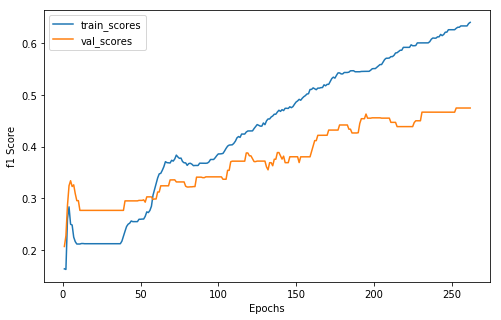

 75%|███████▍  | 262/350 [37:04<12:26,  8.48s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.47485380116959064 Best Score: 0.47485380116959064
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 262 xxxxxxxxxxxxxx


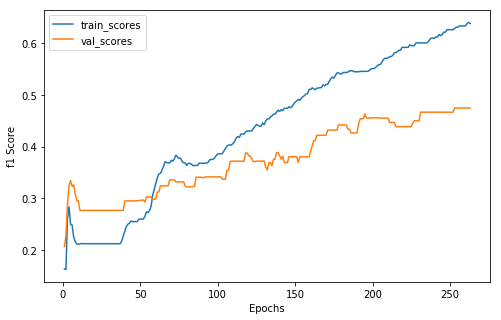

 75%|███████▌  | 263/350 [37:12<12:17,  8.48s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.47485380116959064 Best Score: 0.47485380116959064
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 263 xxxxxxxxxxxxxx


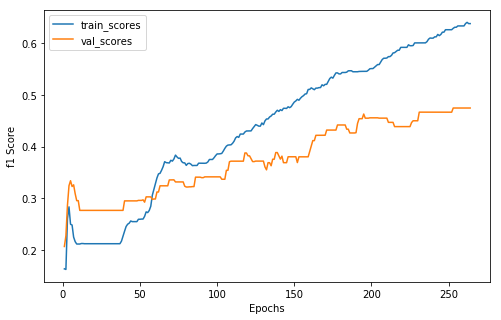

 75%|███████▌  | 264/350 [37:21<12:16,  8.56s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.47485380116959064 Best Score: 0.47485380116959064
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 264 xxxxxxxxxxxxxx


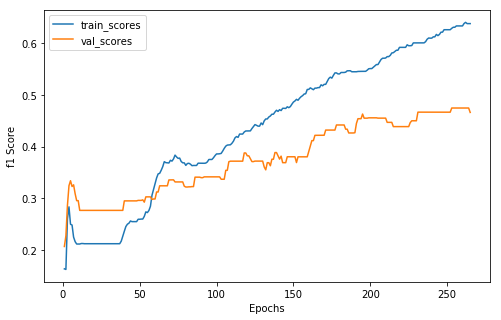

 76%|███████▌  | 265/350 [37:29<12:03,  8.51s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  20  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.4663213715834444 Best Score: 0.47485380116959064
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 265 xxxxxxxxxxxxxx


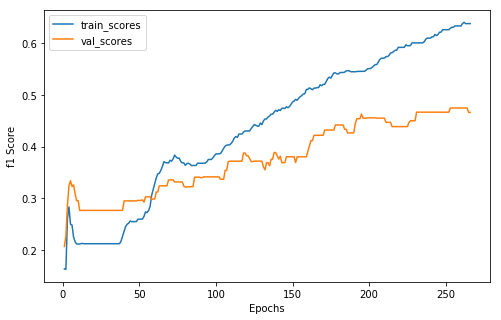

 76%|███████▌  | 266/350 [37:38<11:54,  8.51s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  20  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.4663213715834444 Best Score: 0.47485380116959064
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 266 xxxxxxxxxxxxxx


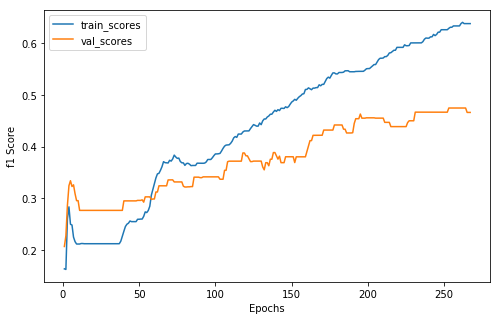

 76%|███████▋  | 267/350 [37:46<11:43,  8.47s/it]

Cofusion Matrix For Val Set: 
--  --  -
21  20  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.4663213715834444 Best Score: 0.47485380116959064
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 267 xxxxxxxxxxxxxx


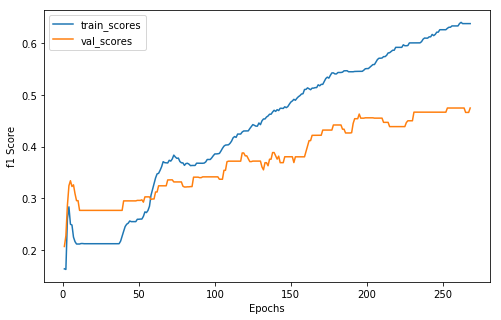

 77%|███████▋  | 268/350 [37:54<11:33,  8.45s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.47485380116959064 Best Score: 0.47485380116959064
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 268 xxxxxxxxxxxxxx


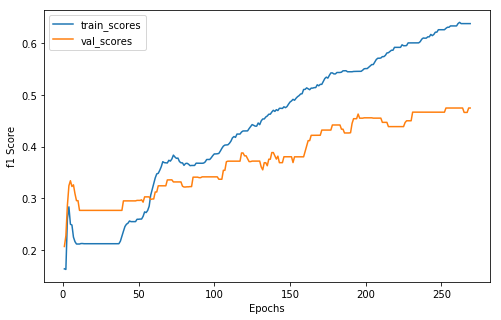

 77%|███████▋  | 269/350 [38:03<11:25,  8.46s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.47485380116959064 Best Score: 0.47485380116959064
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 269 xxxxxxxxxxxxxx


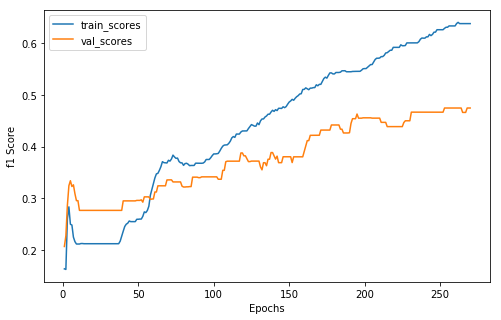

 77%|███████▋  | 270/350 [38:11<11:15,  8.44s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.47485380116959064 Best Score: 0.47485380116959064
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 270 xxxxxxxxxxxxxx


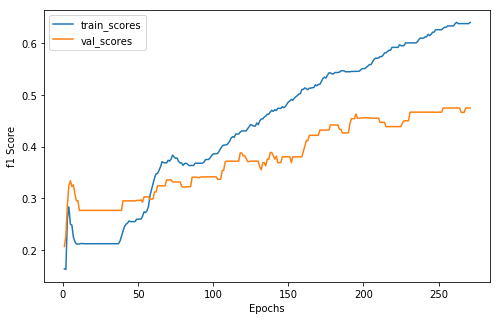

 77%|███████▋  | 271/350 [38:20<11:07,  8.45s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.47485380116959064 Best Score: 0.47485380116959064
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 271 xxxxxxxxxxxxxx


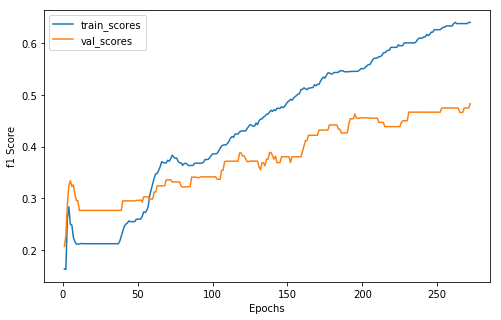

 78%|███████▊  | 272/350 [38:28<10:58,  8.45s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.48328525603488715 Best Score: 0.48328525603488715
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 272 xxxxxxxxxxxxxx


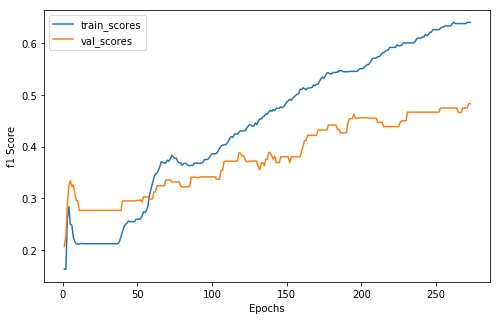

 78%|███████▊  | 273/350 [38:37<10:47,  8.41s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.48328525603488715 Best Score: 0.48328525603488715
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 273 xxxxxxxxxxxxxx


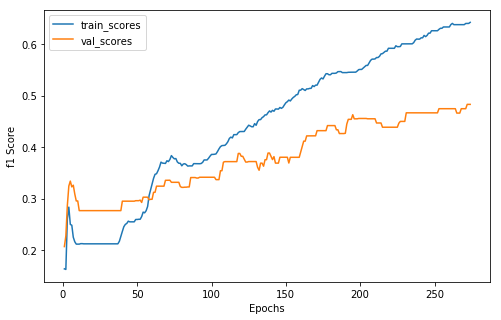

 78%|███████▊  | 274/350 [38:45<10:38,  8.40s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.48328525603488715 Best Score: 0.48328525603488715
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 274 xxxxxxxxxxxxxx


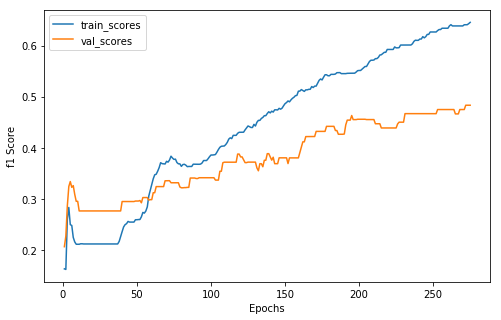

 79%|███████▊  | 275/350 [38:53<10:29,  8.40s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.48328525603488715 Best Score: 0.48328525603488715
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 275 xxxxxxxxxxxxxx


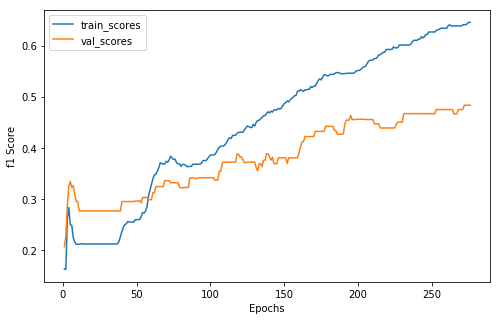

 79%|███████▉  | 276/350 [39:02<10:22,  8.41s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.48328525603488715 Best Score: 0.48328525603488715
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 276 xxxxxxxxxxxxxx


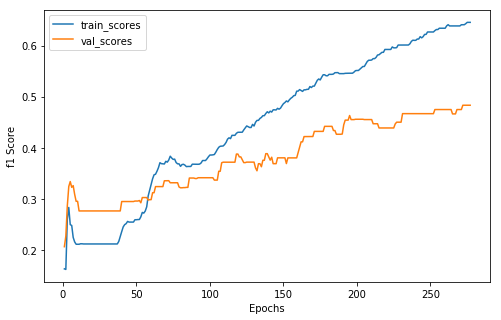

 79%|███████▉  | 277/350 [39:10<10:14,  8.42s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.48328525603488715 Best Score: 0.48328525603488715
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 277 xxxxxxxxxxxxxx


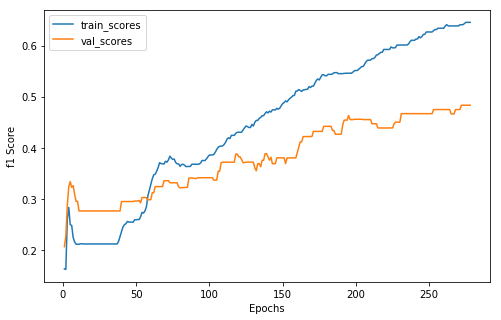

 79%|███████▉  | 278/350 [39:19<10:06,  8.42s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
20  28  3
 5  10  5
--  --  -
Score This Epoch: 0.48328525603488715 Best Score: 0.48328525603488715
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 278 xxxxxxxxxxxxxx


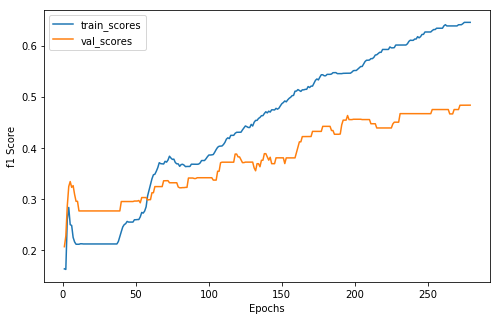

 80%|███████▉  | 279/350 [39:27<09:58,  8.43s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
20  28  3
 6   9  5
--  --  -
Score This Epoch: 0.48342160432527853 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 279 xxxxxxxxxxxxxx


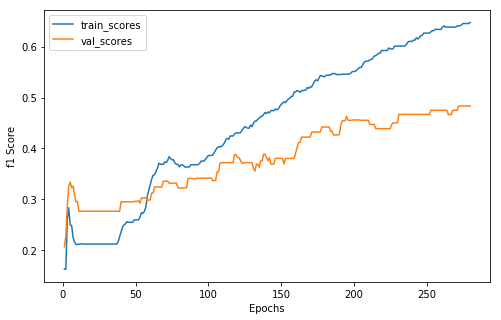

 80%|████████  | 280/350 [39:36<09:52,  8.47s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
20  28  3
 6   9  5
--  --  -
Score This Epoch: 0.48342160432527853 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 280 xxxxxxxxxxxxxx


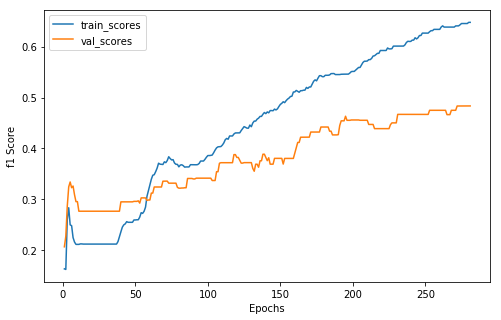

 80%|████████  | 281/350 [39:44<09:48,  8.53s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
20  28  3
 6   9  5
--  --  -
Score This Epoch: 0.48342160432527853 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 281 xxxxxxxxxxxxxx


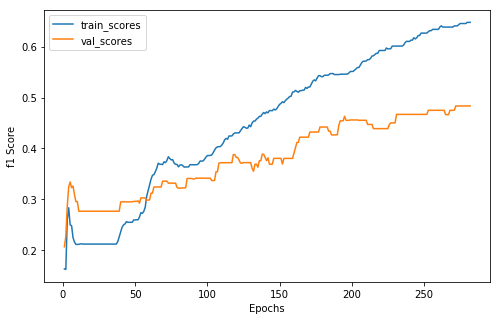

 81%|████████  | 282/350 [39:53<09:43,  8.57s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
20  28  3
 6   9  5
--  --  -
Score This Epoch: 0.48342160432527853 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 282 xxxxxxxxxxxxxx


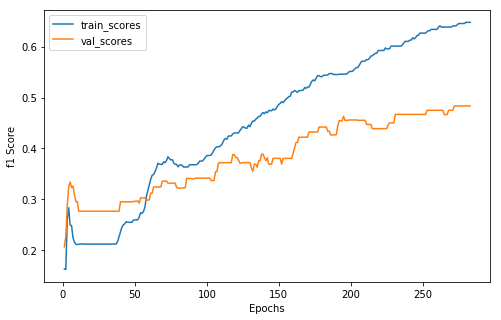

 81%|████████  | 283/350 [40:02<09:36,  8.61s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
20  28  3
 6   9  5
--  --  -
Score This Epoch: 0.48342160432527853 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 283 xxxxxxxxxxxxxx


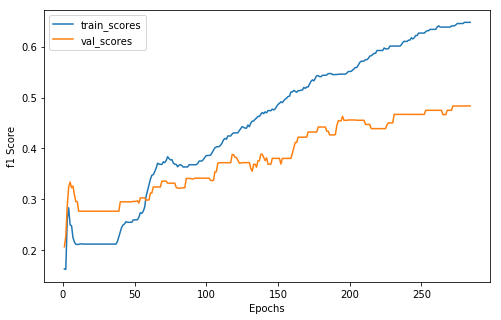

 81%|████████  | 284/350 [40:10<09:26,  8.59s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
20  28  3
 6   9  5
--  --  -
Score This Epoch: 0.48342160432527853 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 284 xxxxxxxxxxxxxx


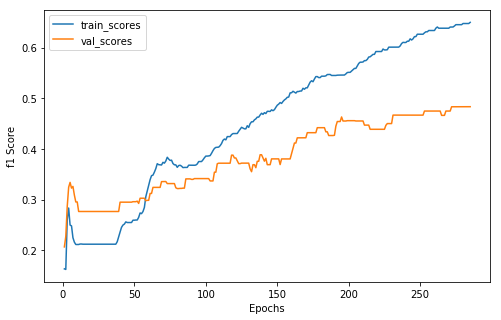

 81%|████████▏ | 285/350 [40:19<09:20,  8.62s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
20  28  3
 6   9  5
--  --  -
Score This Epoch: 0.48342160432527853 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 285 xxxxxxxxxxxxxx


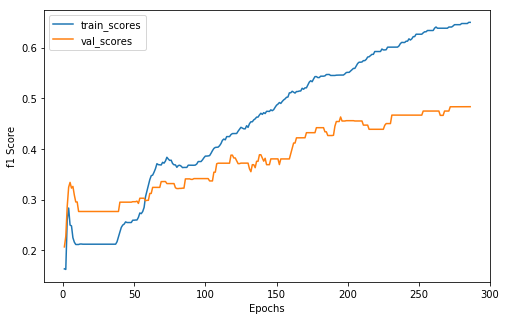

 82%|████████▏ | 286/350 [40:28<09:16,  8.70s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
20  28  3
 6   9  5
--  --  -
Score This Epoch: 0.48342160432527853 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 286 xxxxxxxxxxxxxx


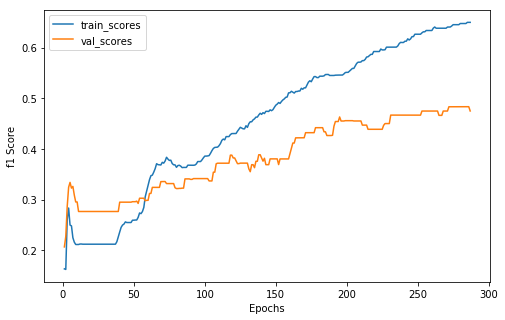

 82%|████████▏ | 287/350 [40:37<09:09,  8.72s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  28  3
 6   9  5
--  --  -
Score This Epoch: 0.4749953003765104 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 287 xxxxxxxxxxxxxx


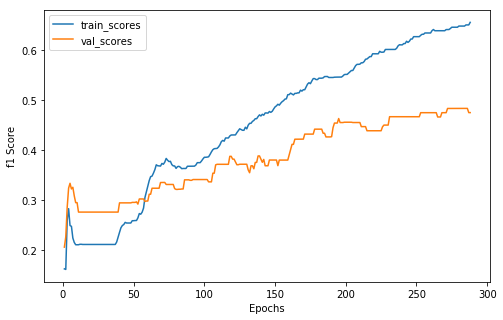

 82%|████████▏ | 288/350 [40:45<09:03,  8.77s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  28  3
 6   9  5
--  --  -
Score This Epoch: 0.4749953003765104 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 288 xxxxxxxxxxxxxx


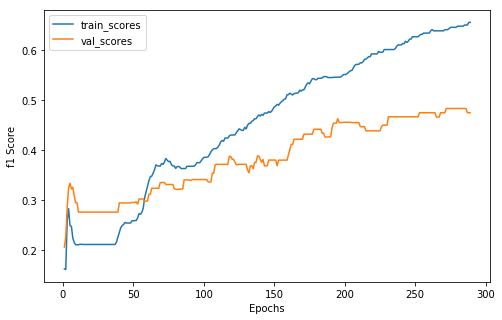

 83%|████████▎ | 289/350 [40:54<08:56,  8.79s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
20  28  3
 6   9  5
--  --  -
Score This Epoch: 0.4749953003765104 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 289 xxxxxxxxxxxxxx


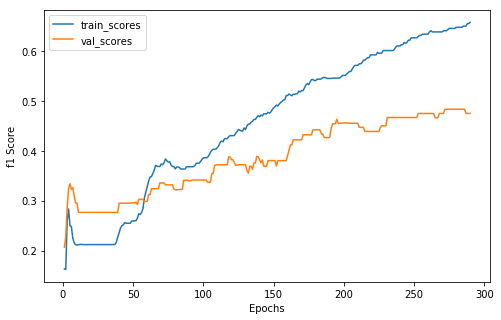

 83%|████████▎ | 290/350 [41:03<08:49,  8.83s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
21  28  2
 6   9  5
--  --  -
Score This Epoch: 0.47502945526744744 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 290 xxxxxxxxxxxxxx


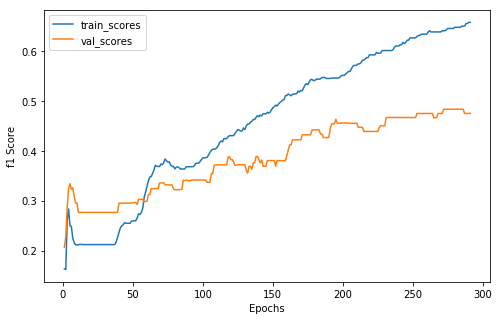

 83%|████████▎ | 291/350 [41:12<08:41,  8.84s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
21  28  2
 6   9  5
--  --  -
Score This Epoch: 0.47502945526744744 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 291 xxxxxxxxxxxxxx


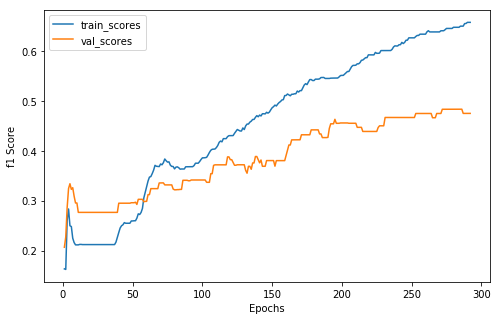

 83%|████████▎ | 292/350 [41:21<08:32,  8.83s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
21  28  2
 6   9  5
--  --  -
Score This Epoch: 0.47502945526744744 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 292 xxxxxxxxxxxxxx


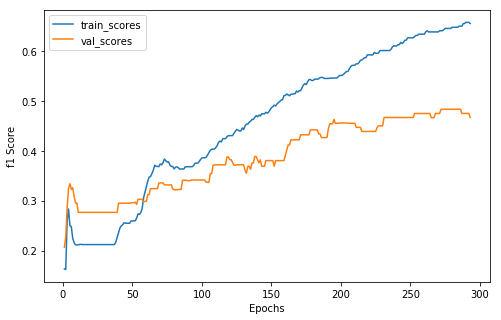

 84%|████████▎ | 293/350 [41:30<08:22,  8.82s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
22  27  2
 6   9  5
--  --  -
Score This Epoch: 0.46685763000978076 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 293 xxxxxxxxxxxxxx


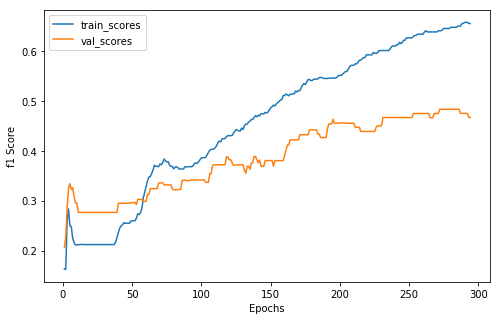

 84%|████████▍ | 294/350 [41:38<08:10,  8.77s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
22  27  2
 6   9  5
--  --  -
Score This Epoch: 0.46685763000978076 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 294 xxxxxxxxxxxxxx


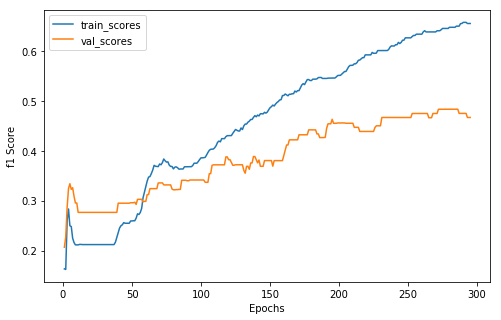

 84%|████████▍ | 295/350 [41:47<08:04,  8.81s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
22  27  2
 6   9  5
--  --  -
Score This Epoch: 0.46685763000978076 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 295 xxxxxxxxxxxxxx


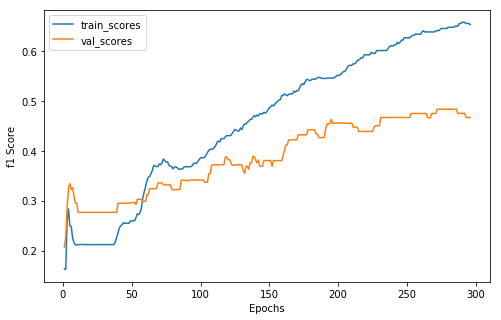

 85%|████████▍ | 296/350 [41:56<07:56,  8.82s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
22  27  2
 6   9  5
--  --  -
Score This Epoch: 0.46685763000978076 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 296 xxxxxxxxxxxxxx


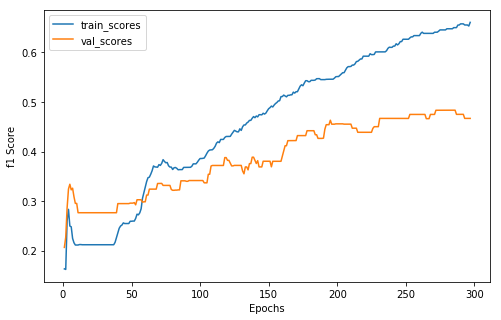

 85%|████████▍ | 297/350 [42:05<07:47,  8.81s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
22  27  2
 6   9  5
--  --  -
Score This Epoch: 0.46685763000978076 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 297 xxxxxxxxxxxxxx


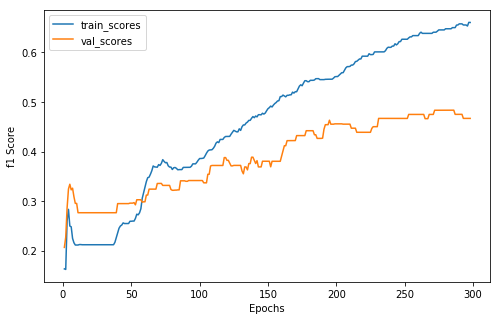

 85%|████████▌ | 298/350 [42:14<07:38,  8.81s/it]

Cofusion Matrix For Val Set: 
--  --  -
22  19  2
22  27  2
 6   9  5
--  --  -
Score This Epoch: 0.46685763000978076 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 298 xxxxxxxxxxxxxx


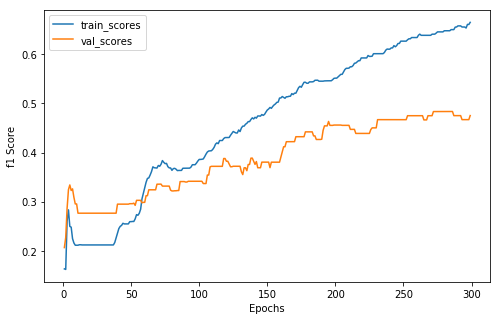

 85%|████████▌ | 299/350 [42:22<07:28,  8.79s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
22  27  2
 6   9  5
--  --  -
Score This Epoch: 0.47515505565086597 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 299 xxxxxxxxxxxxxx


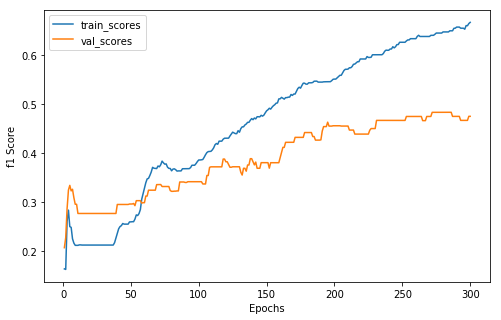

 86%|████████▌ | 300/350 [42:31<07:18,  8.76s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
22  27  2
 6   9  5
--  --  -
Score This Epoch: 0.47515505565086597 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 300 xxxxxxxxxxxxxx


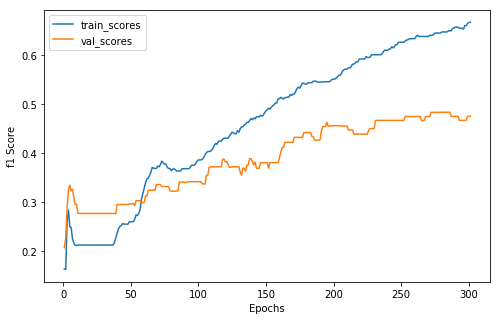

 86%|████████▌ | 301/350 [42:40<07:08,  8.74s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
22  27  2
 6   9  5
--  --  -
Score This Epoch: 0.47515505565086597 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 301 xxxxxxxxxxxxxx


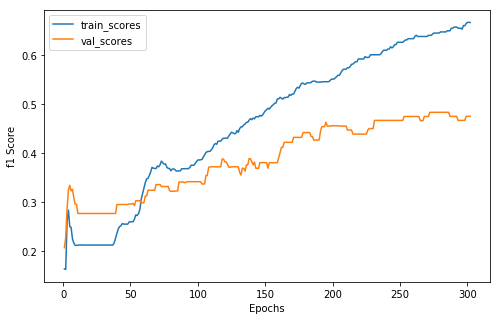

 86%|████████▋ | 302/350 [42:48<06:57,  8.69s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
22  27  2
 6   9  5
--  --  -
Score This Epoch: 0.47515505565086597 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 302 xxxxxxxxxxxxxx


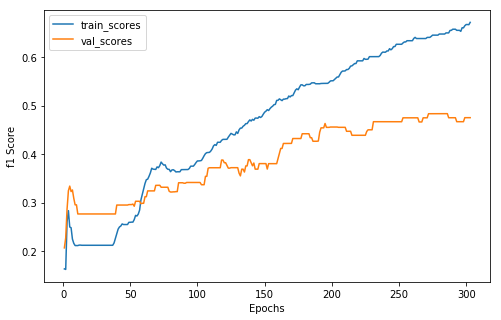

 87%|████████▋ | 303/350 [42:57<06:46,  8.64s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
22  27  2
 6   9  5
--  --  -
Score This Epoch: 0.47515505565086597 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 303 xxxxxxxxxxxxxx


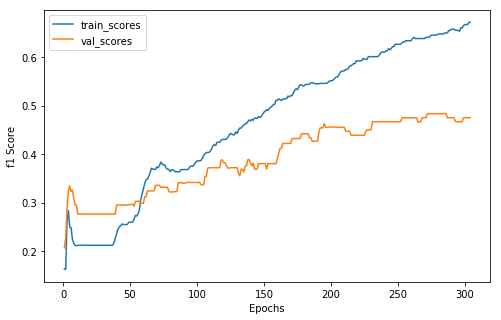

 87%|████████▋ | 304/350 [43:05<06:34,  8.58s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
22  27  2
 6   9  5
--  --  -
Score This Epoch: 0.47515505565086597 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 304 xxxxxxxxxxxxxx


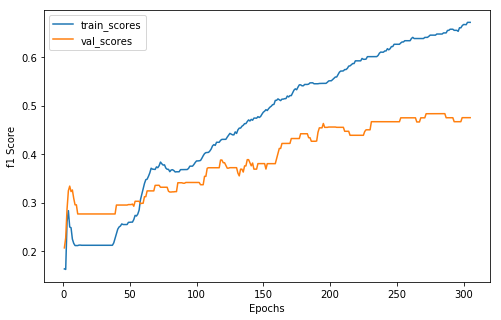

 87%|████████▋ | 305/350 [43:14<06:24,  8.54s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
22  27  2
 6   9  5
--  --  -
Score This Epoch: 0.47515505565086597 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 305 xxxxxxxxxxxxxx


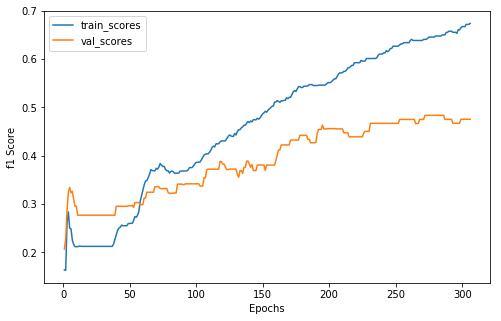

 87%|████████▋ | 306/350 [43:22<06:14,  8.51s/it]

Cofusion Matrix For Val Set: 
--  --  -
23  18  2
22  27  2
 6   9  5
--  --  -
Score This Epoch: 0.47515505565086597 Best Score: 0.48342160432527853
[1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1]
xxxxxxxxxxxxxx epoch: 306 xxxxxxxxxxxxxx


In [ ]:
for split_no, split in enumerate(splits):
    print("Split No: ", split_no)

    best_split_score = -1
    epoch_at_best_score = 0

    tensorified_data['train_ids'] = split['train_ids']
    data['train_ids'] = split['train_ids']

    tensorified_data['val_ids'] = split['val_ids']
    data['val_ids'] = split['val_ids']

    tensorified_data['test_ids'] = []

    validation_user_statistics_over_epochs = []

    class_weights = torch.tensor(statistics.get_class_weights_in_inverse_proportion(data))
    class_weights = torch.tensor([0.93, 0.82, 1])
    print(class_weights)
    
    total_loss_over_epochs, scores_over_epochs = plotting.get_empty_stat_over_n_epoch_dictionaries()

    model = autoencoder_classifier.AutoEncoderClassifier(
        conversions.prepend_ids_with_string(student_list, "student_"),
        num_features,
        autoencoder_bottle_neck_feature_size,
        autoencoder_num_layers,
        shared_hidden_layer_size,
        user_dense_layer_hidden_size,
        num_classes,
        num_covariates,
        shared_layer_dropout_prob,
        user_head_dropout_prob)
    
    if cuda_enabled:
        model.cuda()
        class_weights = class_weights.cuda()

    reconstruction_criterion = torch.nn.L1Loss(reduction="sum")
    classification_criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)
    
    for epoch in tqdm.tqdm(range(n_epochs)):

        (train_total_loss, train_total_reconstruction_loss, train_total_classification_loss,
         train_labels, train_preds, train_users) = trainer.evaluate_multitask_learner(tensorified_data,
                                                                                      'train_ids',
                                                                                      num_classes,
                                                                                      model,
                                                                                      reconstruction_criterion,
                                                                                      classification_criterion,
                                                                                      device,
                                                                                      optimizer=optimizer,
                                                                                      alpha=alpha,
                                                                                      beta=beta,
                                                                                      use_histogram=use_historgram)

        (val_total_loss, val_total_reconstruction_loss, val_total_classification_loss,
         val_labels, val_preds, val_users) = trainer.evaluate_multitask_learner(tensorified_data,
                                                                                'val_ids',
                                                                                num_classes,
                                                                                model,
                                                                                reconstruction_criterion,
                                                                                classification_criterion,
                                                                                device,
                                                                                alpha=alpha,
                                                                                beta=beta,
                                                                                use_histogram=use_historgram)

        ######## Appending Metrics ########
        train_label_list = conversions.tensor_list_to_int_list(train_labels)
        train_pred_list = conversions.tensor_list_to_int_list(train_preds)
        val_label_list = conversions.tensor_list_to_int_list(val_labels)
        val_pred_list = conversions.tensor_list_to_int_list(val_preds)

        train_scores = metrics.precision_recall_fscore_support(train_label_list, train_pred_list, average='weighted')
        val_scores = metrics.precision_recall_fscore_support(val_label_list, val_pred_list, average='weighted')
        
        scores_over_epochs['train_scores'].append(train_scores)
        scores_over_epochs['val_scores'].append(val_scores)

        validation_user_statistics_over_epochs.append(statistics.generate_training_statistics_for_user(val_labels,
                                                                                                       val_preds,
                                                                                                       val_users))
        print(val_pred_list)
        
        if epoch%1 == 0:
            print("xxxxxxxxxxxxxx epoch: {} xxxxxxxxxxxxxx".format(epoch))
            plotting.plot_score_over_n_epochs(scores_over_epochs, score_type='f1', fig_size=(8,5))
            print("Cofusion Matrix For Val Set: ")
            print(tabulate(metrics.confusion_matrix(val_label_list, val_pred_list)))
            
        if val_scores[2] > best_split_score:
            best_split_score = val_scores[2]
            epoch_at_best_score = epoch

        print("Score This Epoch: {} Best Score: {}".format(val_scores[2], best_split_score))

    split_val_scores.append(best_split_score)
    best_score_epoch_log.append(epoch_at_best_score)

    print("Avg Cross Val Score: {}".format(list_mean(split_val_scores)))

scores_and_epochs = (split_val_scores, epoch_at_best_score)
scores_and_epochs_file_name = os.path.join(definitions.DATA_DIR, "cross_val_scores/multitask_autoencoder.pkl")
write_utils.data_structure_to_pickle(scores_and_epochs, scores_and_epochs_file_name)
